# SeSAC Project : Brazilian E-Commerce

## Dataset Schema
https://www.kaggle.com/code/pavelgrigoryev/deep-sales-analysis-eda-viz-rfm-nlp-geo#4.2.7-ARPPU
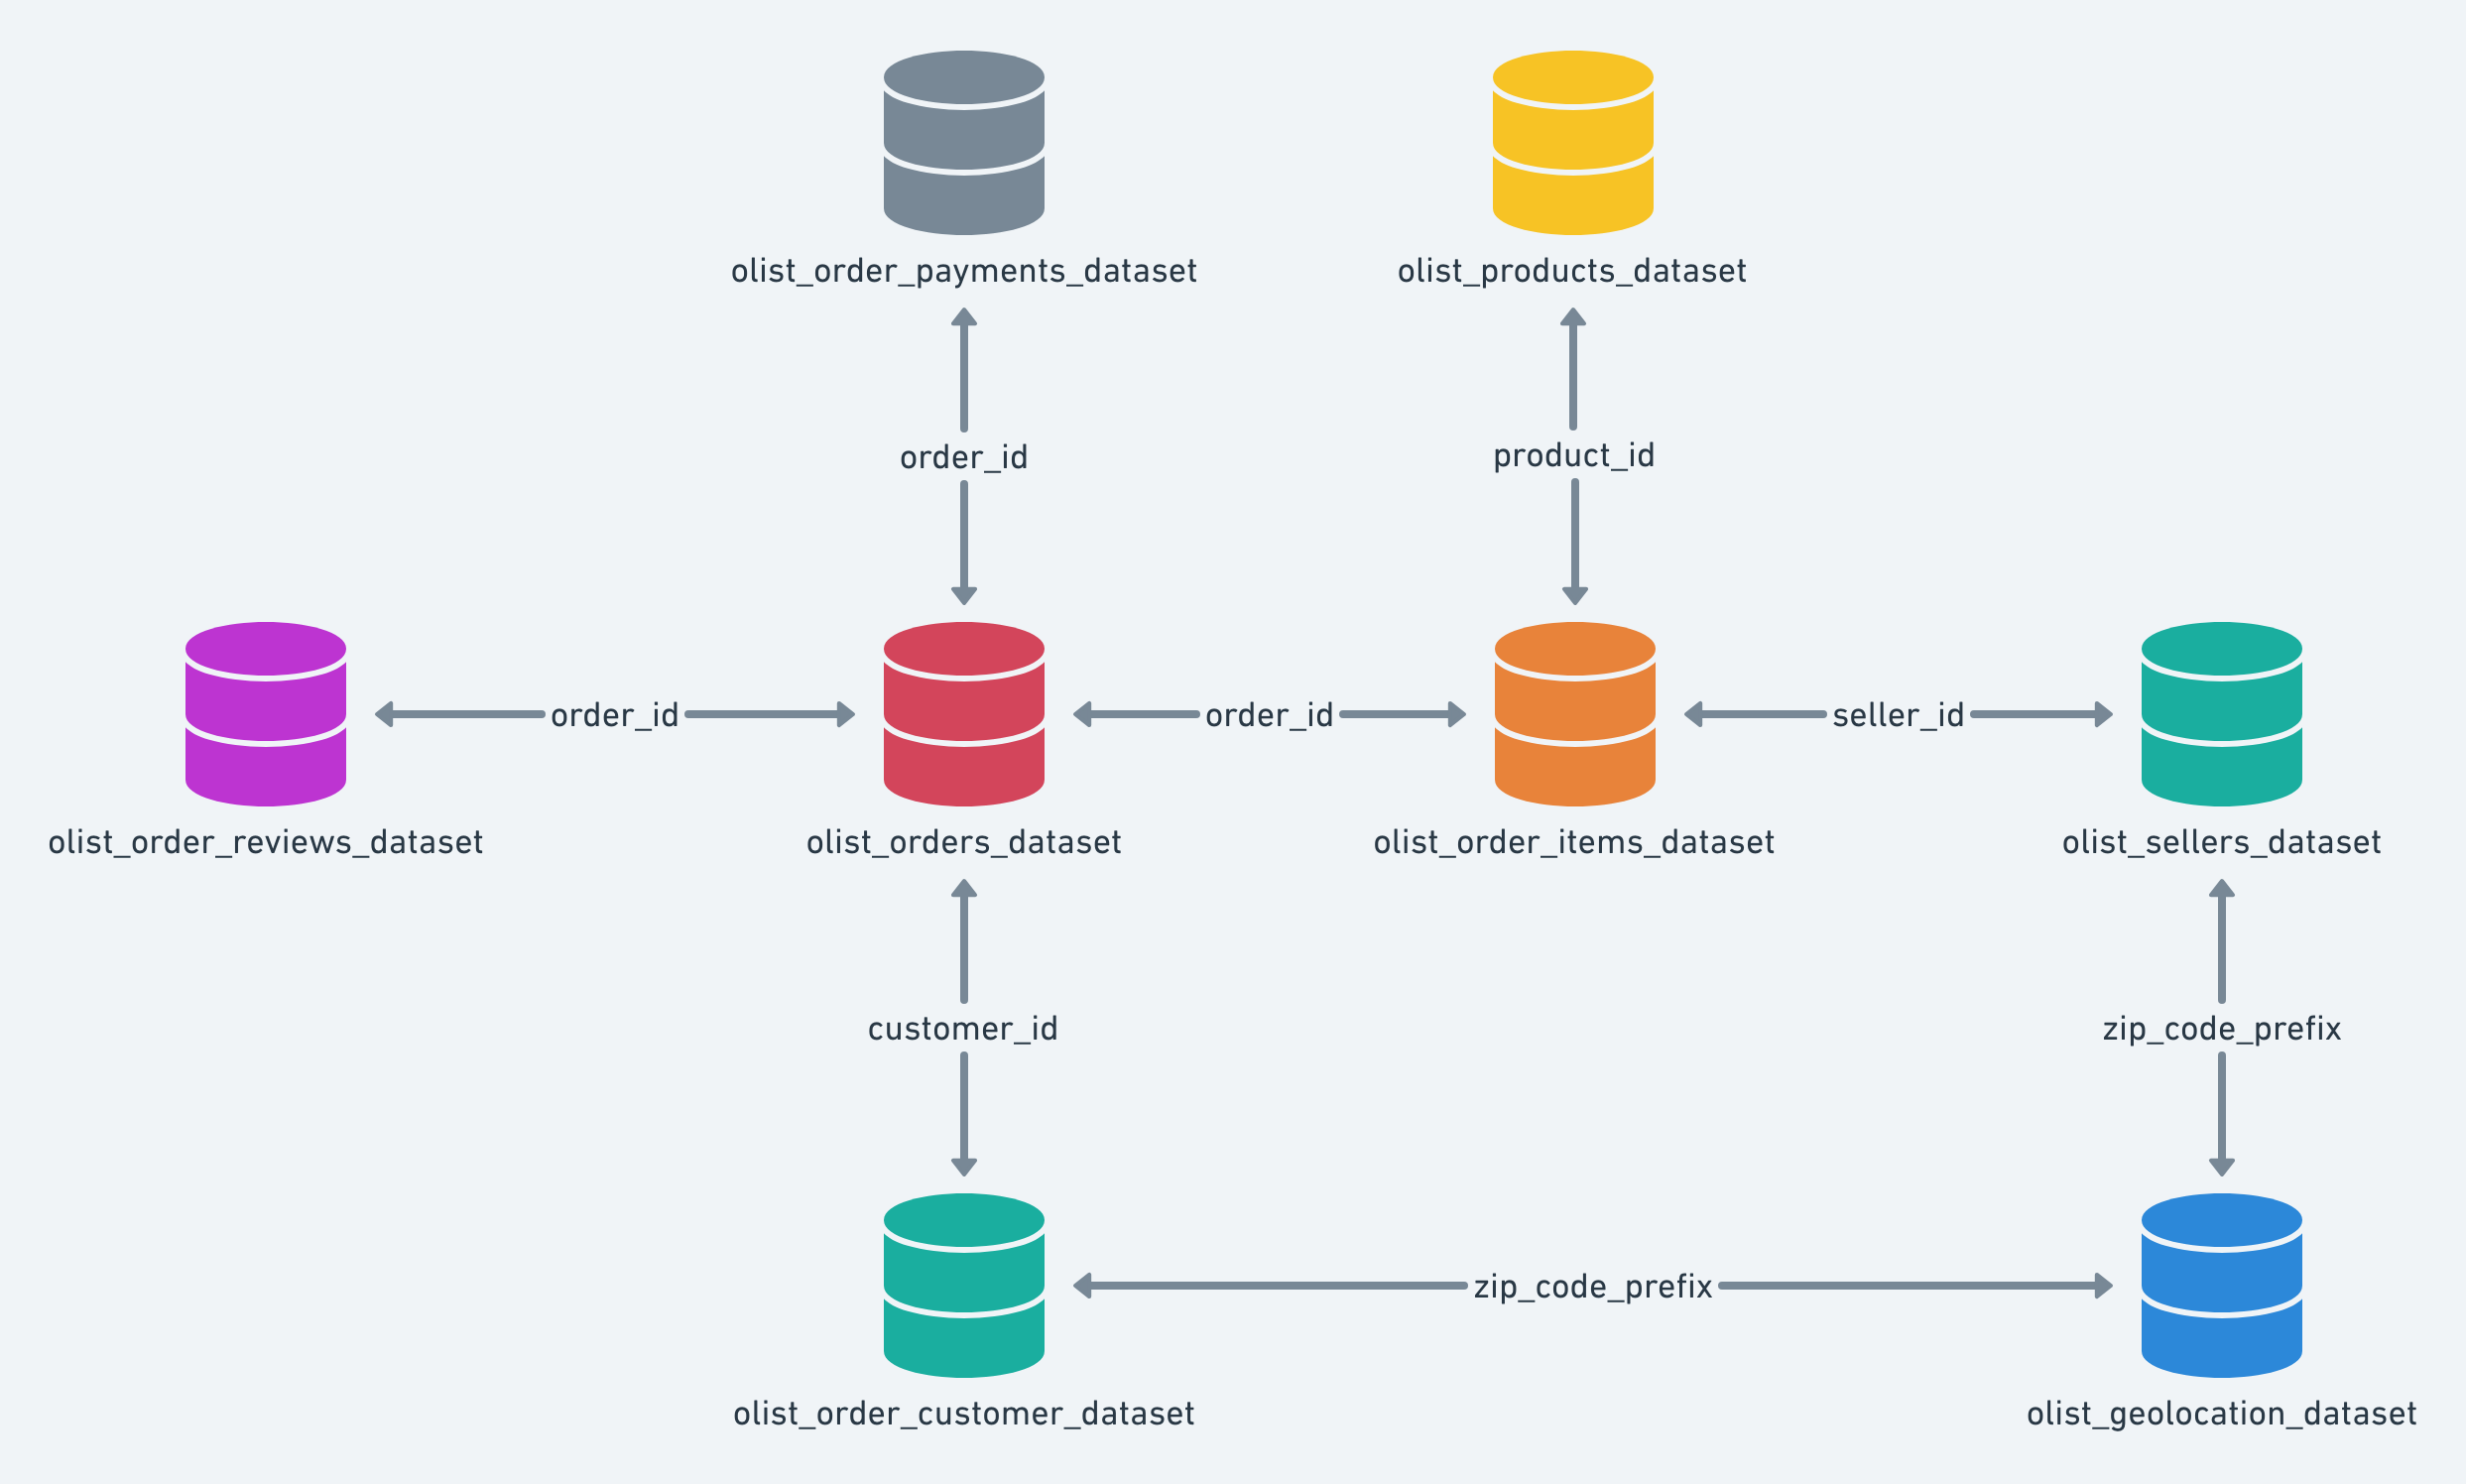
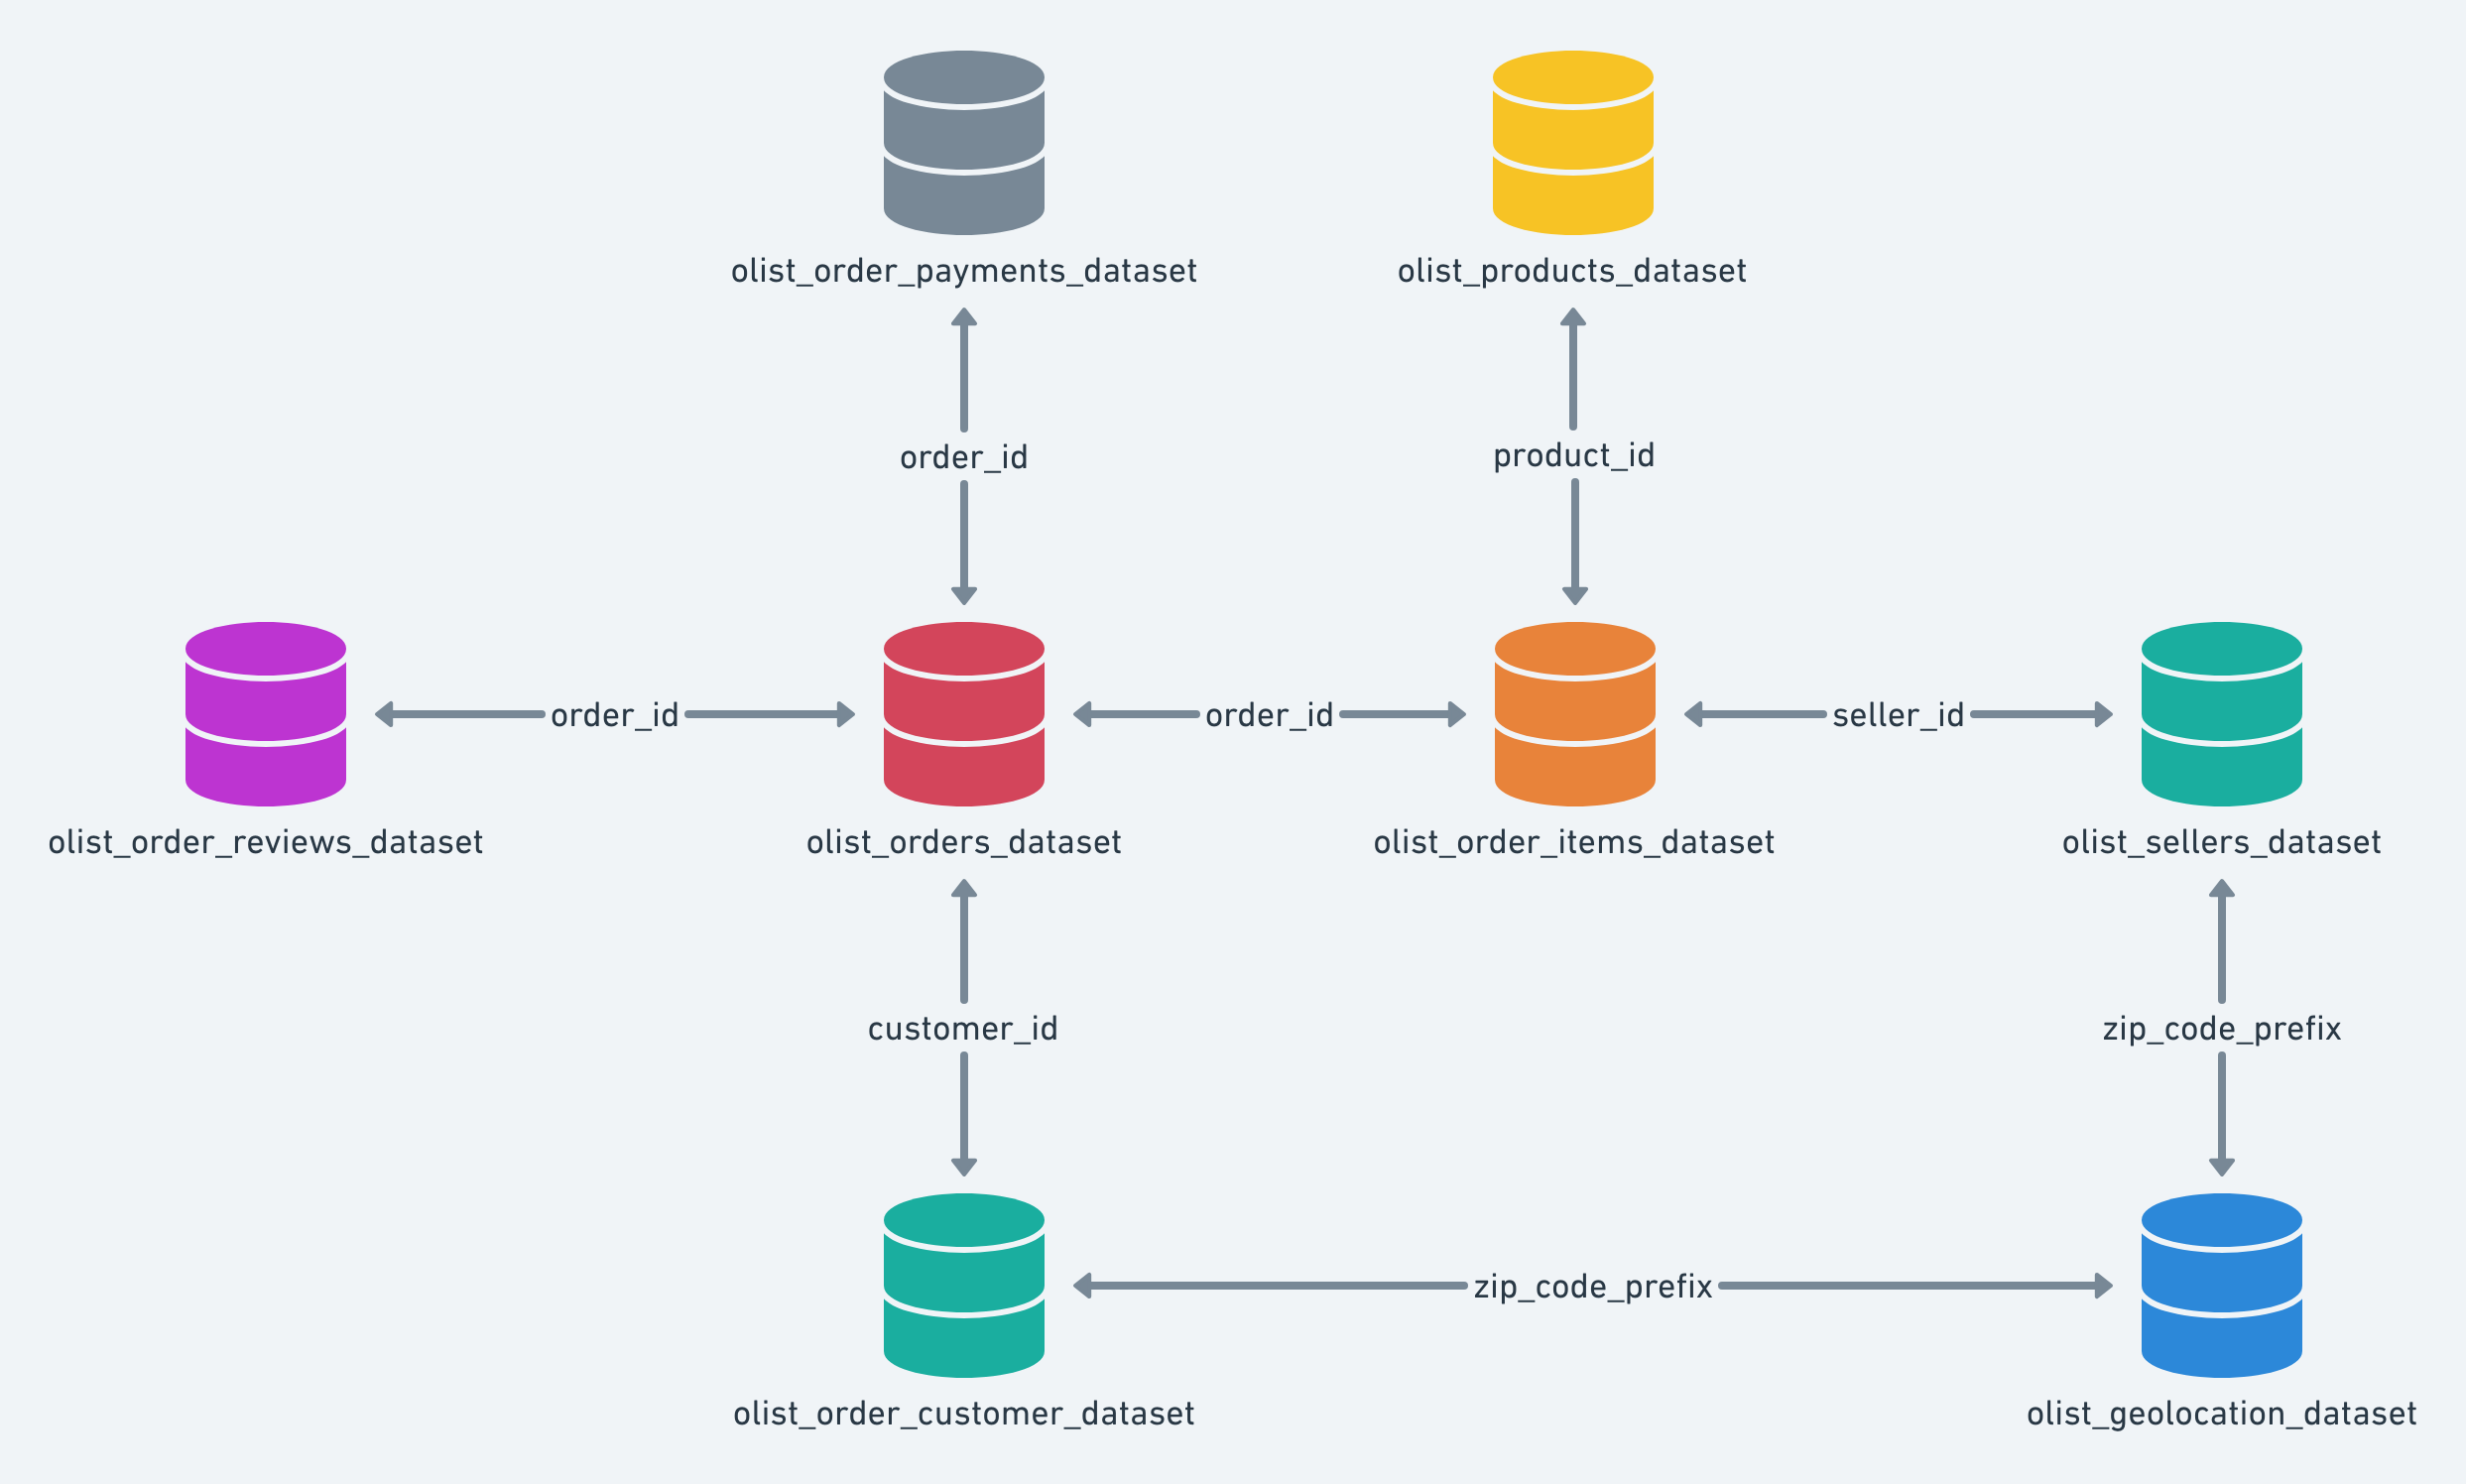

# Load Datasets

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False



In [64]:
print(sklearn.__version__)

1.2.2


In [65]:

import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'/kaggle/input/nanumgothic-font/NanumGothic-Regular.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)

plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'})

In [66]:
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# 범용 이상치 탐지 함수
def outlier_detection(df: pd.DataFrame, chi_q=0.999, iso_cont=0.1, final_threshold=2):
    if df.isna().values.any():
        print('결측치 확인. 처리후 재시도 하세요')
        return

    numeric_data = df.select_dtypes(include=['number'])
    if numeric_data.shape[1] == 0:
        print('❗ 수치형 변수가 없어 이상값 탐지를 수행할 수 없습니다.')
        return
    elif numeric_data.shape[1] == 1:
        print('⚠️ 수치형 변수가 1개뿐이라 마할라노비스 거리 계산은 건너뜁니다.')
        perform_mahal = False
    else:
        perform_mahal = True

    print('=== 종합 이상값 탐지 시스템 ===')
    df_copy = df.copy()

    # 1. 일변량 이상값 탐지 (IQR)
    print('1. 일변량 이상값 탐지 (IQR방법)')
    univariate_outliers = pd.DataFrame(index=df_copy.index)

    for col in numeric_data.columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_mask = (df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)
        univariate_outliers[col] = outliers_mask

        outlier_count = outliers_mask.sum()
        if outlier_count:
            print(f'  {col}: {outlier_count}개 ({outlier_count/len(df_copy) * 100:.1f}%)')

    # 2. 다변량 이상값 탐지 (마할라노비스 거리)
    print('\n2. 다변량 이상값 탐지 (마할라노비스 거리)')
    mahal_outliers = pd.Series([False]*len(df_copy), index=df_copy.index)  # 초기값 False

    if perform_mahal:
        scaler = StandardScaler()
        scaled_df = pd.DataFrame(
            scaler.fit_transform(numeric_data),
            columns=numeric_data.columns,
            index=numeric_data.index
        )
        mean = scaled_df.mean().values
        cov_matrix = np.cov(scaled_df, rowvar=False)
        inv_cov_matrix = np.linalg.pinv(cov_matrix)
        mahal_distance = scaled_df.apply(lambda row: distance.mahalanobis(row, mean, inv_cov_matrix), axis=1)

        threshold = chi2.ppf(chi_q, len(numeric_data.columns)) ** 0.5
        mahal_outliers = mahal_distance > threshold
        print(f'  임계값: {threshold:.2f}')
        print(f'  다변량 이상값: {mahal_outliers.sum()}개 ({mahal_outliers.mean()*100:.1f}%)')
    else:
        print('  마할라노비스 거리 이상값 탐지는 건너뜁니다.')

    # 3. 다변량 이상값 탐지 (Isolation Forest)
    print('\n3. 다변량 이상값 탐지 (Isolation Forest)')
    iso_forest = IsolationForest(contamination=iso_cont if iso_cont != 'auto' else 0.1, random_state=42)
    isolation_outliers = iso_forest.fit_predict(numeric_data if numeric_data.shape[1] > 0 else df_copy) == -1
    print(f'  Isolation Forest 이상값: {isolation_outliers.sum()}개 ({isolation_outliers.mean()*100:.1f}%)')

    # 5. 종합 판정
    outlier_summary = pd.DataFrame({
        '일변량': univariate_outliers.sum(axis=1) > 0,
        'Mahal Dist': mahal_outliers,
        'Iso Forest': isolation_outliers,
    })

    outlier_summary['총이상값수'] = outlier_summary.sum(axis=1)
    final_outliers = outlier_summary['총이상값수'] >= final_threshold
    print(f'\n == 최종 이상값: {final_outliers.sum()}개 ({final_outliers.mean()*100:.1f}%)')

    return outlier_summary, final_outliers



def analyze_missing_patterns(df: pd.DataFrame):
    """결측값 패턴 종합 분석"""
    print('=== 결측값 패턴 분석 ===')
    missing_info = df.isna().sum()
    missing_pct = (missing_info / len(df)) * 100
    missing_summary = pd.DataFrame({
        '결측수': missing_info,
        '결측률(%)': missing_pct.round(2)
    })
    missing_summary = missing_summary[missing_summary['결측수'] > 0].sort_values('결측수', ascending=False)
    print('변수별 결측 현황')
    display(missing_summary)

    # 결측값 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

    # 1. 결측값 히트맵
    sns.heatmap(df.isna(), yticklabels=False, cbar=True, cmap='viridis', ax=a1)
    a1.set_title('결측값 패턴 히트맵')

    # 2. 변수별 결측률 바 차트
    if len(missing_summary):  # missing_summary 가 비어있지 않으면
        missing_summary['결측률(%)'].plot(kind='bar', color='coral', ax=a2)
        a2.set_title('변수별 결측률')
        a2.set_ylabel('결측률(%)')
        a2.tick_params(axis='x', rotation=0)

    # 3. 결측값 조합 패턴
    missing_pattern = df[df.columns[df.isna().any()]].isna()
    if not missing_pattern.empty:
        pattern_series = missing_pattern.apply(lambda row: tuple(row), axis=1)
        pattern_counts = pattern_series.value_counts().head(10)
    
        if not pattern_counts.empty:
            pattern_counts.plot(kind='bar', color='lightblue', ax=a3)
            a3.set_title('결측 패턴 조합(상위10)')
            a3.set_ylabel('빈도')
            a3.tick_params(axis='x', rotation=45)
        else:
            a3.text(0.5, 0.5, '결측 패턴 없음', ha='center', va='center')
            a3.axis('off')
    else:
        a3.text(0.5, 0.5, '결측값 없음', ha='center', va='center')
        a3.axis('off')


    # 4. 결측 변수별 결측 여부(0/1)와 다른 수치형 변수 간 상관관계 히트맵 시각화
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    missing_cols = df.columns[df.isna().any()].tolist()

    if len(numeric_cols) > 0 and len(missing_cols) > 0:
        # 결측값을 0/1로 변환한 DataFrame 생성
        missing_binary = df[missing_cols].isna().astype(int)
        missing_binary.columns = [f'{col}_missing' for col in missing_binary.columns]
        
        # 수치형 변수와 결측 패턴 변수 결합
        corr_data = pd.concat([df[numeric_cols], missing_binary], axis=1)
        
        # 상관계수 계산
        correlation_matrix = corr_data.corr()
        
        # 결측 패턴 변수와 수치형 변수 간의 상관관계만 추출
        missing_numeric_corr = correlation_matrix.loc[
            missing_binary.columns, 
            numeric_cols
        ]
        
        # 상관관계가 있는 경우에만 히트맵 그리기
        if missing_numeric_corr.shape[0] > 0 and missing_numeric_corr.shape[1] > 0:
            sns.heatmap(missing_numeric_corr, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    fmt='.2f',
                    ax=a4,
                    cbar_kws={'label': '상관계수'})
            a4.set_title('결측 패턴과 수치형 변수 간 상관관계')
            a4.set_xlabel('수치형 변수')
            a4.set_ylabel('결측 패턴')
        else:
            a4.text(0.5, 0.5, '분석할 상관관계 없음', ha='center', va='center')
            a4.axis('off')
    else:
        a4.text(0.5, 0.5, '수치형 변수 또는\n결측값이 없음', ha='center', va='center')
        a4.axis('off')

    plt.tight_layout()
    plt.show()

    return missing_summary


def get_data_profile(df: pd.DataFrame):
    """종합적인 데이터 프로파일링 함수"""

    print('=' * 50)
    print('종합 데이터 품질 리포트')
    print('=' * 50)

    # 1. 기본 통계
    print(f'\n1. 기본정보')
    print(f'- 데이터 크기: {df.shape[0]}행 x {df.shape}열')
    print(f'- 메모리 사용량: {df.memory_usage(deep=True).sum()/1024**2:.2f}mb')
    print(f"- 수치형 변수: {len(df.select_dtypes(include=['number']).columns)}개")
    print(f"- 범주형 변수: {len(df.select_dtypes(include=['object']).columns)}개")

    # 2. 결측값 분석
    print(f'\n2. 결측값 분석')
    missing_info = df.isnull().sum()
    m_pct = (missing_info / len(df)) * 100
    if missing_info.sum() == 0:
        print('✅ 결측값 없음. 완전')
    else:
        print('⚠️')
        missing_sum = pd.DataFrame({
            '결측수': missing_info,
            '결측율(%)': m_pct,
        }).round(2)
        missing_sum = missing_sum[missing_sum['결측수'] > 0]
        display(missing_sum)

    # 3. 데이터 타입별 분석
    print(f'\n3. 수치형 변수 품질 분석')
    num_cols = df.select_dtypes(include=['number']).columns

    quality_report = []
    for col in num_cols:
        col_data = df[col].dropna()
        # 기본 통계
        stats = {
            '변수명': col,
            '평균': col_data.mean(),
            '표준편차': col_data.std(),
            '최솟값': col_data.min(),
            '최댓값': col_data.max(),
            '왜도': col_data.skew(),
            '첨도': col_data.kurtosis(),
        }

        # 이상값 비율 (IQR)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        mask = (col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)
        outliers = col_data[mask]
        stats['이상값비율(%)'] = (len(outliers) / len(col_data)) * 100

        # 유일값 비율
        stats['유일값비율(%)'] = (col_data.nunique() / len(col_data)) * 100

        quality_report.append(stats)

    quality_df = pd.DataFrame(quality_report).round(3)
    if quality_df.empty:
        print("❗ 수치형 변수가 없거나 분석할 데이터가 부족하여 품질 분석을 수행할 수 없습니다.")
        return quality_df

    display(quality_df)
    print(f'컬럼 목록: {quality_df.columns.tolist()}')

    # 4. 분포 이상 감지
    print(f'\n4. 분포 이상 감지')
    print(f'\n- 극심한 왜도 (|skewness|>2)')
    
    if '왜도' not in quality_df.columns:
        print("❗ '왜도' 컬럼이 없어 분포 이상 감지를 수행할 수 없습니다.")
    else:
        high_skews = quality_df[abs(quality_df['왜도']) > 2]['변수명'].tolist()
        if high_skews:  # high_skews 리스트가 값이 있으면,
            print('⚠️ 극심한 왜도 변수 발견:')
            for var in high_skews:
                skew_val = quality_df[quality_df['변수명'] == var].iloc[0]['왜도']
                print(f'-- {var}: 왜도 = {skew_val:.3f}')
        else:
            print('-- ✅ 정상 범위 내 분포')

    print('\n- 높은 이상값 비율(>5%)')
    high_outliers = quality_df[quality_df['이상값비율(%)'] > 5]['변수명'].tolist()
    if high_outliers:
        print('⚠️ 이상값 비율이 높은 변수 발견:')
        for var in high_outliers:
            outlier_pct = quality_df[quality_df['변수명'] == var].iloc[0]['이상값비율(%)']
            print(f'-- {var}: 이상값 {outlier_pct:.1f}%')
    else:
        print('-- ✅ 이상값 비율 양호')

    return quality_df


In [67]:
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv', dtype={'order_status': 'category'}
                , parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv'
                , parse_dates=['review_creation_date', 'review_answer_timestamp']
                )
items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv'
                , parse_dates=['shipping_limit_date'])
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv', dtype={'product_category_name': 'category'})
sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv', dtype={'seller_city': 'category', 'seller_state': 'category'})
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv', dtype={'customer_city': 'category', 'customer_state': 'category'})
category_translation = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv', dtype={'product_category_name': 'category', 'product_category_name_english': 'category'})
geolocations = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv', dtype={'geolocation_city': 'category', 'geolocation_state': 'category'})

In [68]:
class Dfs:
    def __init__(self):
        self.orders = orders
        self.items = items
        self.reviews = reviews
        self.products = products
        self.geolocations = geolocations
        self.sellers = sellers
        self.payments = payments
        self.customers = customers
        self.category_translation = category_translation

    def __iter__(self):
        return iter([
            ('orders', self.orders),
            ('items', self.items),
            ('reviews', self.reviews),
            ('products', self.products),
            ('geolocations', self.geolocations),
            ('sellers', self.sellers),
            ('payments', self.payments),
            ('customers', self.customers),
            ('category_translation', self.category_translation),
        ])
dfs = Dfs()

In [69]:
for key, df in dfs:
    datetime_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
    for col in datetime_cols:
        min_date = df[col].min()
        max_date = df[col].max()    
        print(f"[{min_date.date()} - {max_date.date()}] DataFrame '{key}', Column '{col}':")

[2016-09-04 - 2018-10-17] DataFrame 'orders', Column 'order_purchase_timestamp':
[2016-09-15 - 2018-09-03] DataFrame 'orders', Column 'order_approved_at':
[2016-10-08 - 2018-09-11] DataFrame 'orders', Column 'order_delivered_carrier_date':
[2016-10-11 - 2018-10-17] DataFrame 'orders', Column 'order_delivered_customer_date':
[2016-09-30 - 2018-11-12] DataFrame 'orders', Column 'order_estimated_delivery_date':
[2016-09-19 - 2020-04-09] DataFrame 'items', Column 'shipping_limit_date':
[2016-10-02 - 2018-08-31] DataFrame 'reviews', Column 'review_creation_date':
[2016-10-07 - 2018-10-29] DataFrame 'reviews', Column 'review_answer_timestamp':


In [70]:
for key, df in dfs:
    print(f"DataFrame '{key}': {df.shape} \n\n{df.isnull().sum()} \n")

DataFrame 'orders': (99441, 8) 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64 

DataFrame 'items': (112650, 7) 

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64 

DataFrame 'reviews': (99224, 7) 

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64 

DataFrame 'products': (32951, 9) 

product_id                      0
product_category_name         610
product_name_lenght           610
product_

In [71]:
for key, df in dfs:
    print(f"DataFrame '{key}': {df.shape} \n\n{df.duplicated().sum()} \n")

DataFrame 'orders': (99441, 8) 

0 

DataFrame 'items': (112650, 7) 

0 

DataFrame 'reviews': (99224, 7) 

0 

DataFrame 'products': (32951, 9) 

0 

DataFrame 'geolocations': (1000163, 5) 

261831 

DataFrame 'sellers': (3095, 4) 

0 

DataFrame 'payments': (103886, 5) 

0 

DataFrame 'customers': (99441, 5) 

0 

DataFrame 'category_translation': (71, 2) 

0 



In [72]:
for key, df in dfs:
    print(f"DataFrame '{key}': {df.shape} \n\n{get_data_profile(df)} \n")

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 99441행 x (99441, 8)열
- 메모리 사용량: 20.77mb
- 수치형 변수: 0개
- 범주형 변수: 2개

2. 결측값 분석
⚠️


,결측수,결측율(%)
order_approved_at,160,0.16
order_delivered_carrier_date,1783,1.79
order_delivered_customer_date,2965,2.98



3. 수치형 변수 품질 분석
❗ 수치형 변수가 없거나 분석할 데이터가 부족하여 품질 분석을 수행할 수 없습니다.
DataFrame 'orders': (99441, 8) 

Empty DataFrame
Columns: []
Index: [] 

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 112650행 x (112650, 7)열
- 메모리 사용량: 32.12mb
- 수치형 변수: 3개
- 범주형 변수: 3개

2. 결측값 분석
✅ 결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,order_item_id,1.198,0.705,1.00,21.00,7.580,103.857,12.414,0.019
1,price,120.654,183.634,0.85,6735.00,7.923,120.828,7.481,5.298
2,freight_value,19.990,15.806,0.00,409.68,5.640,59.788,10.771,6.213


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️ 극심한 왜도 변수 발견:
-- order_item_id: 왜도 = 7.580
-- price: 왜도 = 7.923
-- freight_value: 왜도 = 5.640

- 높은 이상값 비율(>5%)
⚠️ 이상값 비율이 높은 변수 발견:
-- order_item_id: 이상값 12.4%
-- price: 이상값 7.5%
-- freight_value: 이상값 10.8%
DataFrame 'items': (112650, 7) 

             변수명       평균     표준편차   최솟값      최댓값     왜도       첨도  이상값비율(%)  \
0  order_item_id    1.198    0.705  1.00    21.00  7.580  103.857    12.414   
1          price  120.654  183.634  0.85  6735.00  7.923  120.828     7.481   
2  freight_value   19.990   15.806  0.00   409.68  5.640   59.788    10.771   

   유일값비율(%)  
0     0.019  
1     5.298  
2     6.213   

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 99224행 x (99224, 7)열
- 메모리 사용량: 29.88mb
- 수치형 변수: 1개
- 범주형 변수: 4개

2. 결측값 분석
⚠️


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,review_score,4.086,1.348,1,5,-1.364,0.508,14.689,0.005


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
-- ✅ 정상 범위 내 분포

- 높은 이상값 비율(>5%)
⚠️ 이상값 비율이 높은 변수 발견:
-- review_score: 이상값 14.7%
DataFrame 'reviews': (99224, 7) 

            변수명     평균   표준편차  최솟값  최댓값     왜도     첨도  이상값비율(%)  유일값비율(%)
0  review_score  4.086  1.348    1    5 -1.364  0.508    14.689     0.005 

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 32951행 x (32951, 9)열
- 메모리 사용량: 4.60mb
- 수치형 변수: 7개
- 범주형 변수: 1개

2. 결측값 분석
⚠️


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,product_name_lenght,48.477,10.246,5.0,76.0,-0.903,0.193,0.897,0.204
1,product_description_lenght,771.495,635.115,4.0,3992.0,1.962,4.829,6.425,9.152
2,product_photos_qty,2.189,1.737,1.0,20.0,2.193,7.264,2.625,0.059
3,product_weight_g,2276.472,4282.039,0.0,40425.0,3.605,15.134,13.812,6.689
4,product_length_cm,30.815,16.914,7.0,105.0,1.750,3.514,4.188,0.300
5,product_height_cm,16.938,13.638,2.0,105.0,2.140,6.679,5.742,0.310
6,product_width_cm,23.197,12.079,6.0,118.0,1.671,4.073,2.768,0.288


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️ 극심한 왜도 변수 발견:
-- product_photos_qty: 왜도 = 2.193
-- product_weight_g: 왜도 = 3.605
-- product_height_cm: 왜도 = 2.140

- 높은 이상값 비율(>5%)
⚠️ 이상값 비율이 높은 변수 발견:
-- product_description_lenght: 이상값 6.4%
-- product_weight_g: 이상값 13.8%
-- product_height_cm: 이상값 5.7%
DataFrame 'products': (32951, 9) 

                          변수명        평균      표준편차  최솟값      최댓값     왜도  \
0         product_name_lenght    48.477    10.246  5.0     76.0 -0.903   
1  product_description_lenght   771.495   635.115  4.0   3992.0  1.962   
2          product_photos_qty     2.189     1.737  1.0     20.0  2.193   
3            product_weight_g  2276.472  4282.039  0.0  40425.0  3.605   
4           product_length_cm    30.815    16.914  7.0    105.0  1.750   
5           product_height_cm    16.938    13.638  2.0    105.0  2.140   
6            product_width_cm    23.197    12.079  6.0    118.0  1.671   

,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,geolocation_zip_code_prefix,36574.166,30549.336,1001.000,99990.000,0.694,-0.941,0.000,1.901
1,geolocation_lat,-21.176,5.716,-36.605,45.066,1.565,2.850,16.821,71.724
2,geolocation_lng,-46.391,4.270,-101.467,121.105,-0.102,4.727,4.234,71.750


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
-- ✅ 정상 범위 내 분포

- 높은 이상값 비율(>5%)
⚠️ 이상값 비율이 높은 변수 발견:
-- geolocation_lat: 이상값 16.8%
DataFrame 'geolocations': (1000163, 5) 

                           변수명         평균       표준편차       최솟값        최댓값  \
0  geolocation_zip_code_prefix  36574.166  30549.336  1001.000  99990.000   
1              geolocation_lat    -21.176      5.716   -36.605     45.066   
2              geolocation_lng    -46.391      4.270  -101.467    121.105   

      왜도     첨도  이상값비율(%)  유일값비율(%)  
0  0.694 -0.941     0.000     1.901  
1  1.565  2.850    16.821    71.724  
2 -0.102  4.727     4.234    71.750   

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 3095행 x (3095, 4)열
- 메모리 사용량: 0.35mb
- 수치형 변수: 1개
- 범주형 변수: 1개

2. 결측값 분석
✅ 결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,seller_zip_code_prefix,32291.059,32713.454,1001,99730,0.916,-0.858,0.0,72.569


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
-- ✅ 정상 범위 내 분포

- 높은 이상값 비율(>5%)
-- ✅ 이상값 비율 양호
DataFrame 'sellers': (3095, 4) 

                      변수명         평균       표준편차   최솟값    최댓값     왜도     첨도  \
0  seller_zip_code_prefix  32291.059  32713.454  1001  99730  0.916 -0.858   

   이상값비율(%)  유일값비율(%)  
0       0.0    72.569   

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 103886행 x (103886, 5)열
- 메모리 사용량: 17.81mb
- 수치형 변수: 3개
- 범주형 변수: 2개

2. 결측값 분석
✅ 결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,payment_sequential,1.093,0.707,1.0,29.00,16.180,370.594,4.357,0.028
1,payment_installments,2.853,2.687,0.0,24.00,1.655,2.550,6.077,0.023
2,payment_value,154.100,217.494,0.0,13664.08,9.254,241.828,7.682,27.989


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️ 극심한 왜도 변수 발견:
-- payment_sequential: 왜도 = 16.180
-- payment_value: 왜도 = 9.254

- 높은 이상값 비율(>5%)
⚠️ 이상값 비율이 높은 변수 발견:
-- payment_installments: 이상값 6.1%
-- payment_value: 이상값 7.7%
DataFrame 'payments': (103886, 5) 

                    변수명       평균     표준편차  최솟값       최댓값      왜도       첨도  \
0    payment_sequential    1.093    0.707  1.0     29.00  16.180  370.594   
1  payment_installments    2.853    2.687  0.0     24.00   1.655    2.550   
2         payment_value  154.100  217.494  0.0  13664.08   9.254  241.828   

   이상값비율(%)  유일값비율(%)  
0     4.357     0.028  
1     6.077     0.023  
2     7.682    27.989   

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 99441행 x (99441, 5)열
- 메모리 사용량: 18.32mb
- 수치형 변수: 1개
- 범주형 변수: 2개

2. 결측값 분석
✅ 결측값 없음. 완전

3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,customer_zip_code_prefix,35137.475,29797.939,1003,99990,0.779,-0.788,0.0,15.078


컬럼 목록: ['변수명', '평균', '표준편차', '최솟값', '최댓값', '왜도', '첨도', '이상값비율(%)', '유일값비율(%)']

4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
-- ✅ 정상 범위 내 분포

- 높은 이상값 비율(>5%)
-- ✅ 이상값 비율 양호
DataFrame 'customers': (99441, 5) 

                        변수명         평균       표준편차   최솟값    최댓값     왜도     첨도  \
0  customer_zip_code_prefix  35137.475  29797.939  1003  99990  0.779 -0.788   

   이상값비율(%)  유일값비율(%)  
0       0.0    15.078   

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 71행 x (71, 2)열
- 메모리 사용량: 0.01mb
- 수치형 변수: 0개
- 범주형 변수: 0개

2. 결측값 분석
✅ 결측값 없음. 완전

3. 수치형 변수 품질 분석
❗ 수치형 변수가 없거나 분석할 데이터가 부족하여 품질 분석을 수행할 수 없습니다.
DataFrame 'category_translation': (71, 2) 

Empty DataFrame
Columns: []
Index: [] 



=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
order_delivered_customer_date,2965,2.98
order_delivered_carrier_date,1783,1.79
order_approved_at,160,0.16


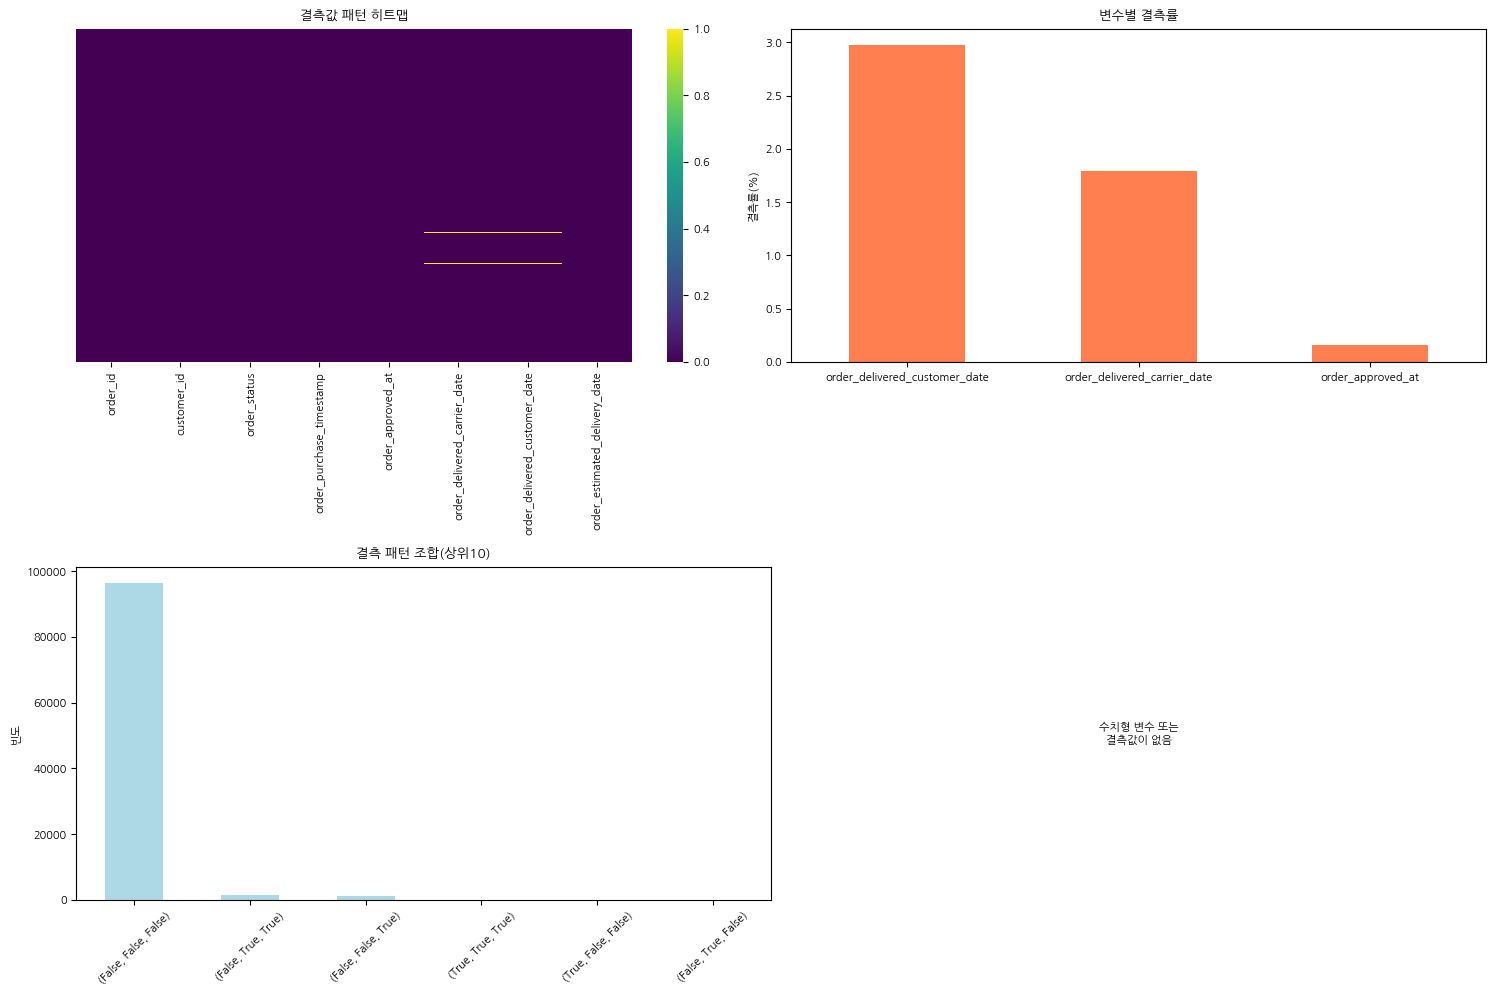

DataFrame 'orders': (99441, 8) 

                                결측수  결측률(%)
order_delivered_customer_date  2965    2.98
order_delivered_carrier_date   1783    1.79
order_approved_at               160    0.16 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


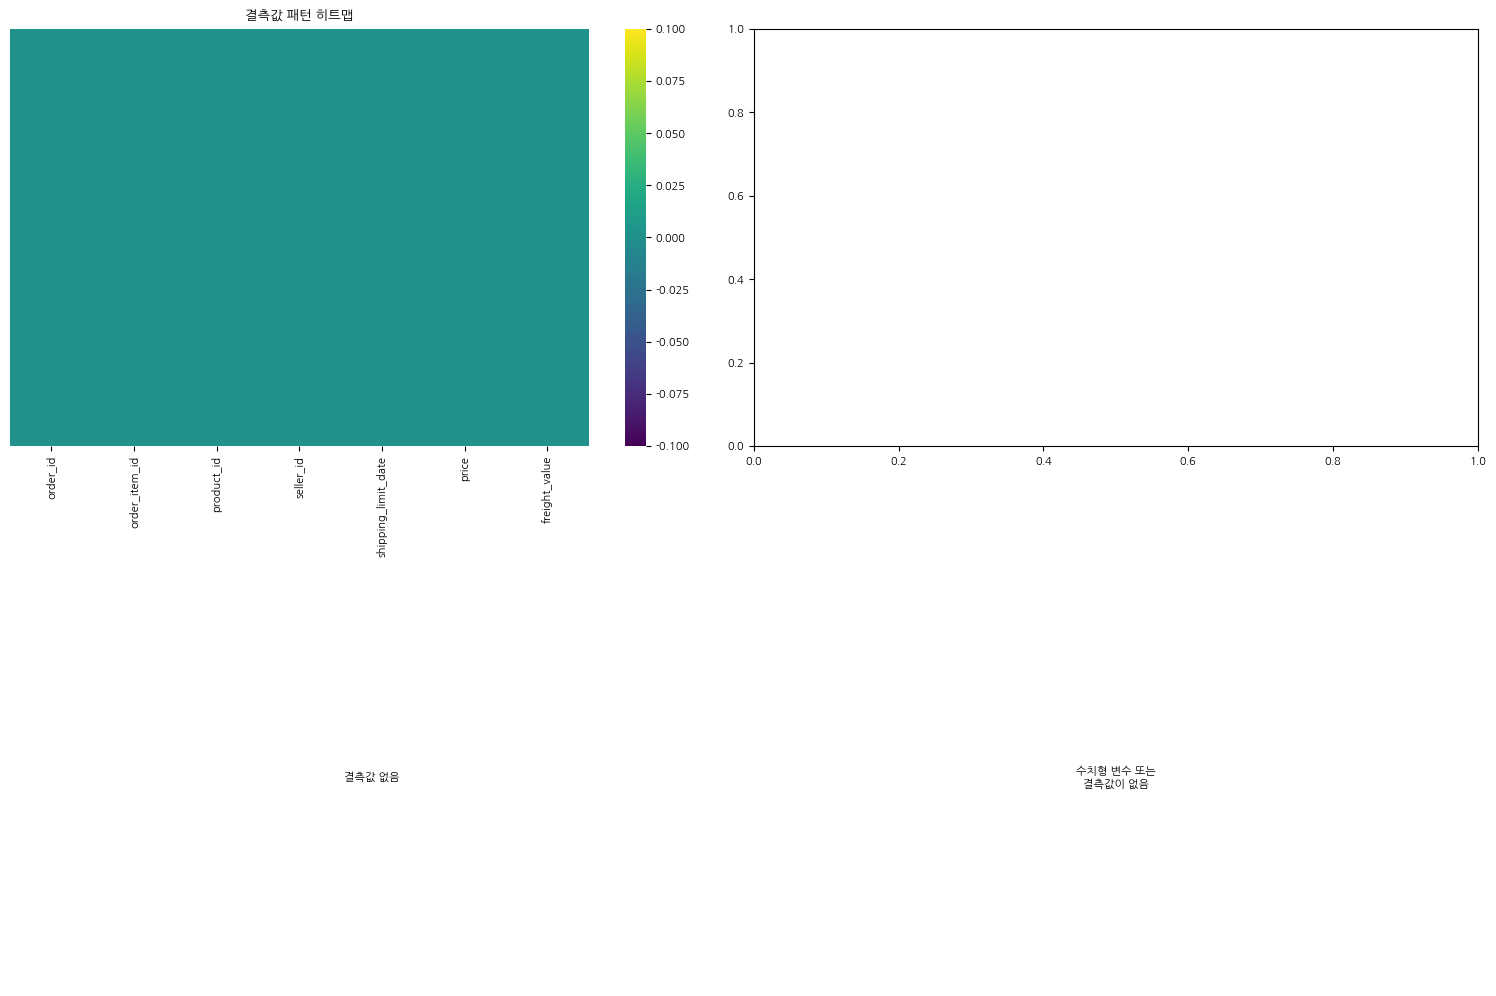

DataFrame 'items': (112650, 7) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


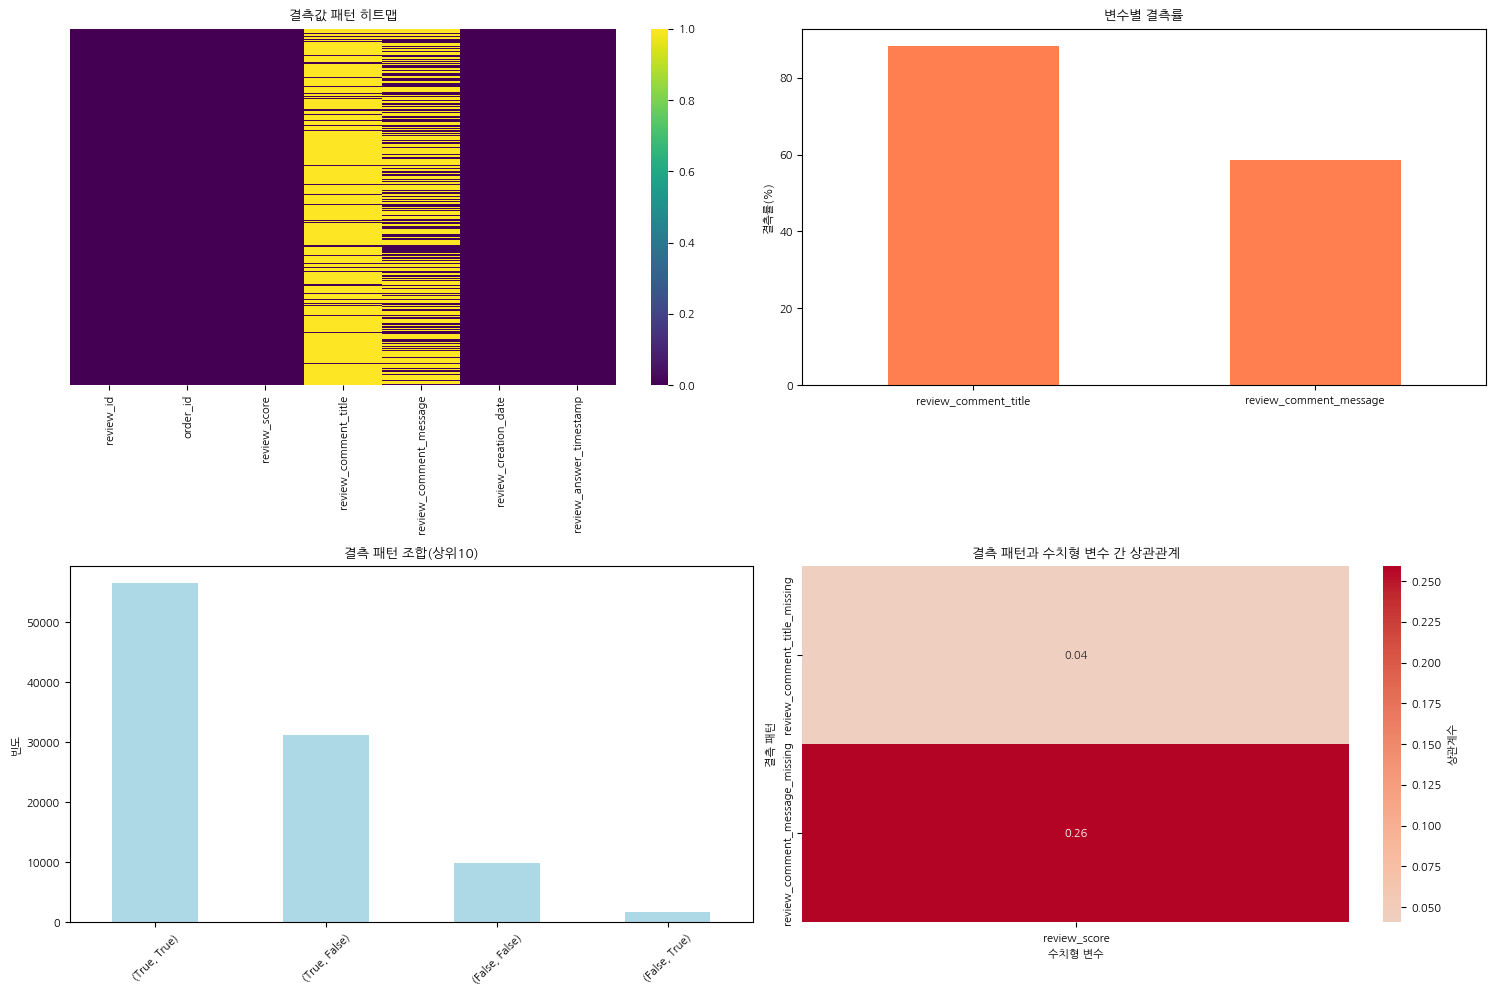

DataFrame 'reviews': (99224, 7) 

                          결측수  결측률(%)
review_comment_title    87656   88.34
review_comment_message  58247   58.70 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


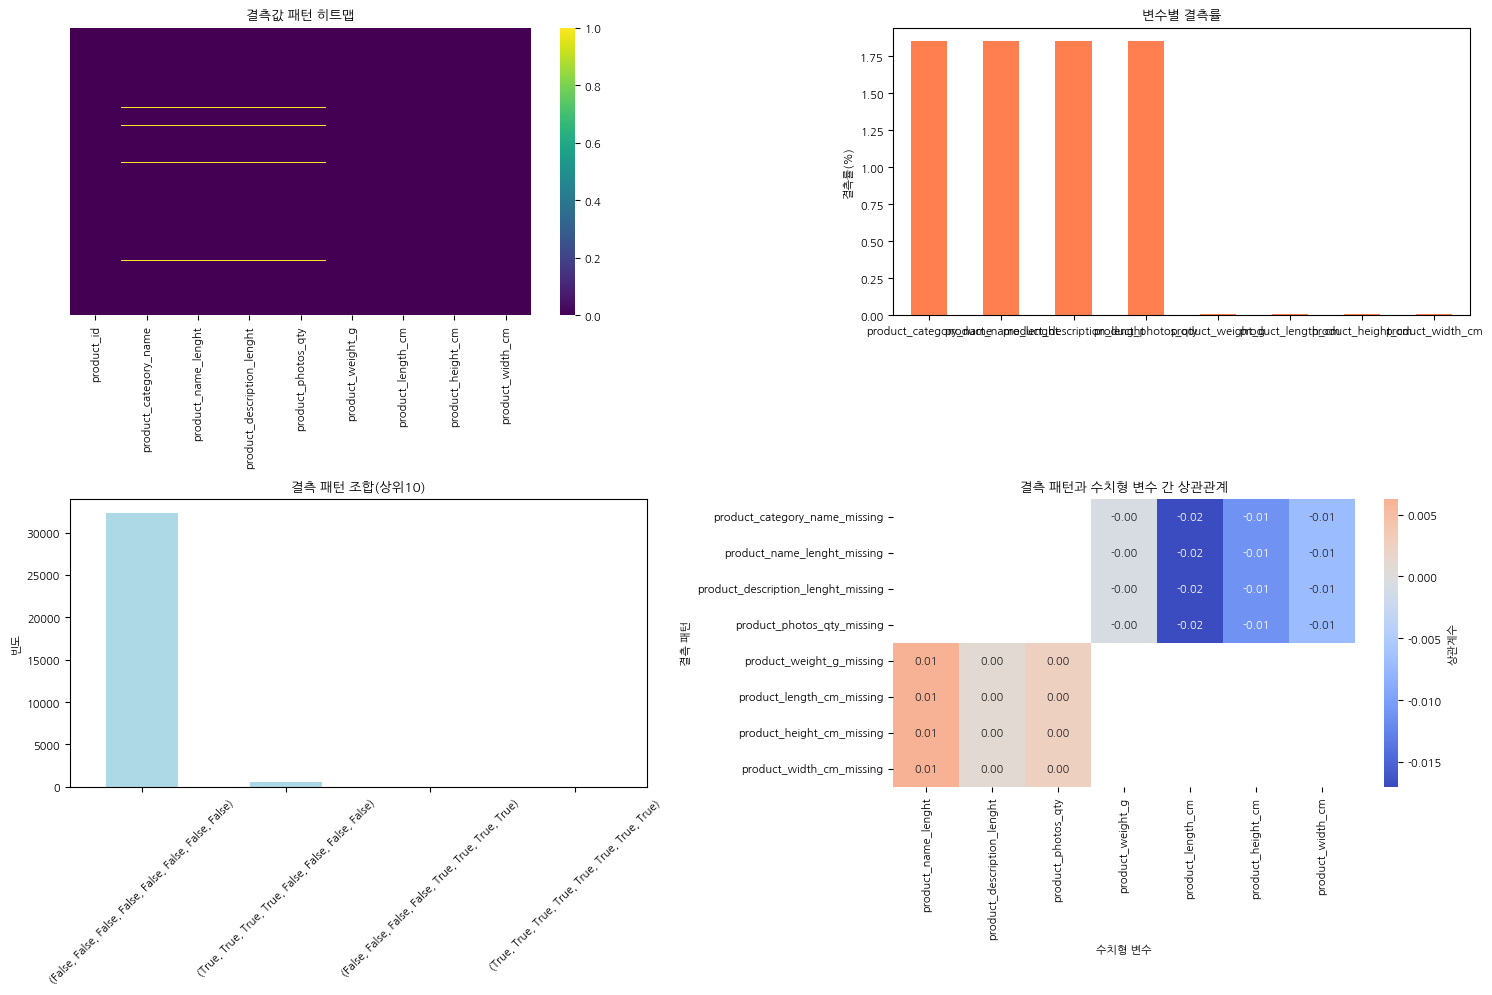

DataFrame 'products': (32951, 9) 

                            결측수  결측률(%)
product_category_name       610    1.85
product_name_lenght         610    1.85
product_description_lenght  610    1.85
product_photos_qty          610    1.85
product_weight_g              2    0.01
product_length_cm             2    0.01
product_height_cm             2    0.01
product_width_cm              2    0.01 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


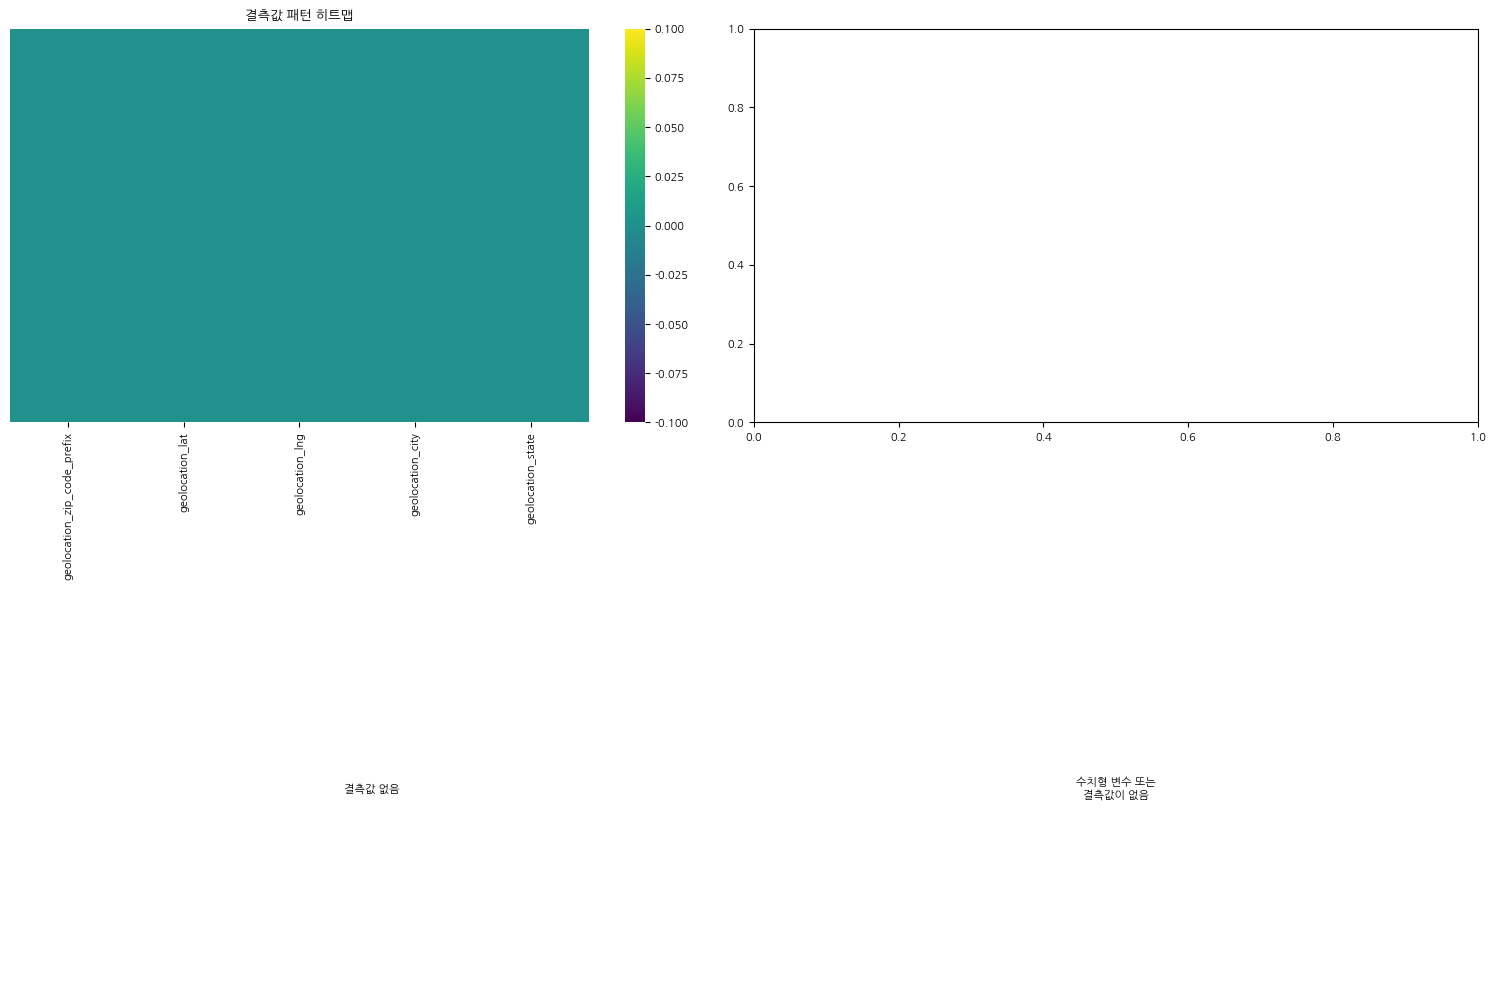

DataFrame 'geolocations': (1000163, 5) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


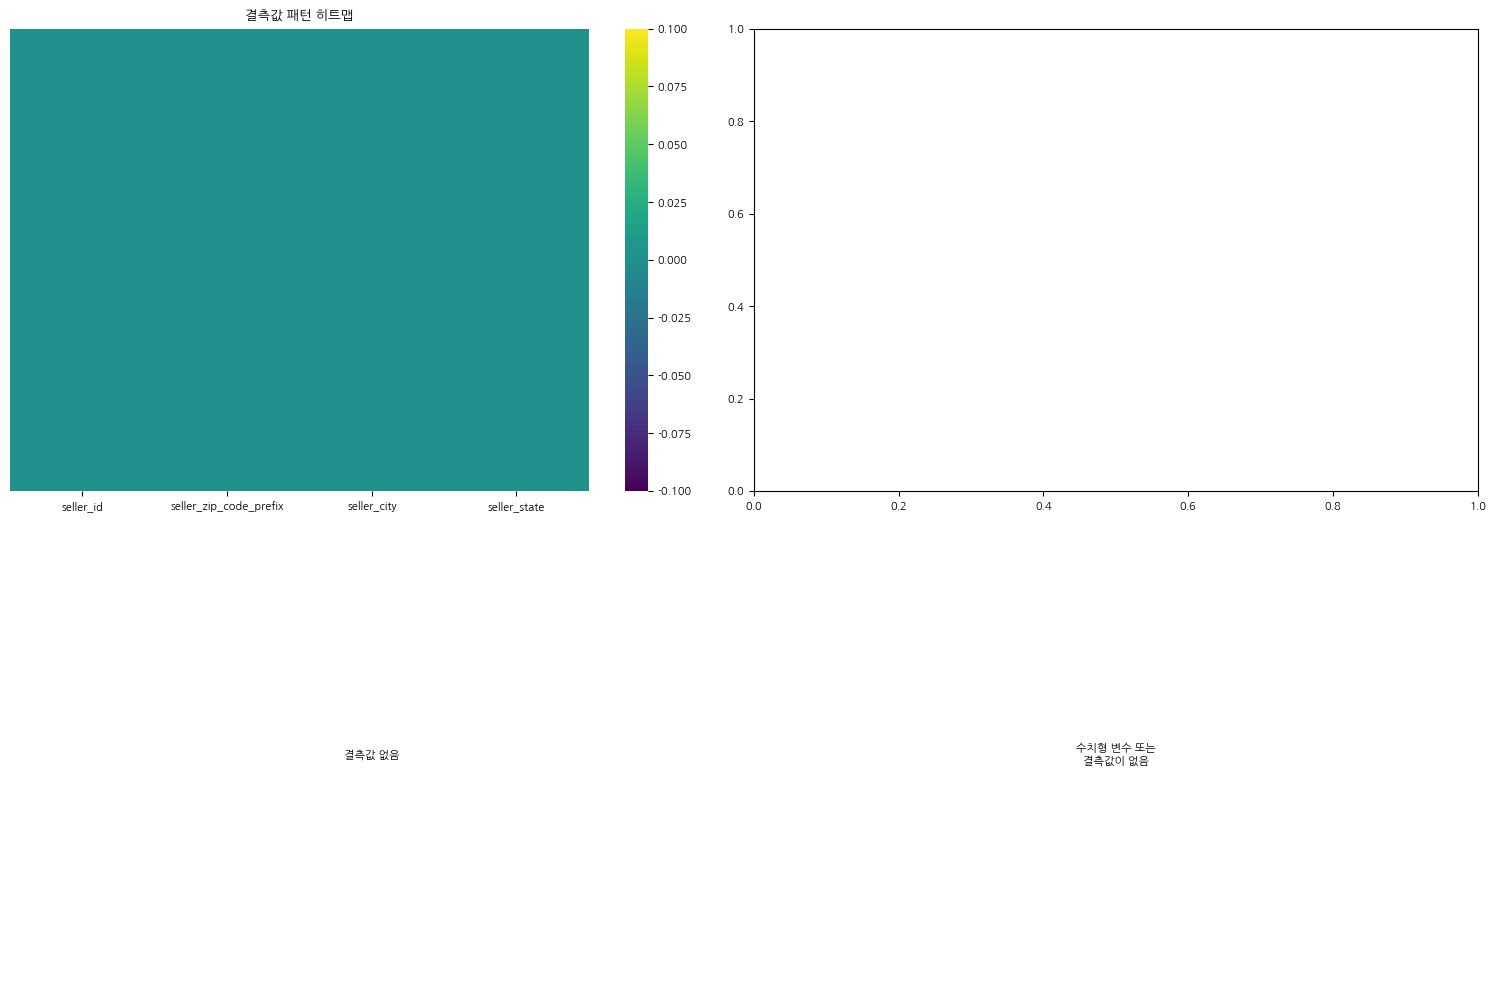

DataFrame 'sellers': (3095, 4) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


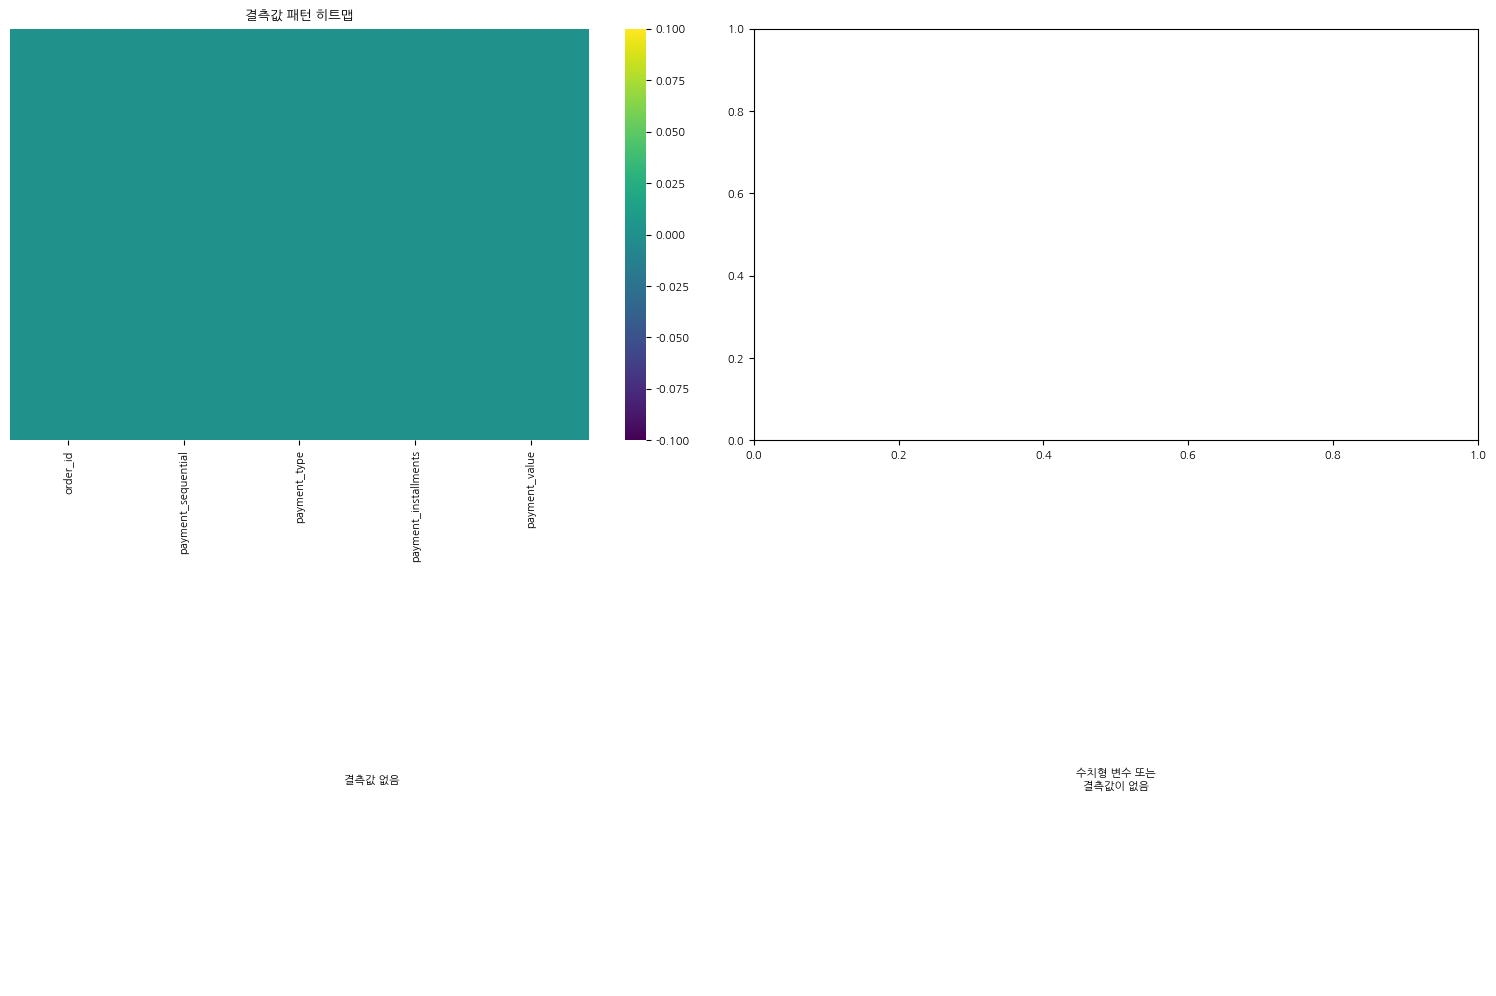

DataFrame 'payments': (103886, 5) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


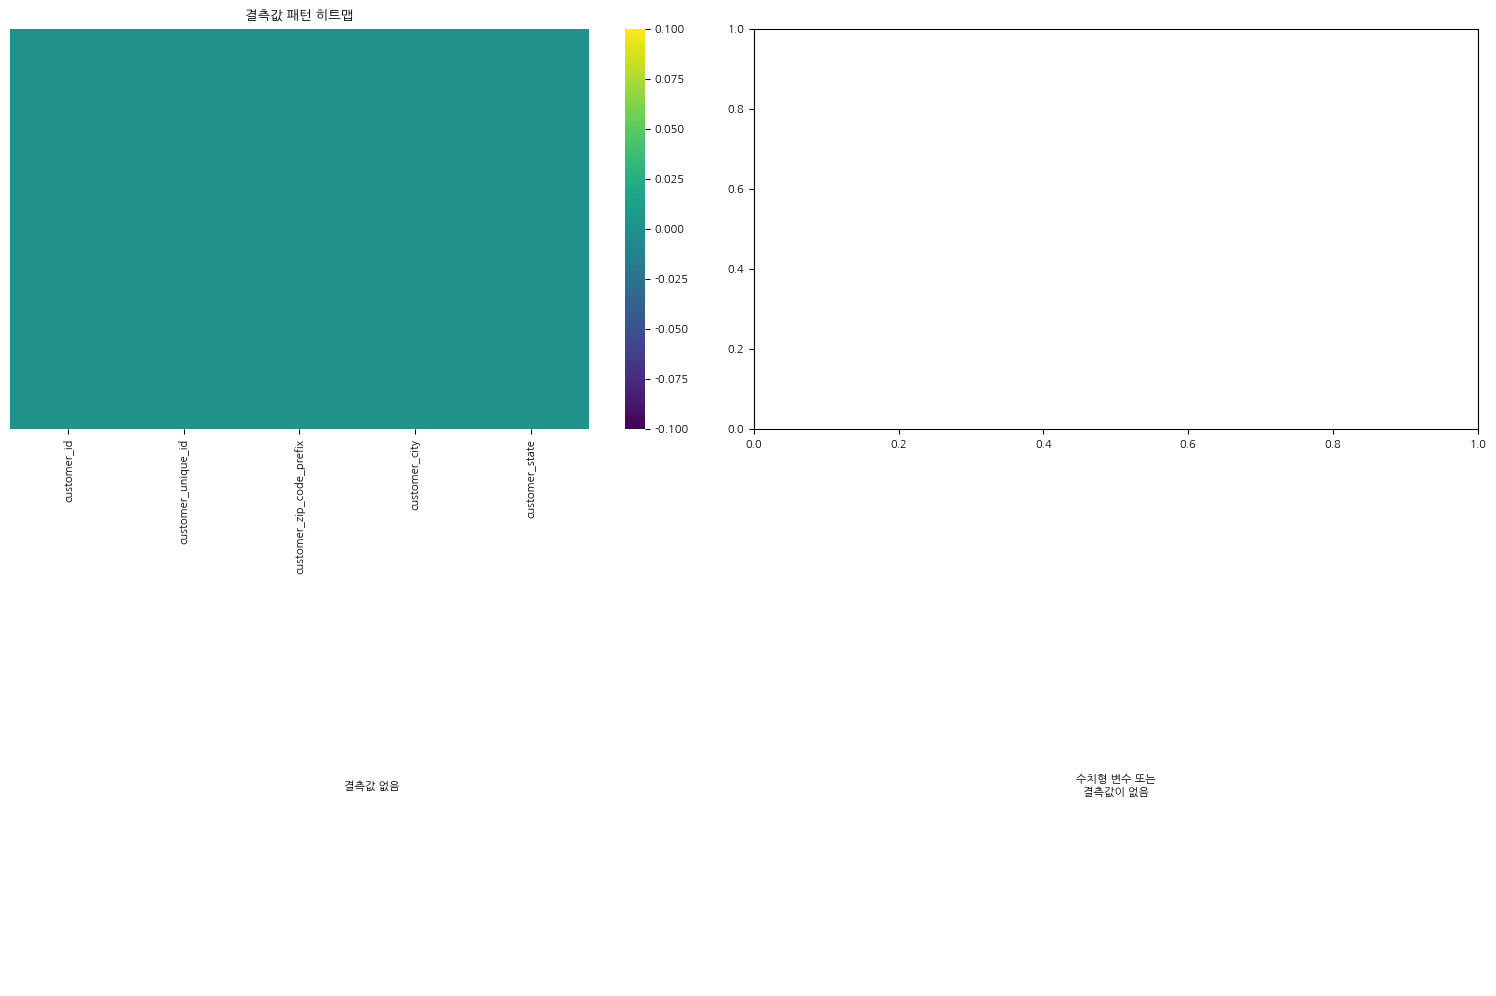

DataFrame 'customers': (99441, 5) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)


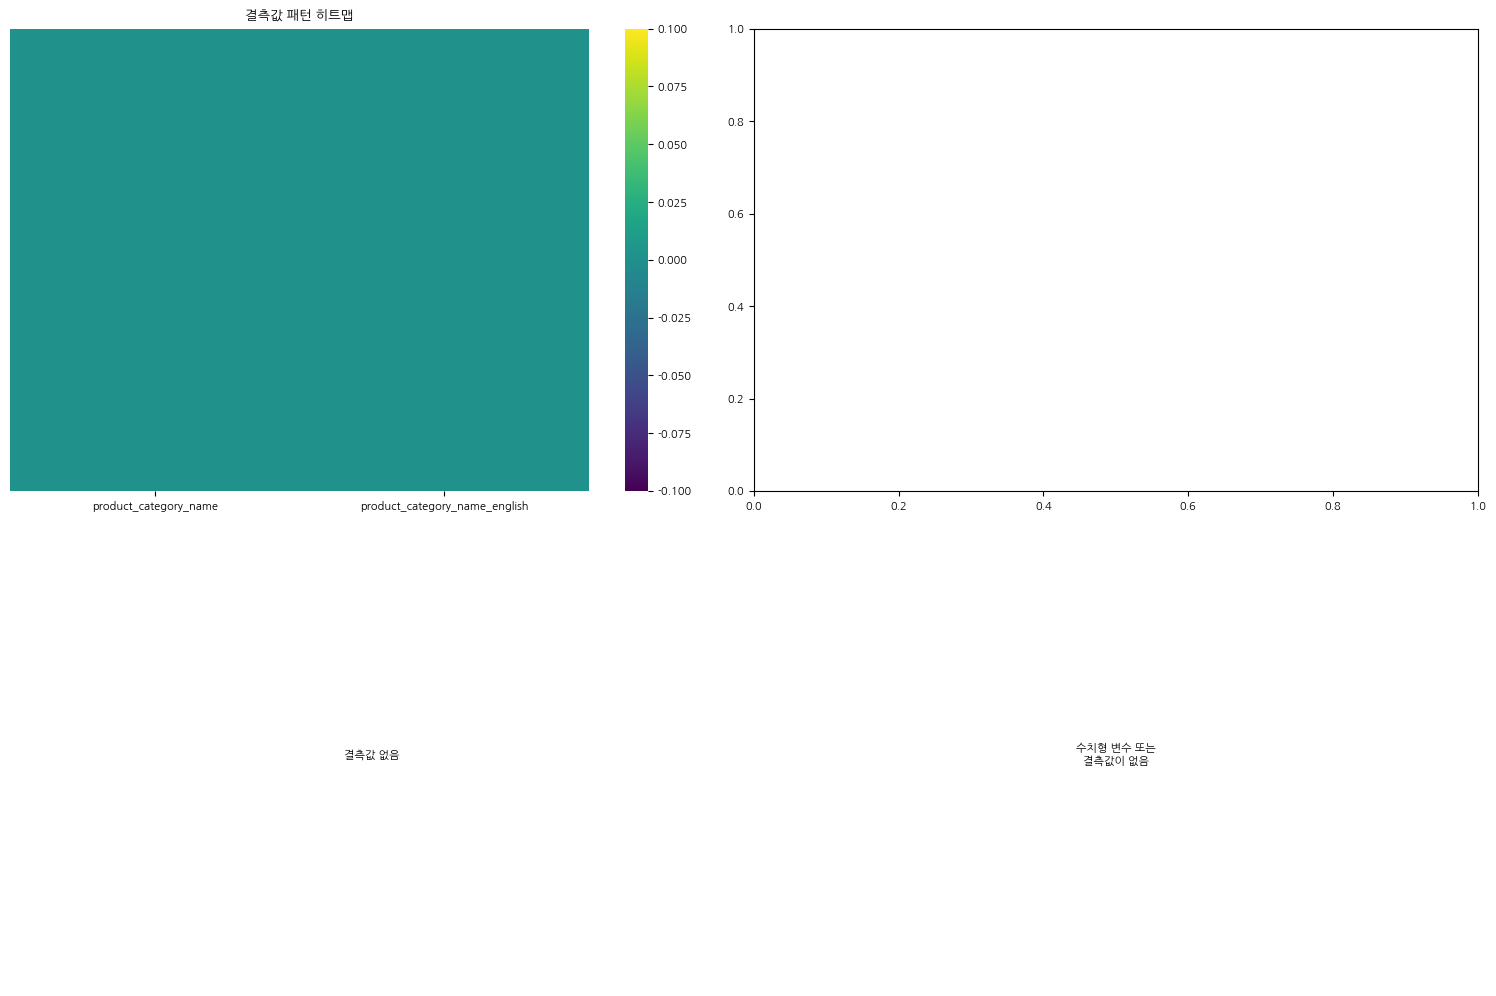

DataFrame 'category_translation': (71, 2) 

Empty DataFrame
Columns: [결측수, 결측률(%)]
Index: [] 



In [73]:
for key, df in dfs:
    print(f"DataFrame '{key}': {df.shape} \n\n{analyze_missing_patterns(df)} \n")

In [74]:
for key, df in dfs:
    globals()[f"{key}_cleaned"] = df.dropna()
    
orders_cleaned.shape

(96461, 8)

In [75]:
for key, df in dfs:
    print(f"DataFrame '{key}': {df.shape} \n\n{outlier_detection(df.dropna(), 0.999, iso_cont='auto', final_threshold=2)} \n")

❗ 수치형 변수가 없어 이상값 탐지를 수행할 수 없습니다.
DataFrame 'orders': (99441, 8) 

None 

=== 종합 이상값 탐지 시스템 ===
1. 일변량 이상값 탐지 (IQR방법)
  order_item_id: 13984개 (12.4%)
  price: 8427개 (7.5%)
  freight_value: 12134개 (10.8%)

2. 다변량 이상값 탐지 (마할라노비스 거리)
  임계값: 4.03
  다변량 이상값: 3602개 (3.2%)

3. 다변량 이상값 탐지 (Isolation Forest)
  Isolation Forest 이상값: 11265개 (10.0%)

 == 최종 이상값: 11265개 (10.0%)
DataFrame 'items': (112650, 7) 

(          일변량  Mahal Dist  Iso Forest  총이상값수
0       False       False       False      0
1       False       False       False      0
2       False       False       False      0
3       False       False       False      0
4       False       False       False      0
...       ...         ...         ...    ...
112645   True       False       False      1
112646   True       False       False      1
112647  False       False       False      0
112648  False       False       False      0
112649  False       False       False      0

[112650 rows x 4 columns], 0         False
1         False

## 결측치에 대해 : 
- orders의 경우 결측치가 3% 이하이나, 결측치 있는 column은 datetime형식으로, 주/일단위에서 결측이 있을 수 있음, 단순 삭제 및 월단위 미만은 아직 취급하지 않을 예정
- review data의 경우 review_comment_title, review_comment_title 와 같이 사용자 입력 데이터에 대해 50% 이상으로 결측치가 많음
- 중복값은 없음

In [76]:
for key, df in dfs:
    print(f"DataFrame '{key}' \n")
    print(f"{df.info()} \n")

DataFrame 'orders' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  category      
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2)
memory usage: 5.4+ MB
None 

DataFrame 'items' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 co

In [77]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [78]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800384,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [79]:
orders['order_status'].unique()

['delivered', 'invoiced', 'shipped', 'processing', 'unavailable', 'canceled', 'created', 'approved']
Categories (8, object): ['approved', 'canceled', 'created', 'delivered', 'invoiced', 'processing', 'shipped', 'unavailable']

In [80]:
orders['order_status'].value_counts() # 97% of all orders were delivered

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [81]:
payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [82]:
payments['payment_type'].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [83]:
items.describe()

,order_item_id,shipping_limit_date,price,freight_value
count,112650.000000,112650,112650.000000,112650.000000
mean,1.197834,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,1.000000,2016-09-19 00:15:34,0.850000,0.000000
25%,1.000000,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,1.000000,2018-01-26 13:59:35,74.990000,16.260000
75%,1.000000,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,0.705124,NaN,183.633928,15.806405


In [84]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  category      
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2)
memory usage: 5.4+ MB


In [85]:
orders_del_missing = orders.dropna()

In [86]:
orders_del_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  category      
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2)
memory usage: 6.0+ MB


In [87]:
# Merge: orders → customers → items
df = orders.merge(customers, on="customer_id") \
           .merge(items, on="order_id")

# Filter delivered orders only
df = df[df['order_status'] == 'delivered']
 

df.shape
# orders.shape, items.shape, customers.shape, df.shape

(110197, 18)

In [88]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [89]:
df['customer_city'].unique(), df['customer_state'].unique()

(['sao paulo', 'barreiras', 'vianopolis', 'sao goncalo do amarante', 'santo andre', ..., 'pacuja', 'umburanas', 'messias targino', 'campo do tenente', 'nova vicosa']
 Length: 4085
 Categories (4119, object): ['abadia dos dourados', 'abadiania', 'abaete', 'abaetetuba', ..., 'xique-xique', 'zacarias', 'ze doca', 'zortea'],
 ['SP', 'BA', 'GO', 'RN', 'PR', ..., 'MA', 'PI', 'AL', 'AC', 'AM']
 Length: 27
 Categories (27, object): ['AC', 'AL', 'AM', 'AP', ..., 'SC', 'SE', 'SP', 'TO'])

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110197 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  category      
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 6   order_delivered_customer_date  110189 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   customer_unique_id             110197 non-null  object        
 9   customer_zip_code_prefix       110197 non-null  int64         
 10  customer_city                  110197 non-null  category      
 11  custo

In [91]:
df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,shipping_limit_date,price,freight_value
count,110197,110182,110195,110189,110197,110197.000000,110197.000000,110197,110197.000000,110197.000000
mean,2018-01-02 02:49:51.928346368,2018-01-02 14:24:00.336697088,2018-01-05 09:42:32.069540608,2018-01-14 13:59:34.689261056,2018-01-25 22:07:57.552020736,35155.346888,1.198181,2018-01-08 17:18:50.631142400,119.980563,19.948598
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,1003.000000,1.000000,2016-09-19 23:11:33,0.850000,0.000000
25%,2017-09-15 06:32:42,2017-09-15 14:55:28,2017-09-18 22:26:15.500000,2017-09-26 20:15:35,2017-10-06 00:00:00,11310.000000,1.000000,2017-09-21 14:55:25,39.900000,13.080000
50%,2018-01-21 10:11:55,2018-01-22 13:57:18.500000,2018-01-24 18:52:54,2018-02-02 21:05:09,2018-02-16 00:00:00,24344.000000,1.000000,2018-01-26 20:16:13,74.900000,16.260000
75%,2018-05-05 16:03:59,2018-05-05 23:10:37.750000128,2018-05-08 14:20:30,2018-05-15 20:14:33,2018-05-28 00:00:00,59066.000000,1.000000,2018-05-10 20:30:37,134.170000,21.150000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,NaN,NaN,NaN,NaN,NaN,29901.148745,0.706676,NaN,182.299446,15.698136


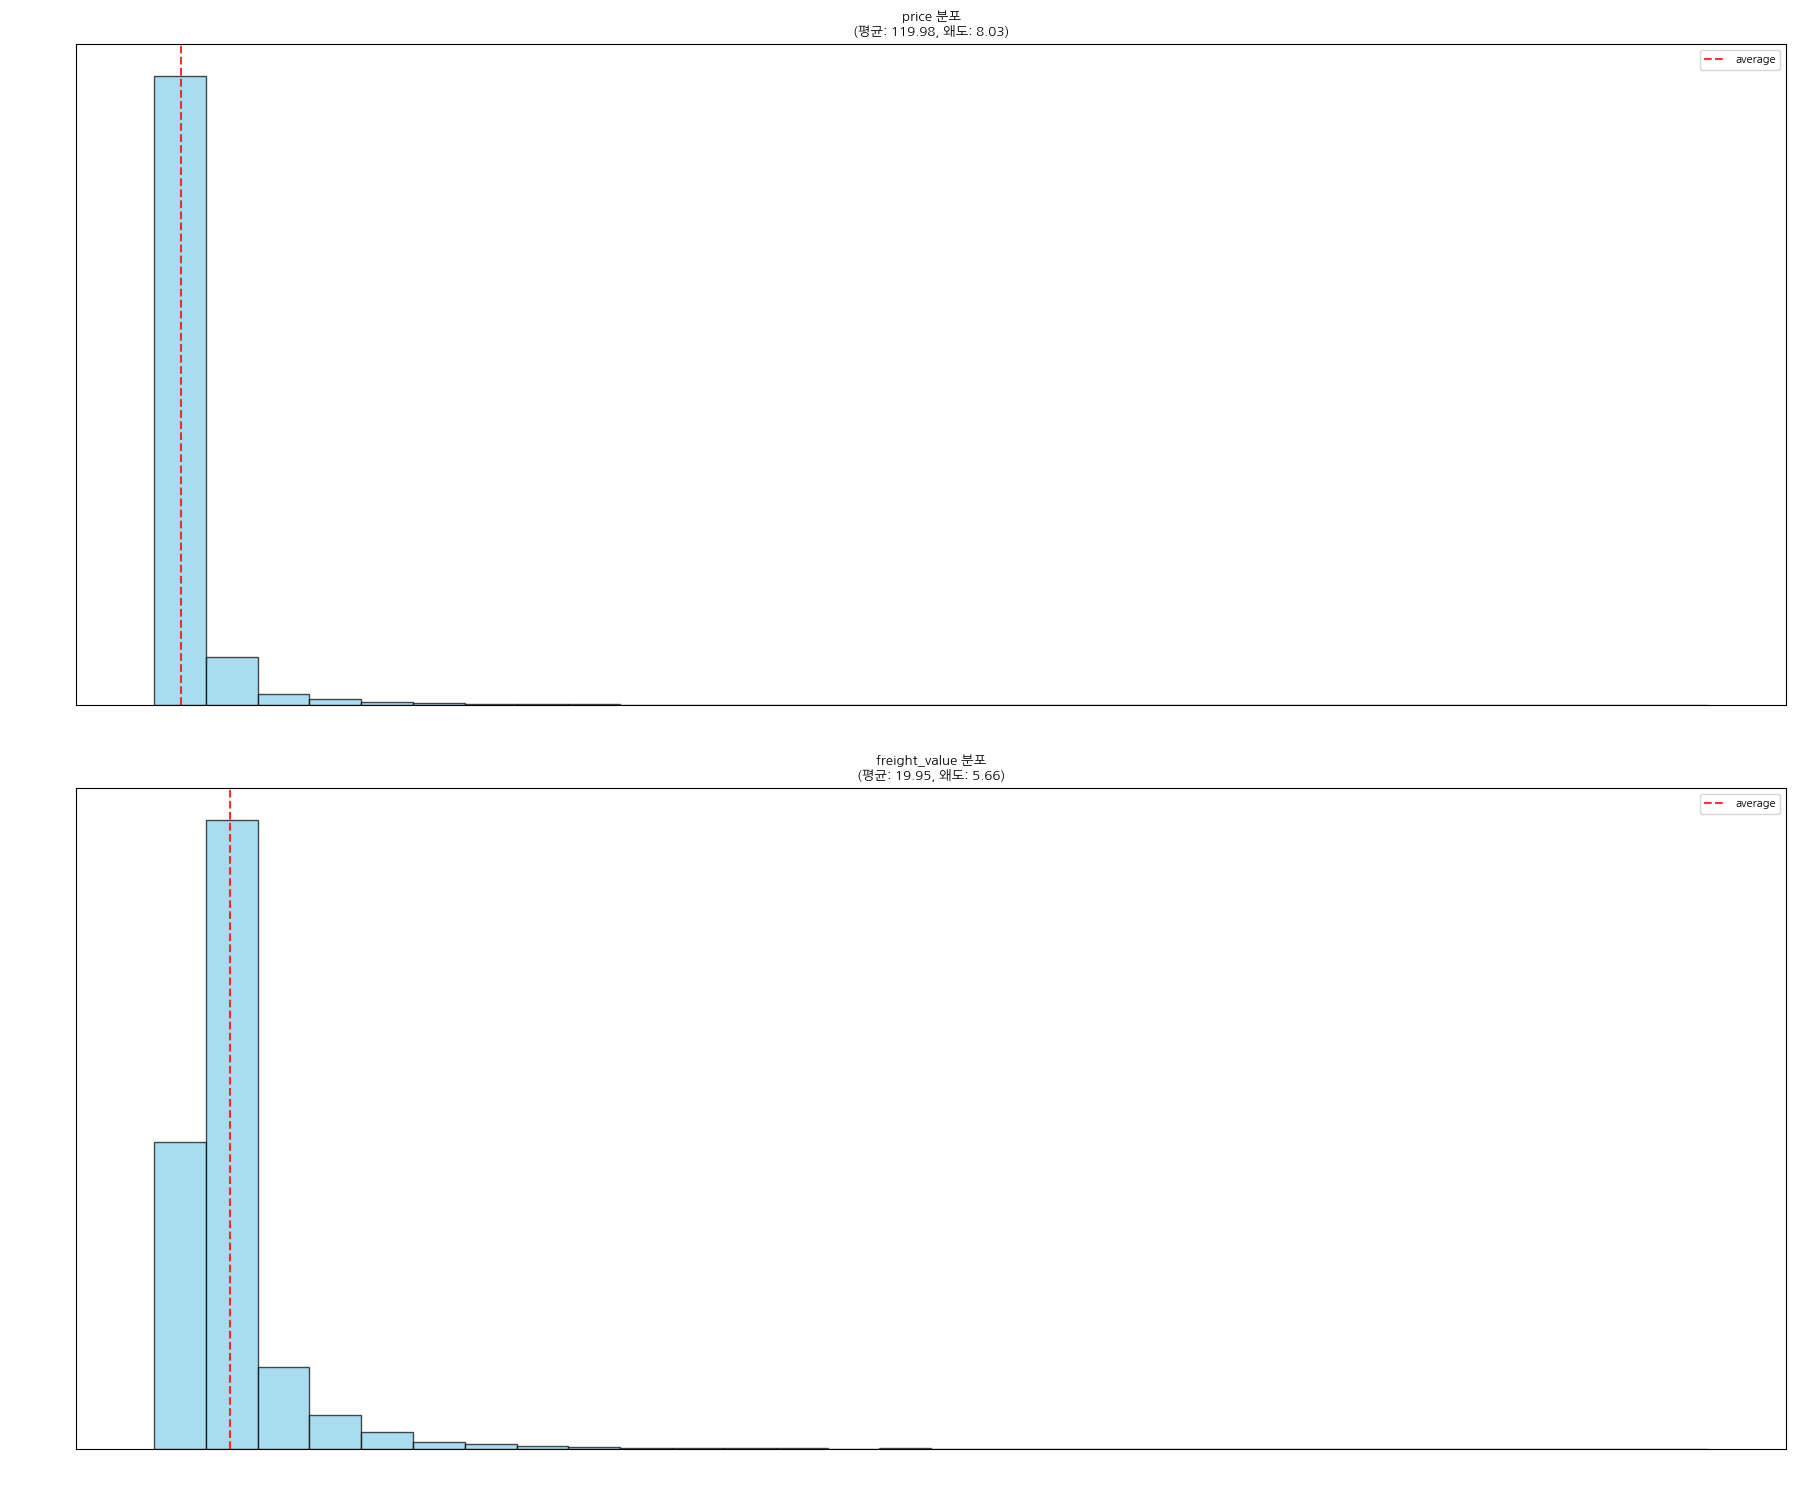

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(18, 15))
axes = axes.ravel()

# visualization of numerical columns
num_vars = ['price', 'freight_value']

for i, var in enumerate(num_vars):
    if i < len(axes):
        ax = axes[i]
        
        # histogram
        ax.hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'{var} 분포\n(평균: {df[var].mean():.2f}, 왜도: {df[var].skew():.2f})')
        ax.set_xlabel(var, color="white")
        ax.set_ylabel('freq', color="white")
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')

        
        # avg line
        ax.axvline(df[var].mean(), color='red', linestyle='--', alpha=0.8, label='average')
        ax.legend()



plt.tight_layout()
plt.show()

In [93]:

# plt.figure(figsize=(14, 10))
# correlation_matrix = df.corr()

# correlation_matrix # All corr < 0.5 : weak correlation


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


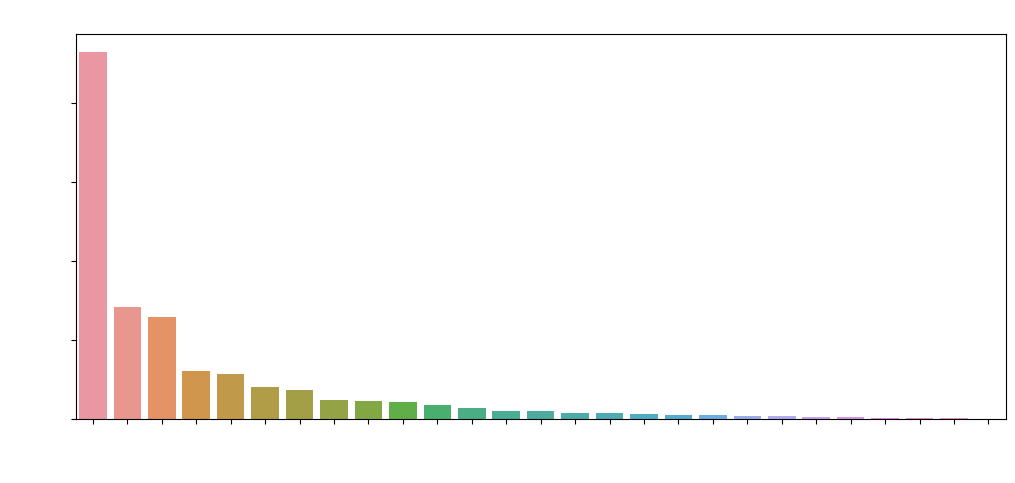

In [94]:
plt.figure(figsize=(12,5))
sns.countplot(
    data=df, 
    x='customer_state', 
    order=df['customer_state'].value_counts().index
)

# Customize text colors
plt.title("Number of Orders by State", color="white", fontsize=14)
plt.xlabel("State", color="white", fontsize=12)
plt.ylabel("Count", color="white", fontsize=12)

# Change tick colors
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")

plt.show()

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110197 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  category      
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 6   order_delivered_customer_date  110189 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   customer_unique_id             110197 non-null  object        
 9   customer_zip_code_prefix       110197 non-null  int64         
 10  customer_city                  110197 non-null  category      
 11  custo

In [96]:
df['customer_id'].nunique(), df['customer_unique_id'].nunique()

(96478, 93358)

In [97]:
regional_stats = df.groupby('customer_state').agg({
    'customer_city':  ['count', 'nunique'],  
    'order_id':  ['count', 'nunique'],  # 지역별 구매 횟수(Frequency)
    'customer_id':  ['count', 'nunique'],  # 지역별 구매 고객수 
    'customer_unique_id':  ['count', 'nunique'],  # 지역별 구매 고객수 
    'customer_zip_code_prefix':  ['count', 'nunique'],
    'price': 'mean',  # 평균 단가
    'freight_value': 'mean',  # 운임 평균 단가
    'order_purchase_timestamp': ['min', 'max'],  
    'order_approved_at': ['min', 'max'], 
    'order_delivered_carrier_date': ['min', 'max'], 
    'order_estimated_delivery_date': ['min', 'max'], 
    'shipping_limit_date': ['min', 'max'], 
    
    
}).round(2)


regional_stats.head()
# (regional_stats['customer_unique_id'])
# regional_stats['customer_city'].sum(), df['customer_city'].nunique()

/tmp/ipykernel_102/3803177565.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_stats = df.groupby('customer_state').agg({


customer_city         order_id         customer_id          \
                       count nunique    count nunique       count nunique   
customer_state                                                              
AC                        91       8       91      80          91      80   
AL                       427      66      427     397         427     397   
AM                       163       5      163     145         163     145   
AP                        81       6       81      67          81      67   
BA                      3683     352     3683    3256        3683    3256   

               customer_unique_id         customer_zip_code_prefix          \
                            count nunique                    count nunique   
customer_state                                                               
AC                             91      76                       91      20   
AL                            427     387                      427     124   
AM                            163     140                      163      55   
AP                             81      66                       81      18   
BA                           3683    3158                     3683     732   

                ... order_purchase_timestamp                      \
                ...                      min                 max   
customer_state  ...                                                
AC              ...      2017-01-21 19:46:22 2018-08-21 16:31:46   
AL              ...      2016-10-07 10:18:50 2018-08-15 00:26:03   
AM              ...      2017-02-02 11:15:31 2018-08-14 16:18:52   
AP              ...      2017-02-02 18:46:27 2018-08-16 08:17:15   
BA              ...      2016-10-04 19:30:28 2018-08-21 23:24:29   

                 order_approved_at                      \
                               min                 max   
customer_state                                           
AC             2017-01-21 20:01:49 2018-08-21 16:50:33   
AL             2016-10-07 11:55:27 2018-08-15 00:44:10   
AM             2017-02-02 13:30:18 2018-08-15 16:15:24   
AP             2017-02-03 07:01:32 2018-08-16 08:35:18   
BA             2016-10-06 03:10:33 2018-08-21 23:35:15   

               order_delivered_carrier_date                      \
                                        min                 max   
customer_state                                                    
AC                      2017-01-25 05:58:53 2018-08-22 14:04:00   
AL                      2016-10-21 12:25:59 2018-08-22 13:35:00   
AM                      2017-02-03 12:01:00 2018-08-16 15:12:00   
AP                      2017-02-08 14:14:40 2018-08-16 16:42:00   
BA                      2016-10-10 03:10:34 2018-08-24 08:18:00   

               order_estimated_delivery_date            shipping_limit_date  \
                                         min        max                 min   
customer_state                                                                
AC                                2017-03-07 2018-09-26 2017-01-26 19:46:23   
AL                                2016-12-13 2018-10-03 2016-10-11 11:55:28   
AM                                2017-03-13 2018-09-28 2017-02-06 11:15:31   
AP                                2017-03-23 2018-09-12 2017-02-09 18:46:27   
BA                                2016-12-06 2018-10-23 2016-10-10 03:10:34   

                                    
                               max  
customer_state                      
AC             2018-08-24 16:50:33  
AL             2018-08-22 16:25:10  
AM             2018-08-21 16:15:24  
AP             2018-08-20 08:35:18  
BA             2018-08-30 22:10:18  

[5 rows x 22 columns]

## Customer Segmentation and RFM Analysis: 
Analyze regional customer purchasing patterns in Brazil to build an RFM (Recency, Frequency, Monetary) model. Segment customers and identify the characteristics and business strategies for each segment.

In [98]:
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = df.groupby(['customer_state','customer_unique_id', ]).agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_state', 'customer_unique_id', 'Recency', 'Frequency', 'Monetary']

/tmp/ipykernel_102/1957157452.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id', ]).agg({


In [99]:
rfm.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,customer_state,customer_unique_id,Recency,Frequency,Monetary
0,AC,0000366f3b9a7992bf8c76cfdf3221e2,NaN,0,0.0
1,AC,0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,0,0.0
2,AC,0000f46a3911fa3c0805444483337064,NaN,0,0.0
3,AC,0000f6ccb0745a6a4b88665a16c9f078,NaN,0,0.0
4,AC,0004aac84e0df4da2b147fca70cf8255,NaN,0,0.0


In [100]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520666 entries, 0 to 2520665
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   customer_state      category
 1   customer_unique_id  object  
 2   Recency             float64 
 3   Frequency           int64   
 4   Monetary            float64 
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 79.3+ MB


In [101]:
rfm['Recency'].nunique(), rfm['Frequency'].nunique()

(611, 10)

In [102]:
# rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
# rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
# rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# # RFM 세그먼트 생성

# rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)



In [103]:
# # 고객 세그먼트 라벨링
# def segment_customers(row):
#     if row['RFM_Segment'] in ['555', '554', '544', '545', '454', '455', '445']:
#         return 'Champions'
#     elif row['RFM_Segment'] in ['543', '444', '435', '355', '354', '345', '344', '335']:
#         return 'Loyal Customers'
#     elif row['RFM_Segment'] in ['512', '511', '422', '421', '412', '411', '311']:
#         return 'Potential Loyalists'
#     elif row['RFM_Segment'] in ['155', '154', '144', '214', '215', '115', '114']:
#         return 'At Risk'
#     else:
#         return 'Others'

# rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

In [104]:
# rfm.head()

In [105]:
# sns.boxplot(data=rfm, x='customer_state', y='Frequency')
# plt.title("Monetary Distribution by State", color='white')
# plt.xticks(rotation=45, color='white')
# plt.yticks(color='white')
# plt.xlabel('customer_state', color='white')
# plt.ylabel('Frequency', color='white')
# plt.show()

In [106]:
# # 분석 기준일 설정
# max_date = df['order_purchase_timestamp'].max()

# # Frequency: 고객별 주문 횟수
# frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index(name='frequency')

# # Recency: 고객별 마지막 주문으로부터 일수
# recency = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
# recency['recency'] = (max_date - recency['order_purchase_timestamp']).dt.days
# recency = recency[['customer_unique_id', 'recency']]

# # Monetary: 고객별 총 구매액 (items 기준)
# df['price'] = pd.to_numeric(df['price'], errors='coerce')
# monetary = df.groupby('customer_unique_id')['price'].sum().reset_index(name='monetary')

# # RFM 병합
# rfm = recency.merge(frequency, on='customer_unique_id').merge(monetary, on='customer_unique_id')

# # RFM 점수 계산 (1~5)
# rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)
# rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
# rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)
# rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

In [107]:
rfm

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,customer_state,customer_unique_id,Recency,Frequency,Monetary
0,AC,0000366f3b9a7992bf8c76cfdf3221e2,NaN,0,0.0
1,AC,0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,0,0.0
2,AC,0000f46a3911fa3c0805444483337064,NaN,0,0.0
3,AC,0000f6ccb0745a6a4b88665a16c9f078,NaN,0,0.0
4,AC,0004aac84e0df4da2b147fca70cf8255,NaN,0,0.0
...,...,...,...,...,...
2520661,TO,fffcf5a5ff07b0908bd4e2dbc735a684,NaN,0,0.0
2520662,TO,fffea47cd6d3cc0a88bd621562a9d061,NaN,0,0.0
2520663,TO,ffff371b4d645b6ecea244b27531430a,NaN,0,0.0
2520664,TO,ffff5962728ec6157033ef9805bacc48,NaN,0,0.0


In [108]:
def integrated_ecommerce_analysis(orders, customers, items, products, reviews, payments, category_translation):
    """
    브라질 이커머스 데이터 통합 분석 함수
    과제 1,2,3 및 자유주제 분석을 모두 포함
    """
    
    # ========== 기본 데이터 전처리 ==========
    print("결측치(orders):\n", orders.isnull().sum())

    # # orders 결측치 제거
    orders.dropna(inplace=True) 
    # 사용자 제공 코드를 기반으로 기본 병합
    df = orders.merge(customers, on="customer_id") \
               .merge(items, on="order_id")
    
    # 배송 완료된 주문만 필터링
    df = df[df['order_status'] == 'delivered']
    
    snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
    
    # ========== 과제 1: RFM 분석 및 고객 세분화 ==========
    print("=== 과제 1: RFM 분석 및 고객 세분화 ===")
    
    # 기본 RFM 계산 (사용자 제공 코드 기반)
    rfm = df.groupby(['customer_state','customer_unique_id']).agg({
        'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    rfm.columns = ['customer_state', 'customer_unique_id', 'Recency', 'Frequency', 'Monetary']
    
    # RFM 점수 계산
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype('Int64')
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop').astype('Int64')
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, duplicates='drop').cat.codes + 1
    rfm['M_Score'] = rfm['M_Score'].astype('Int64')
    
    # 고객 세그먼트 정의
    def assign_customer_segment(row):
        if pd.isna(row['R_Score']) or pd.isna(row['F_Score']) or pd.isna(row['M_Score']):
            return 'Others'  # or some default segment for missing scores
        if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
            return '1. Champions'
        elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return '2. Loyal Customers'
        elif row['R_Score'] >= 3 and row['F_Score'] <= 2:
            return '3. Potential Loyalists'
        elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
            return '4. At Risk'
        elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
            return '5. Lost Customers'
        else:
            return 'Others'
    
    rfm['Customer_Segment'] = rfm.apply(assign_customer_segment, axis=1)
    
    # 지역별 세그먼트 분포
    segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)
    
    # RFM 통계 출력
    print(f"총 고객 수: {rfm['customer_unique_id'].nunique():,}")
    print(f"세그먼트별 분포:")
    print(rfm['Customer_Segment'].value_counts())
    print(f"\n지역별 상위 5개 주:")
    print(rfm['customer_state'].value_counts().head())
    
    # ========== 과제 2: 배송 성과 분석 ==========
    print("\n=== 과제 2: 배송 성과 분석 ===")
    
    # 배송 시간 계산
    delivery_analysis = orders[orders['order_status'] == 'delivered'].copy()
    delivery_analysis['delivery_time'] = (
        delivery_analysis['order_delivered_customer_date'] - 
        delivery_analysis['order_purchase_timestamp']
    ).dt.days
    
    # 배송 지연 계산
    delivery_analysis['delivery_delay'] = (
        delivery_analysis['order_delivered_customer_date'] - 
        delivery_analysis['order_estimated_delivery_date']
    ).dt.days
    
    # 고객 정보 병합
    delivery_analysis = delivery_analysis.merge(
        customers[['customer_id', 'customer_state', 'customer_city']], 
        on='customer_id'
    )
    
    # 지역별 배송 성과
    regional_delivery = delivery_analysis.groupby('customer_state').agg({
        'delivery_time': ['mean', 'median', 'std'],
        'delivery_delay': 'mean',
        'order_id': 'count'
    }).round(2)
    
    regional_delivery.columns = ['avg_delivery_days', 'median_delivery_days', 
                                'std_delivery_days', 'avg_delay_days', 'order_count']
    
    # 리뷰와 배송 성과 상관관계
    delivery_reviews = delivery_analysis.merge(
        reviews[['order_id', 'review_score']], 
        on='order_id', how='left'
    )
    
    # 배송 지연과 리뷰 점수 관계
    delivery_reviews['is_delayed'] = delivery_reviews['delivery_delay'] > 0
    delay_impact = delivery_reviews.groupby('is_delayed')['review_score'].agg(['mean', 'count', 'std']).round(3)
    
    print(f"평균 배송 시간: {delivery_analysis['delivery_time'].mean():.1f}일")
    print(f"배송 지연 영향:")
    print(delay_impact)
    print(f"\n지역별 배송 성과 (상위 10개 주):")
    print(regional_delivery.sort_values('order_count', ascending=False).head(10))
    
    # ========== 과제 3: 상품 카테고리별 수요 분석 ==========
    print("\n=== 과제 3: 상품 카테고리별 수요 분석 ===")
    
    # 상품 카테고리 정보 병합
    category_analysis = items.merge(products[['product_id', 'product_category_name']], on='product_id')
    category_analysis = category_analysis.merge(
        orders[['order_id', 'order_purchase_timestamp']], 
        on='order_id'
    )
    
    # 카테고리 번역 적용
    if 'product_category_name_english' in category_translation.columns:
        category_analysis = category_analysis.merge(
            category_translation, 
            on='product_category_name', 
            how='left'
        )
        category_col = 'product_category_name_english'
    else:
        category_col = 'product_category_name'
    
    # 월별 카테고리별 판매량
    category_analysis['order_year_month'] = category_analysis['order_purchase_timestamp'].dt.to_period('M')
    
    monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
        'order_id': 'count',
        'price': 'sum'
    }).reset_index()
    monthly_category_sales.columns = ['month', 'category', 'order_count', 'revenue']
    
    # 상위 카테고리 식별
    top_categories = category_analysis[category_col].value_counts().head(10)
    
    # 계절성 분석을 위한 월별 데이터
    category_analysis['month'] = category_analysis['order_purchase_timestamp'].dt.month
    seasonal_pattern = category_analysis[
        category_analysis[category_col].isin(top_categories.index)
    ].groupby(['month', category_col]).size().unstack(fill_value=0)
    
    print(f"상위 10개 카테고리:")
    print(top_categories)
    print(f"\n월별 계절성 패턴 (상위 5개 카테고리):")
    print(seasonal_pattern[top_categories.head().index].describe())
    
    # ========== 자유 주제: 종합 비즈니스 분석 ==========
    print("\n=== 자유 주제: 종합 비즈니스 분석 ===")
    
    # 전체 비즈니스 메트릭
    business_summary = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).agg({
        'order_id': 'nunique',
        'customer_unique_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    business_summary.columns = ['month', 'total_orders', 'unique_customers', 'total_revenue']
    business_summary['avg_order_value'] = business_summary['total_revenue'] / business_summary['total_orders']
    
    # 결제 방법 분석
    payment_analysis = payments.groupby('payment_type').agg({
        'payment_value': ['count', 'sum', 'mean']
    }).round(2)
    payment_analysis.columns = ['transaction_count', 'total_value', 'avg_value']
    
    # 고객 만족도 분석
    satisfaction_summary = reviews.groupby('review_score').size().reset_index(name='count')
    satisfaction_summary['percentage'] = (satisfaction_summary['count'] / satisfaction_summary['count'].sum() * 100).round(1)
    
    print(f"전체 기간 총 주문: {business_summary['total_orders'].sum():,}")
    print(f"전체 기간 총 매출: R$ {business_summary['total_revenue'].sum():,.2f}")
    print(f"평균 주문 가격: R$ {business_summary['avg_order_value'].mean():.2f}")
    print(f"평균 고객 만족도: {reviews['review_score'].mean():.2f}/5")
    
    print(f"\n결제 방법별 분석:")
    print(payment_analysis.sort_values('total_value', ascending=False))
    
    # 결과 반환
    results = {
        'rfm_analysis': rfm,
        'segment_by_region': segment_by_region,
        'delivery_performance': regional_delivery,
        'delivery_review_impact': delay_impact,
        'category_monthly_sales': monthly_category_sales,
        'seasonal_patterns': seasonal_pattern,
        'business_summary': business_summary,
        'payment_analysis': payment_analysis,
        'satisfaction_summary': satisfaction_summary
    }
    
    return results

# ========== 추가 분석 및 시각화 함수 ==========

def create_comprehensive_visualizations(results):
    """분석 결과에 대한 종합 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. RFM 세그먼트 분포
    results['rfm_analysis']['Customer_Segment'].value_counts().plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Customer Segmentation Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. 지역별 배송 성과
    top_states = results['delivery_performance'].sort_values('order_count', ascending=False).head(10)
    top_states['avg_delivery_days'].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Average Delivery Days by State (Top 10)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. 월별 매출 트렌드
    results['business_summary'].set_index('month')['total_revenue'].plot(ax=axes[0,2])
    axes[0,2].set_title('Monthly Revenue Trend')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. 고객 만족도 분포
    results['satisfaction_summary'].set_index('review_score')['percentage'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Customer Satisfaction Distribution (%)')
    
    # 5. 결제 방법별 거래량
    results['payment_analysis']['transaction_count'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Transaction Count by Payment Type')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. 상위 카테고리 계절성
    if not results['seasonal_patterns'].empty:
        top_5_cats = results['seasonal_patterns'].sum().nlargest(5).index
        results['seasonal_patterns'][top_5_cats].plot(ax=axes[1,2])
        axes[1,2].set_title('Seasonal Patterns - Top 5 Categories')
        axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.rcParams['text.color'] = 'gray'
    plt.rcParams['axes.labelcolor'] = 'gray'
    plt.rcParams['xtick.color'] = 'gray'
    plt.rcParams['ytick.color'] = 'gray'
    plt.rcParams['axes.edgecolor'] = 'gray'
    plt.show()

def generate_business_recommendations(results):
    """분석 결과 기반 비즈니스 권장사항"""
    
    recommendations = []
    
    # RFM 분석 기반 권장사항
    champions_pct = (results['rfm_analysis']['Customer_Segment'] == 'Champions').mean() * 100
    at_risk_pct = (results['rfm_analysis']['Customer_Segment'] == 'At Risk').mean() * 100
    
    recommendations.append(f"고객 관리: Champions {champions_pct:.1f}% 유지, At Risk {at_risk_pct:.1f}% 재활성화 필요")
    
    # 배송 성과 기반 권장사항
    slow_delivery_states = results['delivery_performance'][
        results['delivery_performance']['avg_delivery_days'] > 
        results['delivery_performance']['avg_delivery_days'].mean()
    ].index[:5]
    
    recommendations.append(f"물류 개선: {', '.join(slow_delivery_states)} 지역 배송 최적화 필요")
    
    # 만족도 기반 권장사항
    low_satisfaction_pct = results['satisfaction_summary'][
        results['satisfaction_summary']['review_score'] <= 3
    ]['percentage'].sum()
    
    recommendations.append(f"고객 만족도: {low_satisfaction_pct:.1f}% 고객이 불만족, 서비스 품질 개선 필요")
    
    return recommendations

# ========== 실행 예시 ==========
"""
# 데이터 로드 후 실행
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

# 통합 분석 실행
results = integrated_ecommerce_analysis(
    orders, customers, items, products, reviews, payments, category_translation
)

# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results)
recommendations = generate_business_recommendations(results)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")
"""

'\n# 데이터 로드 후 실행\norders = pd.read_csv(\'olist_orders_dataset.csv\')\ncustomers = pd.read_csv(\'olist_customers_dataset.csv\')\nitems = pd.read_csv(\'olist_order_items_dataset.csv\')\nproducts = pd.read_csv(\'olist_products_dataset.csv\')\nreviews = pd.read_csv(\'olist_order_reviews_dataset.csv\')\npayments = pd.read_csv(\'olist_order_payments_dataset.csv\')\ncategory_translation = pd.read_csv(\'product_category_name_translation.csv\')\n\n# 통합 분석 실행\nresults = integrated_ecommerce_analysis(\n    orders, customers, items, products, reviews, payments, category_translation\n)\n\n# 시각화 및 권장사항 생성\ncreate_comprehensive_visualizations(results)\nrecommendations = generate_business_recommendations(results)\n\nprint("\n=== 비즈니스 권장사항 ===")\nfor i, rec in enumerate(recommendations, 1):\n    print(f"{i}. {rec}")\n'

In [109]:


# 통합 분석 실행
results = integrated_ecommerce_analysis(
    orders, customers, items, products, reviews, payments, category_translation
)




결측치(orders):
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
=== 과제 1: RFM 분석 및 고객 세분화 ===


/tmp/ipykernel_102/2580944674.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id']).agg({
/tmp/ipykernel_102/2580944674.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)


총 고객 수: 93,336
세그먼트별 분포:
Customer_Segment
Others        2482844
4. At Risk      37228
Name: count, dtype: int64

지역별 상위 5개 주:
customer_state
AC    93336
AL    93336
AM    93336
AP    93336
BA    93336
Name: count, dtype: int64

=== 과제 2: 배송 성과 분석 ===
평균 배송 시간: 12.1일
배송 지연 영향:
             mean  count    std
is_delayed                     
False       4.290  89930  1.150
True        2.271   6408  1.571

지역별 배송 성과 (상위 10개 주):
                avg_delivery_days  median_delivery_days  std_delivery_days  \
customer_state                                                               
SP                           8.30                   7.0               6.76   
RJ                          14.85                  12.0              11.53   
MG                          11.54                  10.0               7.20   
RS                          14.82                  13.0               9.18   
PR                          11.53                  10.0               6.99   
SC                        

/tmp/ipykernel_102/2580944674.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_delivery = delivery_analysis.groupby('customer_state').agg({


상위 10개 카테고리:
product_category_name_english
bed_bath_table           10952
health_beauty             9467
sports_leisure            8429
furniture_decor           8156
computers_accessories     7643
housewares                6795
watches_gifts             5857
telephony                 4428
garden_tools              4267
auto                      4139
Name: count, dtype: int64

월별 계절성 패턴 (상위 5개 카테고리):
product_category_name_english  bed_bath_table  health_beauty  sports_leisure  \
count                               12.000000      12.000000       12.000000   
mean                               912.666667     788.916667      702.416667   
std                                247.201182     289.017602      163.379346   
min                                528.000000     379.000000      453.000000   
25%                                768.250000     544.750000      568.750000   
50%                                984.000000     834.500000      750.000000   
75%                               11

/tmp/ipykernel_102/2580944674.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
/tmp/ipykernel_102/2580944674.py:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(['month', category_col]).size().unstack(fill_value=0)


In [110]:
# 통합 분석 실행
results_del_missing = integrated_ecommerce_analysis(
    orders_del_missing, customers, items, products, reviews, payments, category_translation
)

결측치(orders):
 order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64
=== 과제 1: RFM 분석 및 고객 세분화 ===


/tmp/ipykernel_102/2580944674.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id']).agg({
/tmp/ipykernel_102/2580944674.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)


총 고객 수: 93,336
세그먼트별 분포:
Customer_Segment
Others        2482844
4. At Risk      37228
Name: count, dtype: int64

지역별 상위 5개 주:
customer_state
AC    93336
AL    93336
AM    93336
AP    93336
BA    93336
Name: count, dtype: int64

=== 과제 2: 배송 성과 분석 ===
평균 배송 시간: 12.1일
배송 지연 영향:
             mean  count    std
is_delayed                     
False       4.290  89930  1.150
True        2.271   6408  1.571

지역별 배송 성과 (상위 10개 주):
                avg_delivery_days  median_delivery_days  std_delivery_days  \
customer_state                                                               
SP                           8.30                   7.0               6.76   
RJ                          14.85                  12.0              11.53   
MG                          11.54                  10.0               7.20   
RS                          14.82                  13.0               9.18   
PR                          11.53                  10.0               6.99   
SC                        

/tmp/ipykernel_102/2580944674.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_delivery = delivery_analysis.groupby('customer_state').agg({
/tmp/ipykernel_102/2580944674.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({


상위 10개 카테고리:
product_category_name_english
bed_bath_table           10952
health_beauty             9467
sports_leisure            8429
furniture_decor           8156
computers_accessories     7643
housewares                6795
watches_gifts             5857
telephony                 4428
garden_tools              4267
auto                      4139
Name: count, dtype: int64

월별 계절성 패턴 (상위 5개 카테고리):
product_category_name_english  bed_bath_table  health_beauty  sports_leisure  \
count                               12.000000      12.000000       12.000000   
mean                               912.666667     788.916667      702.416667   
std                                247.201182     289.017602      163.379346   
min                                528.000000     379.000000      453.000000   
25%                                768.250000     544.750000      568.750000   
50%                                984.000000     834.500000      750.000000   
75%                               11

/tmp/ipykernel_102/2580944674.py:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(['month', category_col]).size().unstack(fill_value=0)


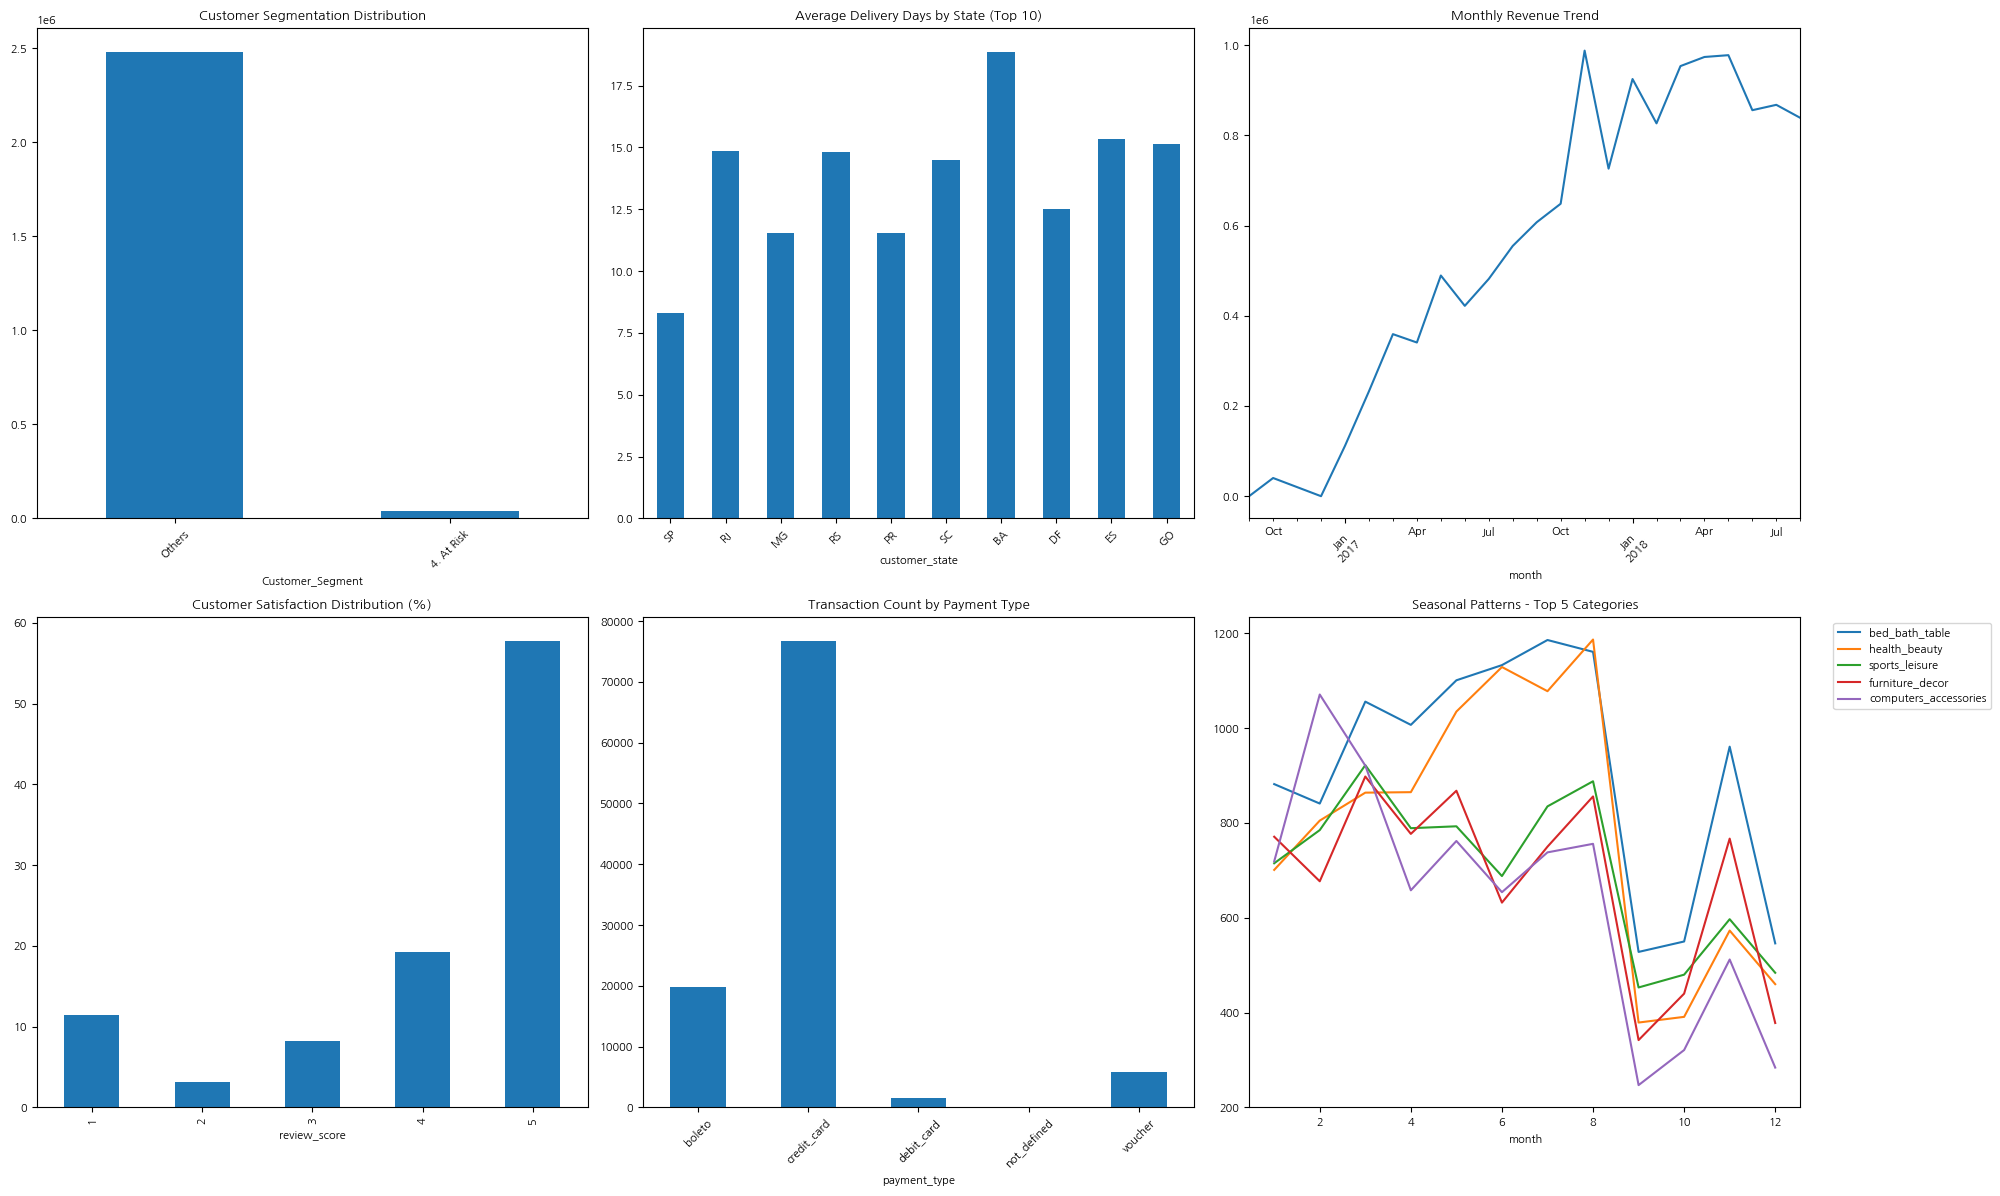


=== 비즈니스 권장사항 ===
1. 고객 관리: Champions 0.0% 유지, At Risk 0.0% 재활성화 필요
2. 물류 개선: AC, AL, AM, AP, BA 지역 배송 최적화 필요
3. 고객 만족도: 22.9% 고객이 불만족, 서비스 품질 개선 필요


In [111]:
# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results)
recommendations = generate_business_recommendations(results)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

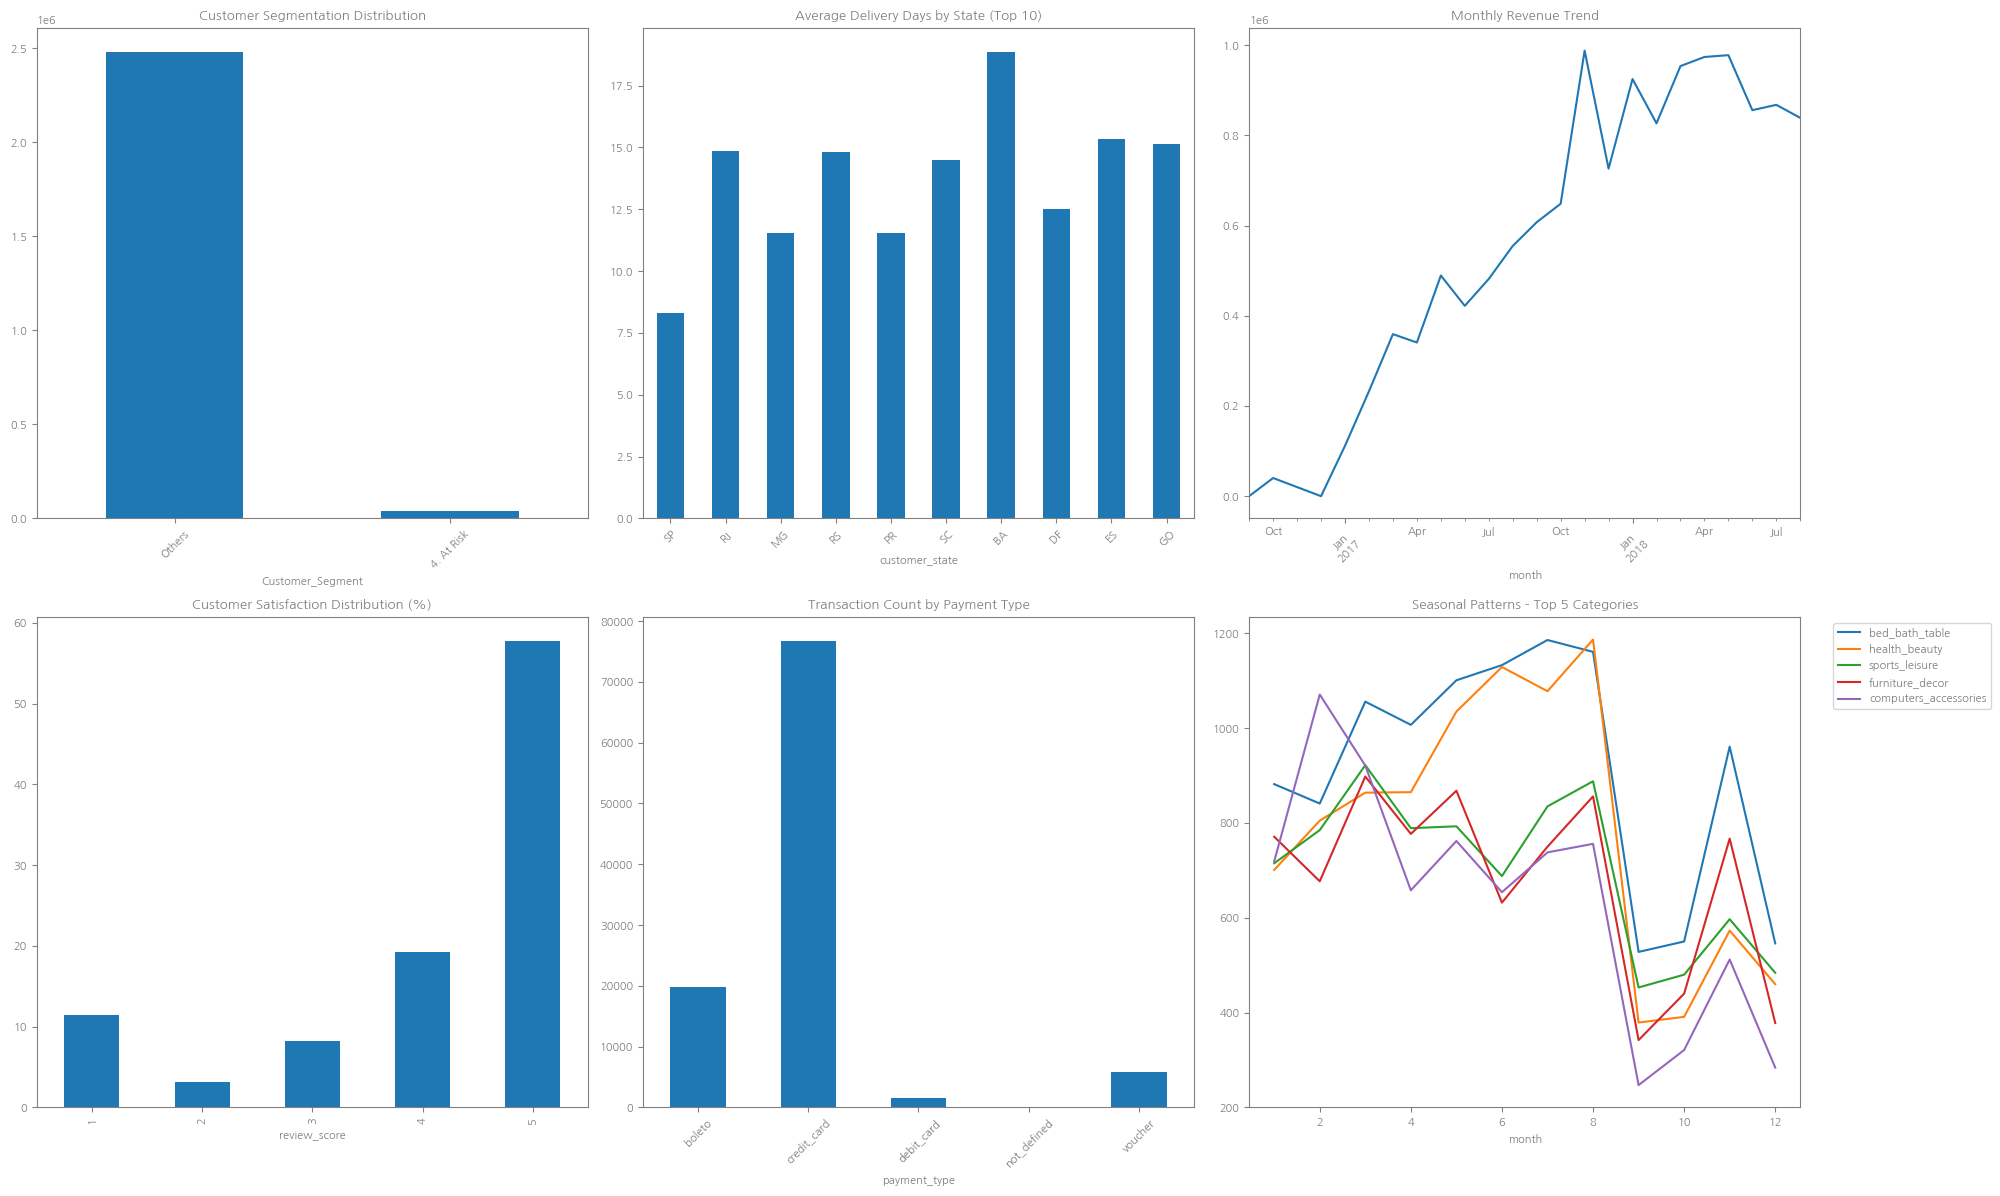


=== 비즈니스 권장사항 ===
1. 고객 관리: Champions 0.0% 유지, At Risk 0.0% 재활성화 필요
2. 물류 개선: AC, AL, AM, AP, BA 지역 배송 최적화 필요
3. 고객 만족도: 22.9% 고객이 불만족, 서비스 품질 개선 필요


In [112]:
# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results_del_missing)
recommendations = generate_business_recommendations(results_del_missing)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

In [113]:
def integrated_ecommerce_analysis(orders, customers, items, products, reviews, payments, category_translation):
    """
    브라질 이커머스 데이터 통합 분석 함수
    과제 1,2,3 및 자유주제 분석을 모두 포함
    """
    
    # ========== 기본 데이터 전처리 ==========
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
    
    df = orders.merge(customers, on="customer_id") \
               .merge(items, on="order_id")
    
    df = df[df['order_status'] == 'delivered']
    
    snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
    
    # Add 'month' column for correlation heatmaps
    df['month'] = df['order_purchase_timestamp'].dt.month
    
    # ========== 과제 1: RFM 분석 및 고객 세분화 ==========
    print("=== 과제 1: RFM 분석 및 고객 세분화 ===")
    
    rfm = df.groupby(['customer_state','customer_unique_id']).agg({
        'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    rfm.columns = ['customer_state', 'customer_unique_id', 'Recency', 'Frequency', 'Monetary']
    
    # RFM 점수 계산
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype('Int64')
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop').astype('Int64')
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, duplicates='drop').cat.codes + 1
    rfm['M_Score'] = rfm['M_Score'].astype('Int64')
    
    # 고객 세그먼트 정의
    def assign_customer_segment(row):
        if pd.isna(row['R_Score']) or pd.isna(row['F_Score']) or pd.isna(row['M_Score']):
            return 'Others'  # or some default segment for missing scores
        if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
            return '1. Champions'
        elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return '2. Loyal Customers'
        elif row['R_Score'] >= 3 and row['F_Score'] <= 2:
            return '3. Potential Loyalists'
        elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
            return '4. At Risk'
        elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
            return '5. Lost Customers'
        else:
            return 'Others'
    
    rfm['Customer_Segment'] = rfm.apply(assign_customer_segment, axis=1)
    
    segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)
    
    print(f"총 고객 수: {rfm['customer_unique_id'].nunique():,}")
    print(f"세그먼트별 분포:")
    print(rfm['Customer_Segment'].value_counts())
    print(f"\n지역별 상위 5개 주:")
    print(rfm['customer_state'].value_counts().head())
    
    # Prepare data subset for correlation heatmap in 과제 1
    # Merge reviews and payments values for correlation analysis
    payment_agg = payments[['order_id','payment_value']].groupby('order_id').sum().reset_index()
    data_corr = df[['order_id','price','month']].merge(reviews[['order_id','review_score']], on='order_id', how='left')
    data_corr = data_corr.merge(payment_agg, on='order_id', how='left')
    data_corr = data_corr.merge(df[['order_id','freight_value']].drop_duplicates(), on='order_id', how='left')
    correlation_df = data_corr[['order_id','price','review_score','payment_value','freight_value','month']].copy()
    
    # To get 'delivery_time' add it to correlation_df from orders:
    delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
    delivered_orders['delivery_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days
    correlation_df = correlation_df.merge(delivered_orders[['order_id','delivery_time']], on='order_id', how='left')
    correlation_df = correlation_df[['price','review_score','delivery_time','payment_value','freight_value','month']]

    
    # ========== 과제 2: 배송 성과 분석 ==========
    print("\n=== 과제 2: 배송 성과 분석 ===")
    
    delivery_analysis = orders[orders['order_status'] == 'delivered'].copy()
    delivery_analysis['delivery_time'] = (
        delivery_analysis['order_delivered_customer_date'] - 
        delivery_analysis['order_purchase_timestamp']
    ).dt.days
    
    delivery_analysis['delivery_delay'] = (
        delivery_analysis['order_delivered_customer_date'] - 
        delivery_analysis['order_estimated_delivery_date']
    ).dt.days
    
    delivery_analysis = delivery_analysis.merge(
        customers[['customer_id', 'customer_state', 'customer_city']], 
        on='customer_id'
    )
    
    # Join price info to delivery_analysis
    # Sum price and freight_value per order and merge back to delivery_analysis
    
    order_price = items.groupby('order_id')['price'].sum().reset_index()
    order_freight = items.groupby('order_id')['freight_value'].mean().reset_index()
    
    delivery_analysis = delivery_analysis.merge(order_price, on='order_id', how='left')
    delivery_analysis = delivery_analysis.merge(order_freight, on='order_id', how='left')
    
    # Now you have 'price' and 'freight_value' columns in delivery_analysis
    regional_delivery = delivery_analysis.groupby('customer_state').agg({
    'delivery_time': ['mean', 'median', 'std'],
    'delivery_delay': 'mean',
    'order_id': 'count',
    'price':'mean',
    'freight_value':'mean'
    }).round(2)
    
    regional_delivery.columns = ['avg_delivery_days', 'median_delivery_days', 
                                'std_delivery_days', 'avg_delay_days', 'order_count', 'avg_price', 'avg_freight_value']
    
    delivery_reviews = delivery_analysis.merge(
        reviews[['order_id', 'review_score']], 
        on='order_id', how='left'
    )
    
    delivery_reviews['is_delayed'] = delivery_reviews['delivery_delay'] > 0
    delay_impact = delivery_reviews.groupby('is_delayed')['review_score'].agg(['mean', 'count', 'std']).round(3)
    
    # Product Category Name by State histogram
    pc_by_state = delivery_analysis.merge(items[['order_id','product_id']], on='order_id')\
                                   .merge(products[['product_id','product_category_name']], on='product_id')
    
    pc_by_state_hist_data = pc_by_state.groupby(['customer_state','product_category_name']).size().reset_index(name='count')
    
    # Payment Type distribution removing 'not_defined'
    payments_filtered = payments[payments['payment_type'] != 'not_defined']
    
    # Number of orders by State
    orders_by_state = delivery_analysis.groupby('customer_state')['order_id'].count()
    avg_price_by_state = regional_delivery['avg_price']
    avg_freight_by_state = regional_delivery['avg_freight_value']
    avg_delivery_by_state = regional_delivery['avg_delivery_days']
    avg_review_by_state = delivery_reviews.groupby('customer_state')['review_score'].mean()
    
    # Correlation heatmap for delivery performance variables
    corr_vars = pd.concat([
        orders_by_state, avg_price_by_state, avg_freight_by_state,
        avg_delivery_by_state, avg_review_by_state
    ], axis=1).dropna()
    corr_vars.columns = ['Number_of_Orders', 'Average_Price', 'Average_Freight_Value', 'Average_Delivery_Days', 'Average_Review_Score']
    
    # ========== 과제 3: 상품 카테고리별 수요 분석 ==========
    print("\n=== 과제 3: 상품 카테고리별 수요 분석 ===")
    
    category_analysis = items.merge(products[['product_id', 'product_category_name']], on='product_id')
    category_analysis = category_analysis.merge(
        orders[['order_id', 'order_purchase_timestamp']], 
        on='order_id'
    )
    
    if 'product_category_name_english' in category_translation.columns:
        category_analysis = category_analysis.merge(
            category_translation, 
            on='product_category_name', 
            how='left'
        )
        category_col = 'product_category_name_english'
    else:
        category_col = 'product_category_name'
    
    category_analysis['order_year_month'] = category_analysis['order_purchase_timestamp'].dt.to_period('M')
    
    monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
        'order_id': 'count',
        'price': 'sum'
    }).reset_index()
    monthly_category_sales.columns = ['month', 'category', 'order_count', 'revenue']
    
    top_categories = category_analysis[category_col].value_counts().head(10)
    category_analysis['month'] = category_analysis['order_purchase_timestamp'].dt.month
    seasonal_pattern = category_analysis[
        category_analysis[category_col].isin(top_categories.index)
    ].groupby(['month', category_col]).size().unstack(fill_value=0)
    
    print(f"상위 10개 카테고리:")
    print(top_categories)
    print(f"\n월별 계절성 패턴 (상위 5개 카테고리):")
    print(seasonal_pattern[top_categories.head().index].describe())
    
    # ========== 자유 주제: 종합 비즈니스 분석 ==========
    print("\n=== 자유 주제: 종합 비즈니스 분석 ===")
    
    business_summary = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).agg({
        'order_id': 'nunique',
        'customer_unique_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    business_summary.columns = ['month', 'total_orders', 'unique_customers', 'total_revenue']
    business_summary['avg_order_value'] = business_summary['total_revenue'] / business_summary['total_orders']
    
    payment_analysis = payments_filtered.groupby('payment_type').agg({
        'payment_value': ['count', 'sum', 'mean']
    }).round(2)
    payment_analysis.columns = ['transaction_count', 'total_value', 'avg_value']
    
    satisfaction_summary = reviews.groupby('review_score').size().reset_index(name='count')
    satisfaction_summary['percentage'] = (satisfaction_summary['count'] / satisfaction_summary['count'].sum() * 100).round(1)
    
    print(f"전체 기간 총 주문: {business_summary['total_orders'].sum():,}")
    print(f"전체 기간 총 매출: R$ {business_summary['total_revenue'].sum():,.2f}")
    print(f"평균 주문 가격: R$ {business_summary['avg_order_value'].mean():.2f}")
    print(f"평균 고객 만족도: {reviews['review_score'].mean():.2f}/5")
    
    print(f"\n결제 방법별 분석 (\'not_defined\' 제외):")
    print(payment_analysis.sort_values('total_value', ascending=False))
    
    results = {
        'rfm_analysis': rfm,
        'segment_by_region': segment_by_region,
        'correlation_df': correlation_df,
        'delivery_performance': regional_delivery,
        'delivery_review_impact': delay_impact,
        'pc_by_state_hist_data': pc_by_state_hist_data,
        'payments_filtered': payments_filtered,
        'orders_by_state': orders_by_state,
        'avg_price_by_state': avg_price_by_state,
        'avg_freight_by_state': avg_freight_by_state,
        'avg_delivery_by_state': avg_delivery_by_state,
        'avg_review_by_state': avg_review_by_state,
        'delivery_corr_vars': corr_vars,
        'category_monthly_sales': monthly_category_sales,
        'seasonal_patterns': seasonal_pattern,
        'business_summary': business_summary,
        'payment_analysis': payment_analysis,
        'satisfaction_summary': satisfaction_summary
    }
    
    return results


def create_comprehensive_visualizations(results):
    """분석 결과에 대한 종합 시각화 (dark mode 대응 흰색 글씨 포함)"""
    
    plt.rcParams['text.color'] = 'gray'
    plt.rcParams['axes.labelcolor'] = 'gray'
    plt.rcParams['xtick.color'] = 'gray'
    plt.rcParams['ytick.color'] = 'gray'
    plt.rcParams['axes.edgecolor'] = 'gray'
    
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    
    # 1. RFM 세그먼트 분포
    results['rfm_analysis']['Customer_Segment'].value_counts().plot(kind='bar', ax=axes[0,0], color='tab:cyan')
    axes[0,0].set_title('Customer Segmentation Distribution', color='blue')
    axes[0,0].tick_params(axis='x', rotation=45, colors='gray')
    
    # 2. 과제 1 Correlation heatmap
    sns.heatmap(results['correlation_df'].corr(), annot=True, cmap='coolwarm', ax=axes[0,1], cbar_kws={"shrink": 0.75})
    axes[0,1].set_title('Correlation Heatmap (과제 1)', color='blue')
    
    # 3. Product Category by State histogram - top 10 categories
    top_categories = results['pc_by_state_hist_data']['product_category_name'].value_counts().head(10).index
    data_plot = results['pc_by_state_hist_data'][results['pc_by_state_hist_data']['product_category_name'].isin(top_categories)]
    sns.barplot(data=data_plot, x='customer_state', y='count', hue='product_category_name', ax=axes[0,2])
    axes[0,2].set_title('Product Category Count by State (Top 10)', color='blue')
    axes[0,2].tick_params(axis='x', rotation=45, colors='gray')
    axes[0,2].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    
    # 4. Payment type distribution (excluding 'not_defined'), clean colors
    payment_data = results['payments_filtered']['payment_type'].value_counts()
    payment_data.plot(kind='bar', ax=axes[1,0], color='tab:orange')
    axes[1,0].set_title('Transaction Count by Payment Type (Excl. not_defined)', color='blue')
    axes[1,0].tick_params(axis='x', rotation=45, colors='blue')
    
    # 5. Number of orders by state (bar plot)
    results['orders_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,1], color='tab:blue')
    axes[1,1].set_title('Number of Orders by State', color='blue')
    axes[1,1].tick_params(axis='x', rotation=45, colors='blue')
    
    # 6. Average price by state (bar plot)
    results['avg_price_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,2], color='tab:green')
    axes[1,2].set_title('Average Price by State', color='blue')
    axes[1,2].tick_params(axis='x', rotation=45, colors='blue')
    
    # 7. Average freight value by state
    results['avg_freight_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,0], color='tab:red')
    axes[2,0].set_title('Average Freight Value by State', color='blue')
    axes[2,0].tick_params(axis='x', rotation=45, colors='blue')
    
    # 8. Average delivery days by state
    results['avg_delivery_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,1], color='tab:purple')
    axes[2,1].set_title('Average Delivery Days by State', color='blue')
    axes[2,1].tick_params(axis='x', rotation=45, colors='blue')
    
    # 9. Average review score by state
    results['avg_review_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,2], color='tab:brown')
    axes[2,2].set_title('Average Review Score by State', color='blue')
    axes[2,2].tick_params(axis='x', rotation=45, colors='blue')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap for delivery-related variables
    plt.figure(figsize=(10,8))
    sns.heatmap(results['delivery_corr_vars'].corr(), annot=True, cmap='plasma')
    plt.title('Correlation Heatmap - Delivery & Orders Metrics', color='blue')
    # Change x-axis tick label colors
    plt.setp(plt.gca().get_xticklabels(), color='red') 
    # Change y-axis tick label colors
    plt.setp(plt.gca().get_yticklabels(), color='green')  
    plt.show()


def generate_business_recommendations(results):
    """분석 결과 기반 비즈니스 권장사항"""
    
    recommendations = []
    
    champions_pct = (results['rfm_analysis']['Customer_Segment'] == 'Champions').mean() * 100
    at_risk_pct = (results['rfm_analysis']['Customer_Segment'] == 'At Risk').mean() * 100
    
    recommendations.append(f"고객 관리: 'Champions' 세그먼트가 전체 고객의 {champions_pct:.1f}%를 차지합니다. 이들의 유지와 지속적 만족 관리가 중요합니다.")
    recommendations.append(f"'At Risk' 세그먼트는 {at_risk_pct:.1f}%로 재활성화 및 복구 프로그램 개발이 필요합니다.")
    
    slow_delivery_states = results['delivery_performance'][
        results['delivery_performance']['avg_delivery_days'] > 
        results['delivery_performance']['avg_delivery_days'].mean()
    ].index[:5].tolist()
    recommendations.append(f"물류 개선 필요 지역: {', '.join(slow_delivery_states)} 에 배송 기간 최적화 및 인프라 개선 권장.")
    
    low_satisfaction_pct = results['satisfaction_summary'][
        results['satisfaction_summary']['review_score'] <= 3
    ]['percentage'].sum()
    recommendations.append(f"고객 만족도 조사에서 3점 이하 평가가 {low_satisfaction_pct:.1f}%로, 서비스 및 제품 품질 개선 필요.")
    
    recommendations.append("결제 유형 중 'not_defined' 제외 후 분석 시, 신뢰 가능한 결제 데이터 확보 필요성과 다양한 결제 수단 확대의 중요성 확인.")
    
    recommendations.append("상위 인기 상품 카테고리 및 계절성 패턴 기반 맞춤형 마케팅 및 재고 관리 전략 수립을 권장합니다.")
    
    return recommendations

In [114]:
# 통합 분석 실행
results = integrated_ecommerce_analysis(
    orders, customers, items, products, reviews, payments, category_translation
)

=== 과제 1: RFM 분석 및 고객 세분화 ===


/tmp/ipykernel_102/2332018189.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id']).agg({
/tmp/ipykernel_102/2332018189.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)


총 고객 수: 93,336
세그먼트별 분포:
Customer_Segment
Others        2482844
4. At Risk      37228
Name: count, dtype: int64

지역별 상위 5개 주:
customer_state
AC    93336
AL    93336
AM    93336
AP    93336
BA    93336
Name: count, dtype: int64

=== 과제 2: 배송 성과 분석 ===


/tmp/ipykernel_102/2332018189.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_delivery = delivery_analysis.groupby('customer_state').agg({
/tmp/ipykernel_102/2332018189.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pc_by_state_hist_data = pc_by_state.groupby(['customer_state','product_category_name']).size().reset_index(name='count')
/tmp/ipykernel_102/2332018189.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silen


=== 과제 3: 상품 카테고리별 수요 분석 ===
상위 10개 카테고리:
product_category_name_english
bed_bath_table           10952
health_beauty             9467
sports_leisure            8429
furniture_decor           8156
computers_accessories     7643
housewares                6795
watches_gifts             5857
telephony                 4428
garden_tools              4267
auto                      4139
Name: count, dtype: int64

월별 계절성 패턴 (상위 5개 카테고리):
product_category_name_english  bed_bath_table  health_beauty  sports_leisure  \
count                               12.000000      12.000000       12.000000   
mean                               912.666667     788.916667      702.416667   
std                                247.201182     289.017602      163.379346   
min                                528.000000     379.000000      453.000000   
25%                                768.250000     544.750000      568.750000   
50%                                984.000000     834.500000      750.000000   
75%   

/tmp/ipykernel_102/2332018189.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
/tmp/ipykernel_102/2332018189.py:182: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(['month', category_col]).size().unstack(fill_value=0)


In [115]:
print(results.keys())

dict_keys(['rfm_analysis', 'segment_by_region', 'correlation_df', 'delivery_performance', 'delivery_review_impact', 'pc_by_state_hist_data', 'payments_filtered', 'orders_by_state', 'avg_price_by_state', 'avg_freight_by_state', 'avg_delivery_by_state', 'avg_review_by_state', 'delivery_corr_vars', 'category_monthly_sales', 'seasonal_patterns', 'business_summary', 'payment_analysis', 'satisfaction_summary'])


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


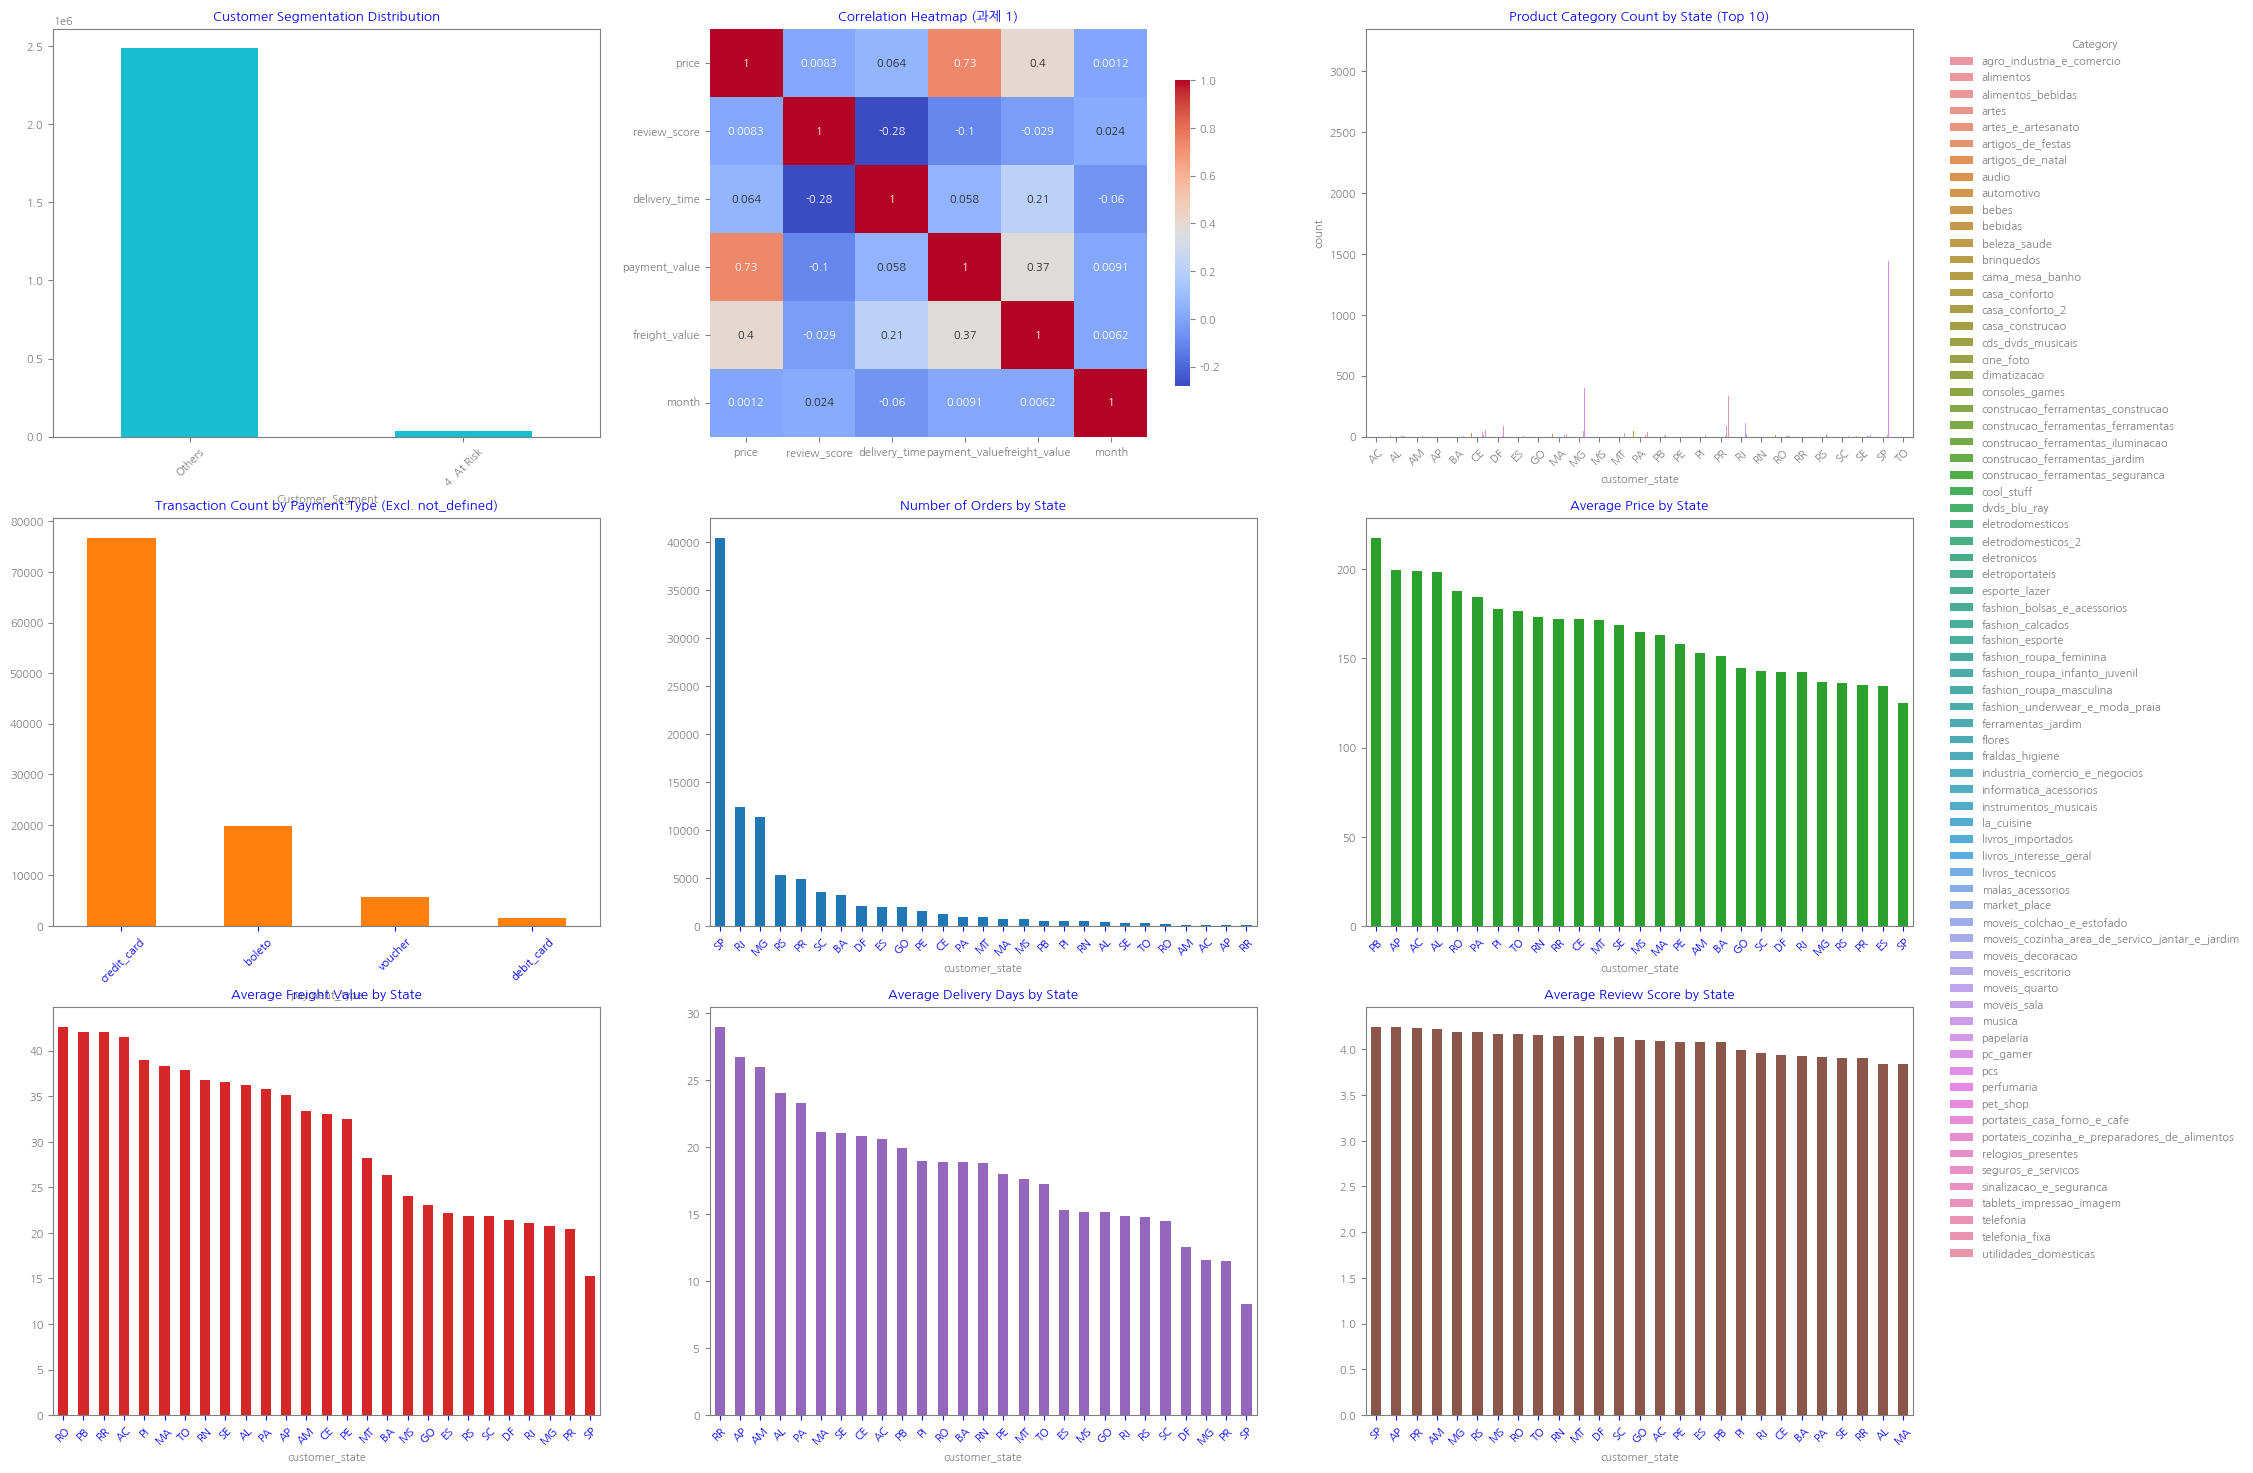

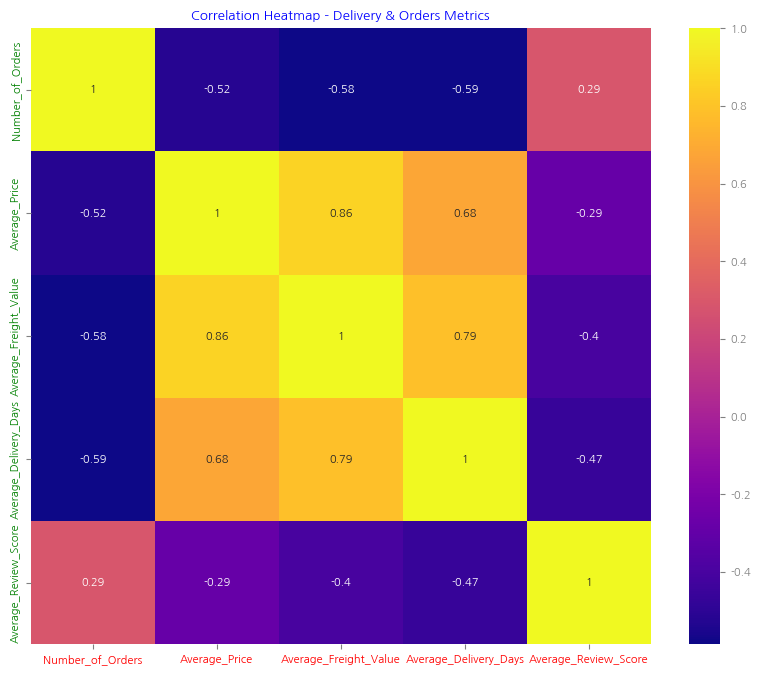


=== 비즈니스 권장사항 ===
1. 고객 관리: 'Champions' 세그먼트가 전체 고객의 0.0%를 차지합니다. 이들의 유지와 지속적 만족 관리가 중요합니다.
2. 'At Risk' 세그먼트는 0.0%로 재활성화 및 복구 프로그램 개발이 필요합니다.
3. 물류 개선 필요 지역: AC, AL, AM, AP, BA 에 배송 기간 최적화 및 인프라 개선 권장.
4. 고객 만족도 조사에서 3점 이하 평가가 22.9%로, 서비스 및 제품 품질 개선 필요.
5. 결제 유형 중 'not_defined' 제외 후 분석 시, 신뢰 가능한 결제 데이터 확보 필요성과 다양한 결제 수단 확대의 중요성 확인.
6. 상위 인기 상품 카테고리 및 계절성 패턴 기반 맞춤형 마케팅 및 재고 관리 전략 수립을 권장합니다.


In [116]:
# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results)
recommendations = generate_business_recommendations(results)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

In [117]:
# 통합 분석 실행
results_del_missing = integrated_ecommerce_analysis(
    orders_del_missing, customers, items, products, reviews, payments, category_translation
)

=== 과제 1: RFM 분석 및 고객 세분화 ===


/tmp/ipykernel_102/2332018189.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id']).agg({
/tmp/ipykernel_102/2332018189.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)


총 고객 수: 93,336
세그먼트별 분포:
Customer_Segment
Others        2482844
4. At Risk      37228
Name: count, dtype: int64

지역별 상위 5개 주:
customer_state
AC    93336
AL    93336
AM    93336
AP    93336
BA    93336
Name: count, dtype: int64

=== 과제 2: 배송 성과 분석 ===


/tmp/ipykernel_102/2332018189.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_delivery = delivery_analysis.groupby('customer_state').agg({
/tmp/ipykernel_102/2332018189.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pc_by_state_hist_data = pc_by_state.groupby(['customer_state','product_category_name']).size().reset_index(name='count')
/tmp/ipykernel_102/2332018189.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silen


=== 과제 3: 상품 카테고리별 수요 분석 ===
상위 10개 카테고리:
product_category_name_english
bed_bath_table           10952
health_beauty             9467
sports_leisure            8429
furniture_decor           8156
computers_accessories     7643
housewares                6795
watches_gifts             5857
telephony                 4428
garden_tools              4267
auto                      4139
Name: count, dtype: int64

월별 계절성 패턴 (상위 5개 카테고리):
product_category_name_english  bed_bath_table  health_beauty  sports_leisure  \
count                               12.000000      12.000000       12.000000   
mean                               912.666667     788.916667      702.416667   
std                                247.201182     289.017602      163.379346   
min                                528.000000     379.000000      453.000000   
25%                                768.250000     544.750000      568.750000   
50%                                984.000000     834.500000      750.000000   
75%   

/tmp/ipykernel_102/2332018189.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
/tmp/ipykernel_102/2332018189.py:182: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(['month', category_col]).size().unstack(fill_value=0)


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


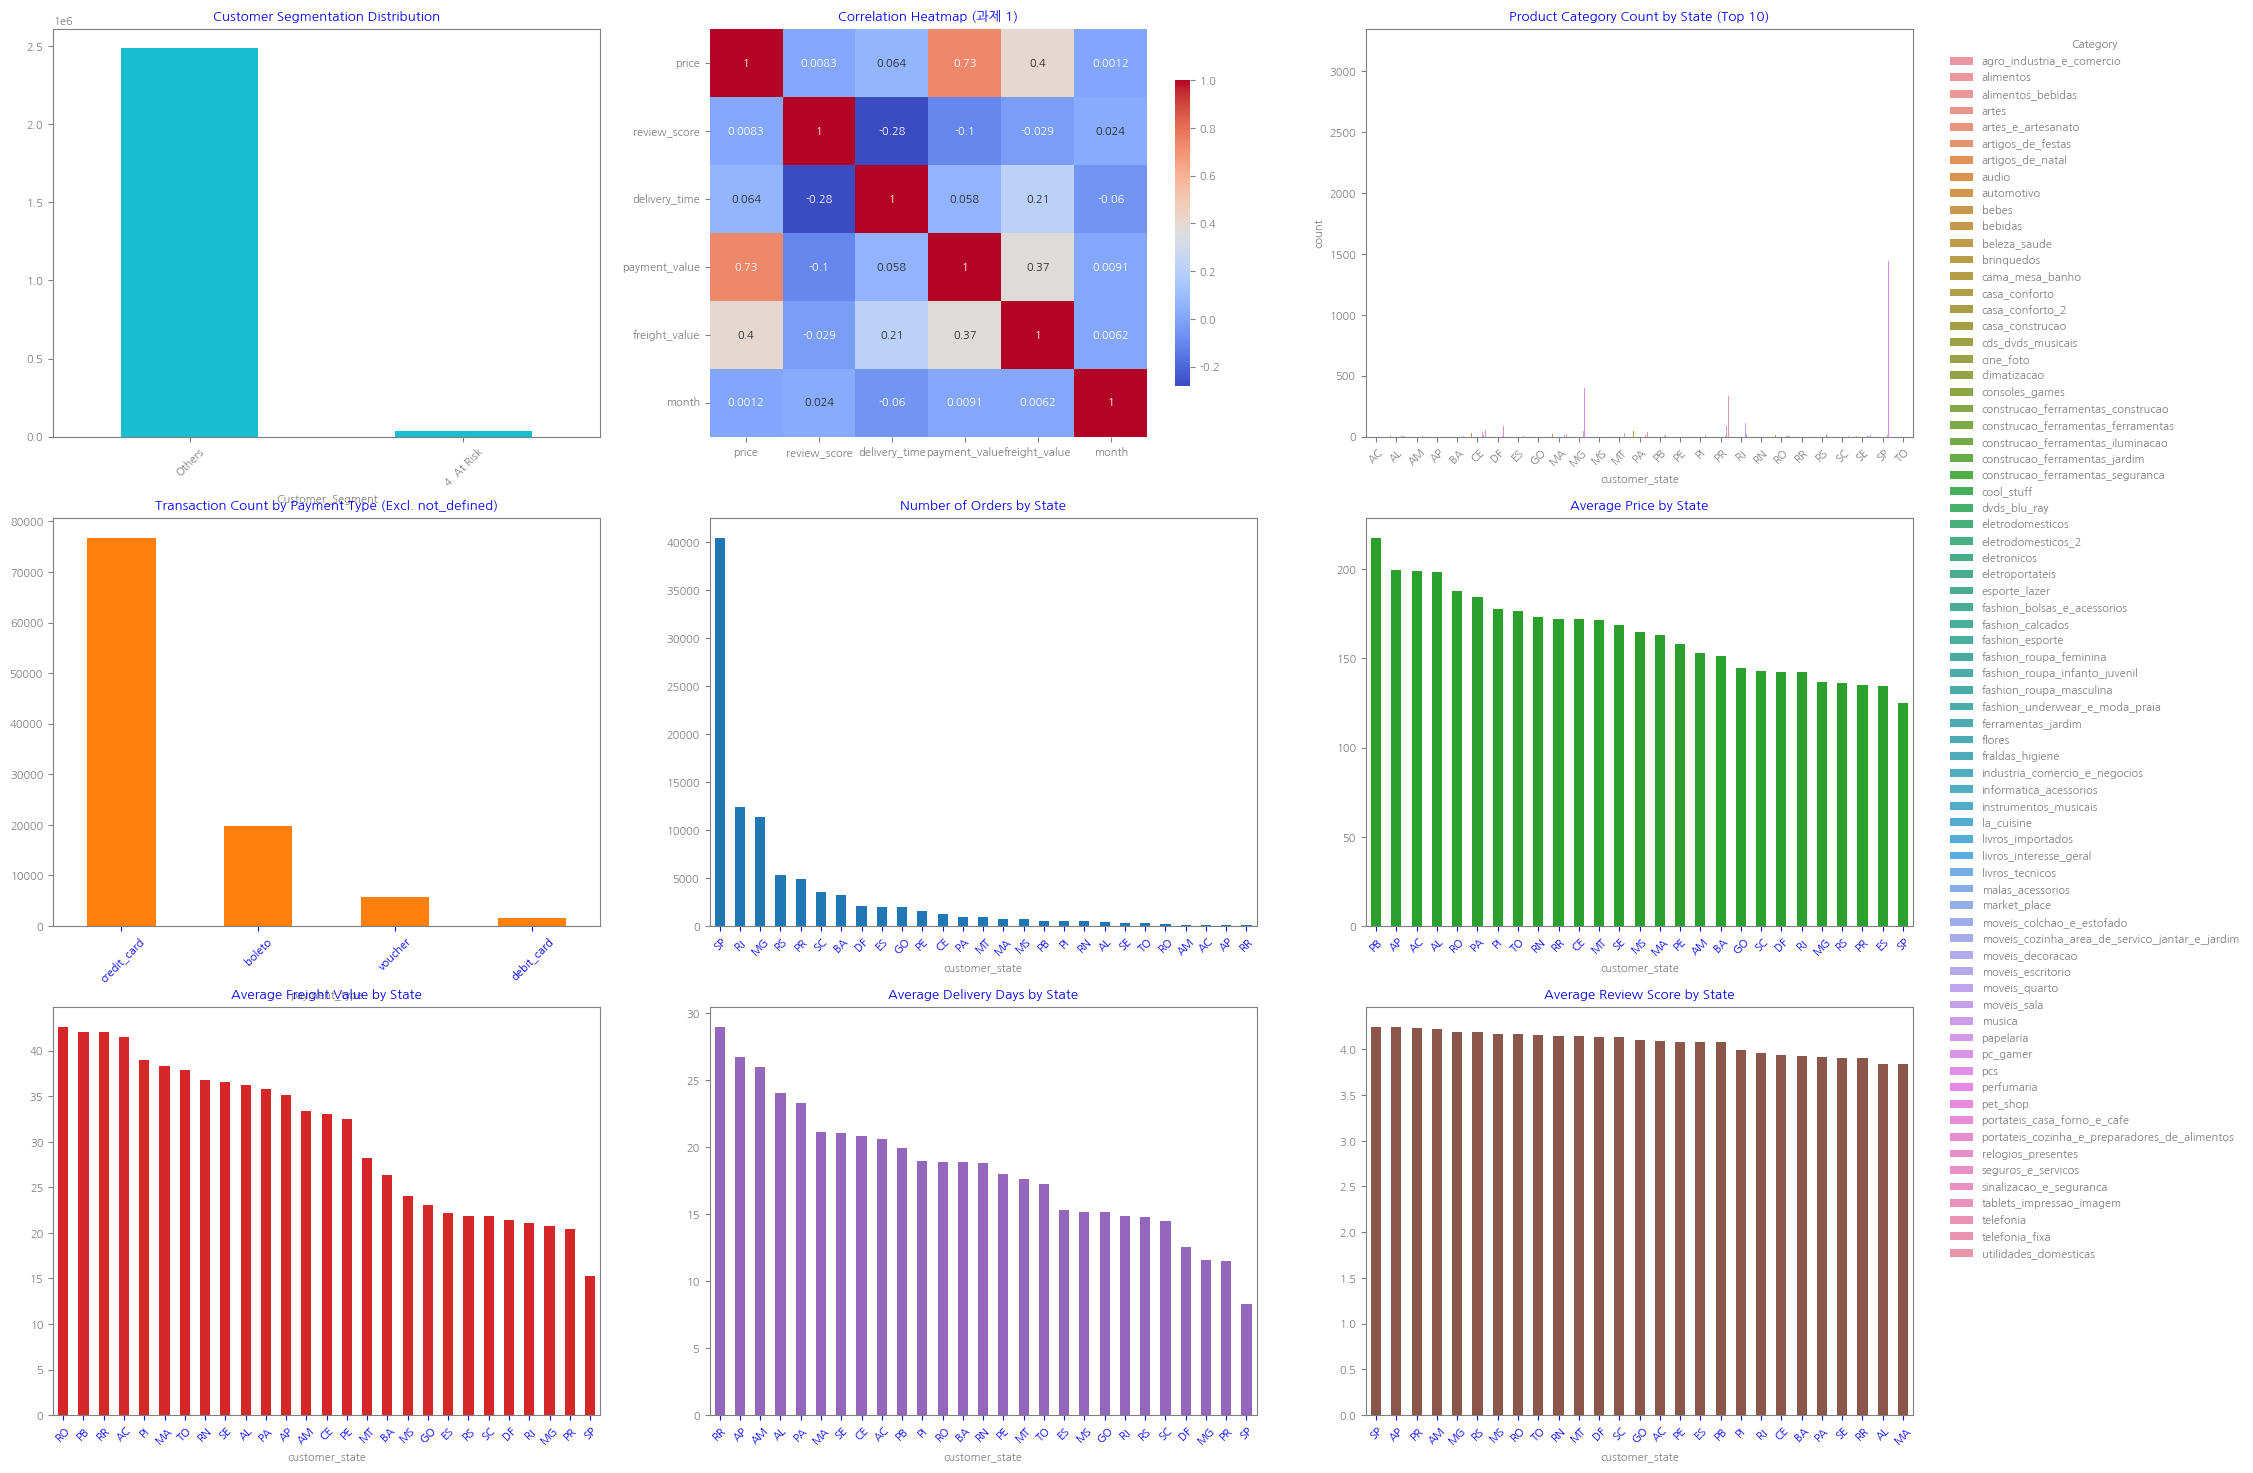

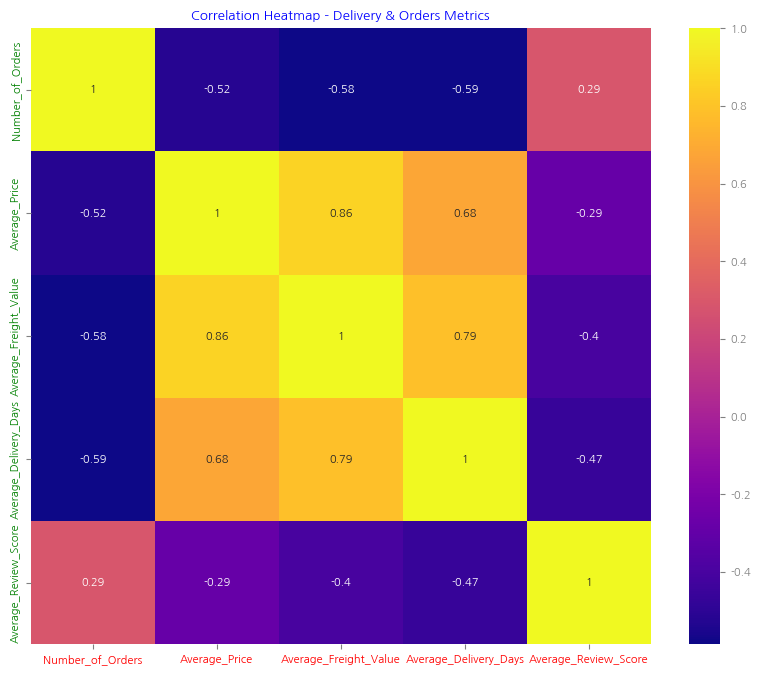


=== 비즈니스 권장사항 ===
1. 고객 관리: 'Champions' 세그먼트가 전체 고객의 0.0%를 차지합니다. 이들의 유지와 지속적 만족 관리가 중요합니다.
2. 'At Risk' 세그먼트는 0.0%로 재활성화 및 복구 프로그램 개발이 필요합니다.
3. 물류 개선 필요 지역: AC, AL, AM, AP, BA 에 배송 기간 최적화 및 인프라 개선 권장.
4. 고객 만족도 조사에서 3점 이하 평가가 22.9%로, 서비스 및 제품 품질 개선 필요.
5. 결제 유형 중 'not_defined' 제외 후 분석 시, 신뢰 가능한 결제 데이터 확보 필요성과 다양한 결제 수단 확대의 중요성 확인.
6. 상위 인기 상품 카테고리 및 계절성 패턴 기반 맞춤형 마케팅 및 재고 관리 전략 수립을 권장합니다.


In [118]:
# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results_del_missing)
recommendations = generate_business_recommendations(results_del_missing)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

In [119]:
def integrated_ecommerce_analysis(orders, customers, items, products, reviews, payments, category_translation):
    """
    브라질 이커머스 데이터 통합 분석 함수
    과제 1,2,3 및 자유주제 분석(확장) 포함
    """

    # === 기본 데이터 전처리 ===
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
    df = orders.merge(customers, on="customer_id").merge(items, on="order_id")
    df = df[df['order_status'] == 'delivered']
    snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
    df['month'] = df['order_purchase_timestamp'].dt.month

    # === 과제 1: RFM 분석 및 주문수/상관분석 포함 ===
    print("=== 과제 1: RFM 분석 및 상관분석 ===")
    rfm = df.groupby(['customer_state','customer_unique_id']).agg({
        'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    rfm.columns = ['customer_state', 'customer_unique_id', 'Recency', 'Frequency', 'Monetary']
    
    # RFM 점수 계산
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype('Int64')
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop').astype('Int64')
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, duplicates='drop').cat.codes + 1
    rfm['M_Score'] = rfm['M_Score'].astype('Int64')
    
    # 고객 세그먼트 정의
    def assign_customer_segment(row):
        if pd.isna(row['R_Score']) or pd.isna(row['F_Score']) or pd.isna(row['M_Score']):
            return 'Others'  # or some default segment for missing scores
        if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
            return '1. Champions'
        elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return '2. Loyal Customers'
        elif row['R_Score'] >= 3 and row['F_Score'] <= 2:
            return '3. Potential Loyalists'
        elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
            return '4. At Risk'
        elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
            return '5. Lost Customers'
        else:
            return 'Others'
    
    rfm['Customer_Segment'] = rfm.apply(assign_customer_segment, axis=1)
    segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)

    # 주문당 order_count(여기선 무조건 1이지만, 예시로 포함)
    order_count_df = df.groupby('order_id').size().reset_index(name='order_count')
    # 결제, 리뷰, 프라이스, 배송시간, 프라이트, month, 주문수량 합치기
    payment_agg = payments.groupby('order_id')['payment_value'].sum().reset_index()
    freq_val = df[['order_id','price','freight_value','month']].merge(
        reviews[['order_id','review_score']], on='order_id', how='left')
    freq_val = freq_val.merge(order_count_df, on='order_id', how='left')
    freq_val = freq_val.merge(payment_agg, on='order_id', how='left')
    delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
    delivered_orders['delivery_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days
    freq_val = freq_val.merge(delivered_orders[['order_id','delivery_time']], on='order_id', how='left')
    correlation_columns = ['price','review_score','delivery_time','payment_value','freight_value','month','order_count']
    correlation_df = freq_val[correlation_columns]
    total_orders_1 = df['order_id'].nunique()
    print(f'과제 1 - 총 주문 수량: {total_orders_1:,}')
    print('과제 1 주요변수들 상관관계:')
    print(correlation_df.corr())

    # === 과제 2: 배송 성과 분석 ===
    print("\n=== 과제 2: 배송 성과 분석 ===")
    delivery_analysis = orders[orders['order_status'] == 'delivered'].copy()
    delivery_analysis['delivery_time'] = (
        delivery_analysis['order_delivered_customer_date'] - delivery_analysis['order_purchase_timestamp']
    ).dt.days
    delivery_analysis['delivery_delay'] = (
        delivery_analysis['order_delivered_customer_date'] - delivery_analysis['order_estimated_delivery_date']
    ).dt.days
    # 고객 병합
    delivery_analysis = delivery_analysis.merge(
        customers[['customer_id', 'customer_state', 'customer_city']], on='customer_id')
    # price/freight join
    order_price = items.groupby('order_id')['price'].sum().reset_index()
    order_freight = items.groupby('order_id')['freight_value'].mean().reset_index()
    delivery_analysis = delivery_analysis.merge(order_price, on='order_id', how='left')
    delivery_analysis = delivery_analysis.merge(order_freight, on='order_id', how='left')
    # 집계 + 주문수 (평균과 총합)
    regional_delivery = delivery_analysis.groupby('customer_state').agg({
        'delivery_time': ['mean', 'median', 'std'],
        'delivery_delay': 'mean',
        'order_id': ['count','nunique'],
        'price':'mean',
        'freight_value':'mean'
    }).round(2)
    regional_delivery.columns = ['avg_delivery_days', 'median_delivery_days', 'std_delivery_days', 'avg_delay_days',
                                'order_count', 'unique_orders', 'avg_price', 'avg_freight_value']
    total_orders_2 = delivery_analysis['order_id'].nunique()
    avg_orders_2 = regional_delivery['unique_orders'].mean()
    print(f'과제 2 - 전국 총 배송 주문 수: {total_orders_2:,}')
    print(f'과제 2 - 지역별 평균 배송 주문 수: {avg_orders_2:.2f}')

    # 리뷰/지연 분석
    delivery_reviews = delivery_analysis.merge(
        reviews[['order_id', 'review_score']], on='order_id', how='left')
    delivery_reviews['late'] = delivery_reviews['delivery_delay'] > 0
    delay_review_score = delivery_reviews.groupby('review_score')['delivery_delay'].mean()
    late_pct_review = delivery_reviews.groupby('review_score')['late'].mean() * 100
    print('\n[평균 배송 지연 vs 리뷰 점수]')
    print(delay_review_score)
    print('\n[지연배송 비율 vs 리뷰 점수]')
    print(late_pct_review)
    # Product Category Name by State histogram
    pc_by_state = delivery_analysis.merge(items[['order_id','product_id']], on='order_id')\
        .merge(products[['product_id','product_category_name']], on='product_id')
    pc_by_state_hist_data = pc_by_state.groupby(['customer_state','product_category_name']).size().reset_index(name='count')
    # Payment Type distribution removing 'not_defined'
    payments_filtered = payments[payments['payment_type'] != 'not_defined']
    # Number of orders by State 등 등등
    orders_by_state = delivery_analysis.groupby('customer_state')['order_id'].count()
    avg_price_by_state = regional_delivery['avg_price']
    avg_freight_by_state = regional_delivery['avg_freight_value']
    avg_delivery_by_state = regional_delivery['avg_delivery_days']
    avg_review_by_state = delivery_reviews.groupby('customer_state')['review_score'].mean()
    # Correlation delivery variables heatmap
    corr_vars = pd.concat([
        orders_by_state, avg_price_by_state, avg_freight_by_state,
        avg_delivery_by_state, avg_review_by_state
    ], axis=1).dropna()
    corr_vars.columns = ['Number_of_Orders', 'Average_Price', 'Average_Freight_Value', 'Average_Delivery_Days', 'Average_Review_Score']

    # === 과제 3: 상품 카테고리별 수요 분석 ===
    print("\n=== 과제 3: 상품 카테고리별 수요 분석 ===")
    category_analysis = items.merge(products[['product_id', 'product_category_name']], on='product_id')
    category_analysis = category_analysis.merge(
        orders[['order_id', 'order_purchase_timestamp']], on='order_id')
    if 'product_category_name_english' in category_translation.columns:
        category_analysis = category_analysis.merge(
            category_translation, on='product_category_name', how='left')
        category_col = 'product_category_name_english'
    else:
        category_col = 'product_category_name'
    category_analysis['order_year_month'] = category_analysis['order_purchase_timestamp'].dt.to_period('M')
    monthly_category_sales = category_analysis.groupby(['order_year_month', category_col]).agg({
        'order_id': 'count',
        'price': 'sum'
    }).reset_index()
    monthly_category_sales.columns = ['month', 'category', 'order_count', 'revenue']
    top_categories = category_analysis[category_col].value_counts().head(10)
    category_analysis['month'] = category_analysis['order_purchase_timestamp'].dt.month
    seasonal_pattern = category_analysis[
        category_analysis[category_col].isin(top_categories.index)
    ].groupby(['month', category_col]).size().unstack(fill_value=0)
    print(f"상위 10개 카테고리:")
    print(top_categories)
    print(f"\n월별 계절성 패턴 (상위 5개 카테고리):")
    print(seasonal_pattern[top_categories.head().index].describe())

    # === 자유 주제: 비즈니스 분석 ===
    print("\n=== 자유 주제: 종합 비즈니스 분석 ===")
    business_summary = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).agg({
        'order_id': 'nunique',
        'customer_unique_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    business_summary.columns = ['month', 'total_orders', 'unique_customers', 'total_revenue']
    business_summary['avg_order_value'] = business_summary['total_revenue'] / business_summary['total_orders']
    payment_analysis = payments_filtered.groupby('payment_type').agg({
        'payment_value': ['count', 'sum', 'mean']
    }).round(2)
    payment_analysis.columns = ['transaction_count', 'total_value', 'avg_value']
    satisfaction_summary = reviews.groupby('review_score').size().reset_index(name='count')
    satisfaction_summary['percentage'] = (satisfaction_summary['count'] / satisfaction_summary['count'].sum() * 100).round(1)
    print(f"전체 기간 총 주문: {business_summary['total_orders'].sum():,}")
    print(f"전체 기간 총 매출: R$ {business_summary['total_revenue'].sum():,.2f}")
    print(f"평균 주문 가격: R$ {business_summary['avg_order_value'].mean():.2f}")
    print(f"평균 고객 만족도: {reviews['review_score'].mean():.2f}/5")
    print(f"\n결제 방법별 분석 (\'not_defined\' 제외):")
    print(payment_analysis.sort_values('total_value', ascending=False))

    results = {
        'rfm_analysis': rfm,
        'segment_by_region': segment_by_region,
        'correlation_df': correlation_df,
        'delivery_performance': regional_delivery,
        'delivery_review_impact': delay_review_score,
        'late_pct_review': late_pct_review,
        'pc_by_state_hist_data': pc_by_state_hist_data,
        'payments_filtered': payments_filtered,
        'orders_by_state': orders_by_state,
        'avg_price_by_state': avg_price_by_state,
        'avg_freight_by_state': avg_freight_by_state,
        'avg_delivery_by_state': avg_delivery_by_state,
        'avg_review_by_state': avg_review_by_state,
        'delivery_corr_vars': corr_vars,
        'category_monthly_sales': monthly_category_sales,
        'seasonal_patterns': seasonal_pattern,
        'business_summary': business_summary,
        'payment_analysis': payment_analysis,
        'satisfaction_summary': satisfaction_summary
    }
    return results

def create_comprehensive_visualizations(results):
    plt.rcParams['text.color'] = 'gray'
    plt.rcParams['axes.labelcolor'] = 'gray'
    plt.rcParams['xtick.color'] = 'gray'
    plt.rcParams['ytick.color'] = 'gray'
    plt.rcParams['axes.edgecolor'] = 'gray'
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    results['rfm_analysis']['Customer_Segment'].value_counts().plot(kind='bar', ax=axes[0,0], color='tab:cyan')
    axes[0,0].set_title('Customer Segmentation Distribution', color='blue')
    axes[0,0].tick_params(axis='x', rotation=45, colors='gray')
    sns.heatmap(results['correlation_df'].corr(), annot=True, cmap='coolwarm', ax=axes[0,1], cbar_kws={"shrink": 0.75})
    axes[0,1].set_title('Correlation Heatmap (과제 1)', color='blue')
    top_categories = results['pc_by_state_hist_data']['product_category_name'].value_counts().head(10).index
    data_plot = results['pc_by_state_hist_data'][results['pc_by_state_hist_data']['product_category_name'].isin(top_categories)]
    sns.barplot(data=data_plot, x='customer_state', y='count', hue='product_category_name', ax=axes[0,2])
    axes[0,2].set_title('Product Category Count by State (Top 10)', color='blue')
    axes[0,2].tick_params(axis='x', rotation=45, colors='gray')
    axes[0,2].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    payment_data = results['payments_filtered']['payment_type'].value_counts()
    payment_data.plot(kind='bar', ax=axes[1,0], color='tab:orange')
    axes[1,0].set_title('Transaction Count by Payment Type (Excl. not_defined)', color='blue')
    axes[1,0].tick_params(axis='x', rotation=45, colors='gray')
    results['orders_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,1], color='tab:blue')
    axes[1,1].set_title('Number of Orders by State', color='blue')
    axes[1,1].tick_params(axis='x', rotation=45, colors='gray')
    results['avg_price_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,2], color='tab:green')
    axes[1,2].set_title('Average Price by State', color='blue')
    axes[1,2].tick_params(axis='x', rotation=45, colors='gray')
    results['avg_freight_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,0], color='tab:red')
    axes[2,0].set_title('Average Freight Value by State', color='blue')
    axes[2,0].tick_params(axis='x', rotation=45, colors='gray')
    results['avg_delivery_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,1], color='tab:purple')
    axes[2,1].set_title('Average Delivery Days by State', color='blue')
    axes[2,1].tick_params(axis='x', rotation=45, colors='gray')
    results['avg_review_by_state'].sort_values(ascending=False).plot(kind='bar', ax=axes[2,2], color='tab:brown')
    axes[2,2].set_title('Average Review Score by State', color='blue')
    axes[2,2].tick_params(axis='x', rotation=45, colors='gray')
    plt.tight_layout()
    # Change x-axis tick label colors
    plt.setp(plt.gca().get_xticklabels(), color='red') 
    # Change y-axis tick label colors
    plt.setp(plt.gca().get_yticklabels(), color='green')  
    plt.show()
    # 히트맵
    plt.figure(figsize=(8,6))
    sns.heatmap(results['correlation_df'].corr(), annot=True, cmap='coolwarm')
    plt.title("[과제 1] Variables Correlation with order count included", color='blue')
    plt.show()
    plt.figure(figsize=(8,6))
    sns.heatmap(results['correlation_df'].corr(method='spearman'), annot=True, cmap='coolwarm')
    plt.title("[과제 1] Variables Correlation with order count included(Spearman)", color='blue')
    plt.show()
    plt.figure(figsize=(8,6))
    sns.heatmap(results['correlation_df'].corr(method='kendall'), annot=True, cmap='coolwarm')
    plt.title("[과제 1] Variables Correlation with order count included(Kendall)", color='blue')
    plt.show()
    plt.figure(figsize=(8,5))
    results['delivery_review_impact'].plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel("Review Score")
    plt.ylabel("Average Delivery Delay (days)")
    plt.title("Average Delivery Delay by Review Score", color='blue')
    plt.show()
    plt.figure(figsize=(8,5))
    results['late_pct_review'].plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel("Review Score")
    plt.ylabel("Percentage of Late Orders (%)")
    plt.title("Percentage of Late Orders by Review Score", color='blue')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.heatmap(results['delivery_corr_vars'].corr(), annot=True, cmap='plasma')
    plt.title('Correlation Heatmap - Delivery & Orders Metrics', color='blue')
    plt.tick_params(colors='gray')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.heatmap(results['delivery_corr_vars'].corr(method='spearman'), annot=True, cmap='plasma')
    plt.title('Correlation Heatmap - Delivery & Orders Metrics(Spearman)', color='blue')
    plt.tick_params(colors='gray')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.heatmap(results['delivery_corr_vars'].corr(method='kendall'), annot=True, cmap='plasma')
    plt.title('Correlation Heatmap - Delivery & Orders Metrics(Kendall)', color='blue')
    plt.tick_params(colors='gray')
    # Change x-axis tick label colors
    plt.setp(plt.gca().get_xticklabels(), color='red') 
    # Change y-axis tick label colors
    plt.setp(plt.gca().get_yticklabels(), color='green')  
    plt.show()

def generate_business_recommendations(results):
    recommendations = []
    champions_pct = (results['rfm_analysis']['Customer_Segment'] == '1. Champions').mean() * 100
    at_risk_pct = (results['rfm_analysis']['Customer_Segment'] == '4. At Risk').mean() * 100
    recommendations.append(f"고객 관리: 'Champions' 세그먼트가 전체 고객의 {champions_pct:.1f}%를 차지합니다. 이들의 유지와 지속적 만족 관리가 중요합니다.")
    recommendations.append(f"'At Risk' 세그먼트는 {at_risk_pct:.1f}%로 재활성화 및 복구 프로그램 개발이 필요합니다.")
    slow_delivery_states = results['delivery_performance'][
        results['delivery_performance']['avg_delivery_days'] > results['delivery_performance']['avg_delivery_days'].mean()
    ].index[:5].tolist()
    recommendations.append(f"물류 개선 필요 지역: {', '.join(slow_delivery_states)} 에 배송 기간 최적화 및 인프라 개선 권장.")
    low_satisfaction_pct = results['satisfaction_summary'][
        results['satisfaction_summary']['review_score'] <= 3
    ]['percentage'].sum()
    recommendations.append(f"고객 만족도 조사에서 3점 이하 평가가 {low_satisfaction_pct:.1f}%로, 서비스 및 제품 품질 개선 필요.")
    recommendations.append("결제 유형 중 'not_defined' 제외 후 분석 시, 신뢰 가능한 결제 데이터 확보 필요성과 다양한 결제 수단 확대의 중요성 확인.")
    recommendations.append("상위 인기 상품 카테고리 및 계절성 패턴 기반 맞춤형 마케팅 및 재고 관리 전략 수립을 권장합니다.")
    return recommendations


In [120]:
# 통합 분석 실행
results_del_missing = integrated_ecommerce_analysis(
    orders_del_missing, customers, items, products, reviews, payments, category_translation
)

=== 과제 1: RFM 분석 및 상관분석 ===


/tmp/ipykernel_102/2086528310.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby(['customer_state','customer_unique_id']).agg({
/tmp/ipykernel_102/2086528310.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_by_region = rfm.groupby(['customer_state', 'Customer_Segment']).size().unstack(fill_value=0)


과제 1 - 총 주문 수량: 96,455
과제 1 주요변수들 상관관계:
                  price  review_score  delivery_time  payment_value  \
price          1.000000      0.003256       0.062246       0.758473   
review_score   0.003256      1.000000      -0.304073      -0.083368   
delivery_time  0.062246     -0.304073       1.000000       0.062708   
payment_value  0.758473     -0.083368       0.062708       1.000000   
freight_value  0.412891     -0.032888       0.214669       0.384490   
month          0.002072      0.030403      -0.057075       0.006146   
order_count   -0.075094     -0.174162      -0.020431       0.337841   

               freight_value     month  order_count  
price               0.412891  0.002072    -0.075094  
review_score       -0.032888  0.030403    -0.174162  
delivery_time       0.214669 -0.057075    -0.020431  
payment_value       0.384490  0.006146     0.337841  
freight_value       1.000000  0.005883    -0.034612  
month               0.005883  1.000000    -0.000931  
order_count  

/tmp/ipykernel_102/2086528310.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regional_delivery = delivery_analysis.groupby('customer_state').agg({
/tmp/ipykernel_102/2086528310.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pc_by_state_hist_data = pc_by_state.groupby(['customer_state','product_category_name']).size().reset_index(name='count')


과제 2 - 전국 총 배송 주문 수: 96,455
과제 2 - 지역별 평균 배송 주문 수: 3572.41

[평균 배송 지연 vs 리뷰 점수]
review_score
1.0    -4.048060
2.0    -8.624830
3.0   -10.775754
4.0   -12.378549
5.0   -13.387029
Name: delivery_delay, dtype: float64

[지연배송 비율 vs 리뷰 점수]
review_score
1.0    36.618820
2.0    18.911565
3.0     8.756281
4.0     3.434652
5.0     1.856266
Name: late, dtype: float64

=== 과제 3: 상품 카테고리별 수요 분석 ===


/tmp/ipykernel_102/2086528310.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_by_state = delivery_analysis.groupby('customer_state')['order_id'].count()
/tmp/ipykernel_102/2086528310.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_review_by_state = delivery_reviews.groupby('customer_state')['review_score'].mean()
/tmp/ipykernel_102/2086528310.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mo

상위 10개 카테고리:
product_category_name_english
bed_bath_table           10952
health_beauty             9467
sports_leisure            8429
furniture_decor           8156
computers_accessories     7643
housewares                6795
watches_gifts             5857
telephony                 4428
garden_tools              4267
auto                      4139
Name: count, dtype: int64

월별 계절성 패턴 (상위 5개 카테고리):
product_category_name_english  bed_bath_table  health_beauty  sports_leisure  \
count                               12.000000      12.000000       12.000000   
mean                               912.666667     788.916667      702.416667   
std                                247.201182     289.017602      163.379346   
min                                528.000000     379.000000      453.000000   
25%                                768.250000     544.750000      568.750000   
50%                                984.000000     834.500000      750.000000   
75%                               11

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


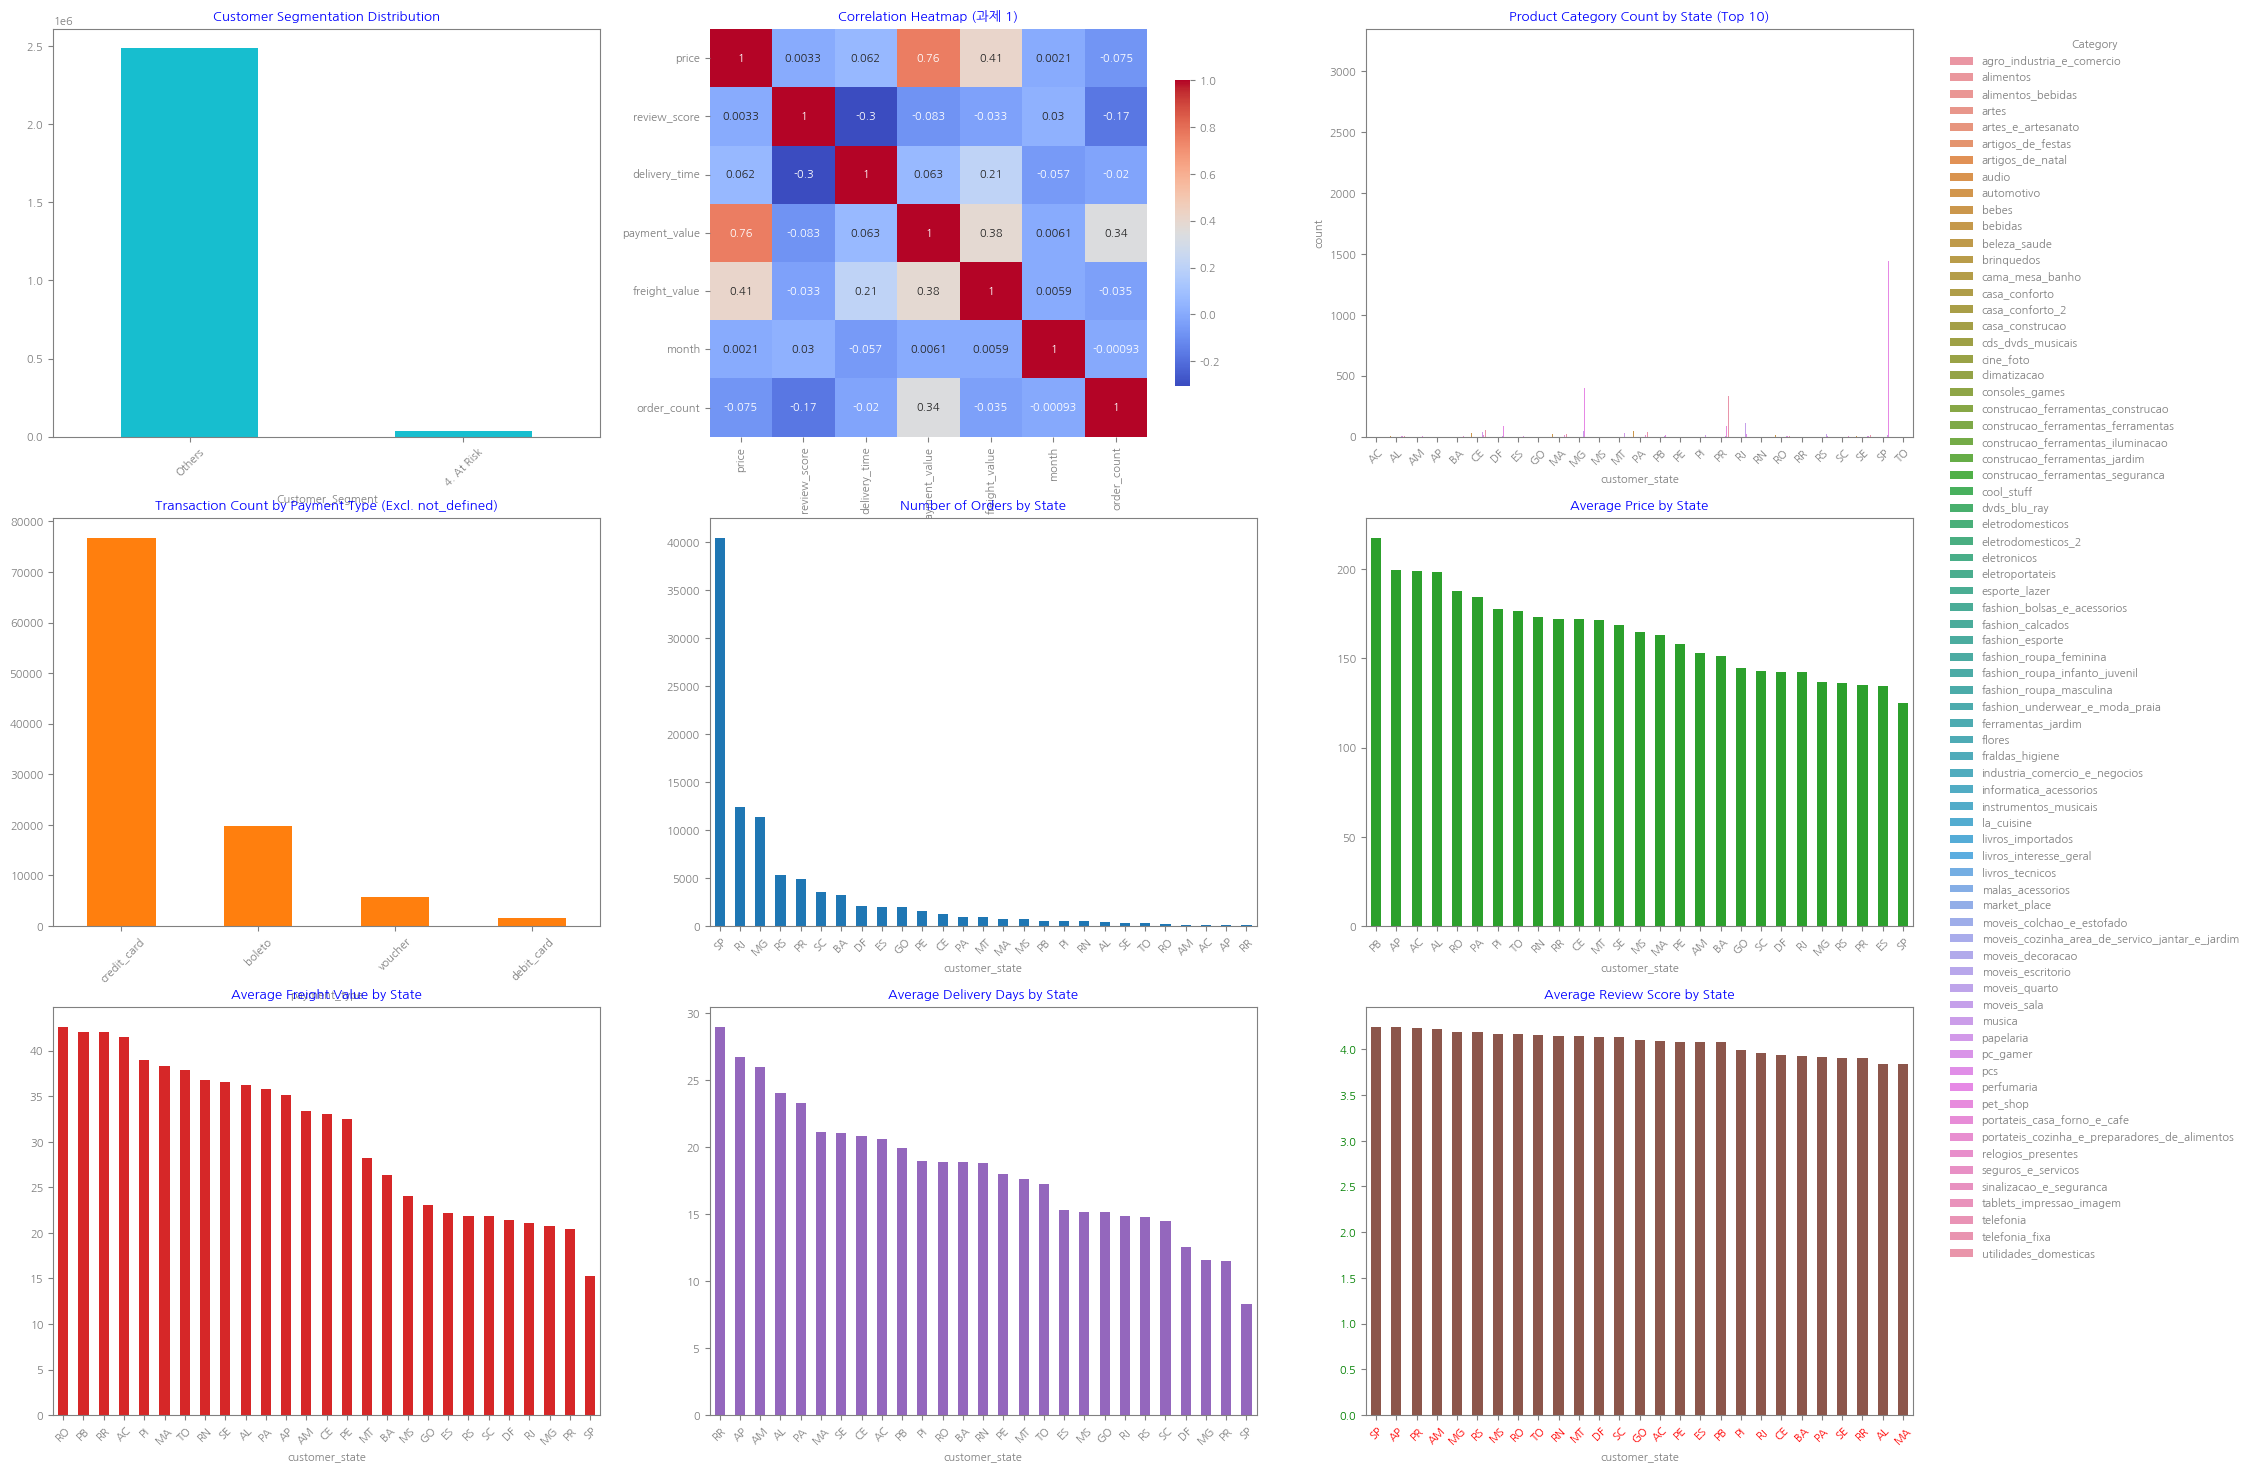

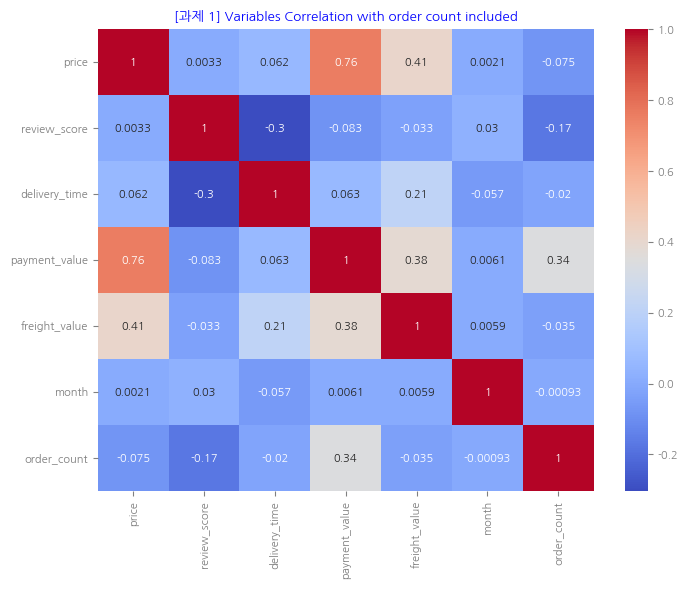

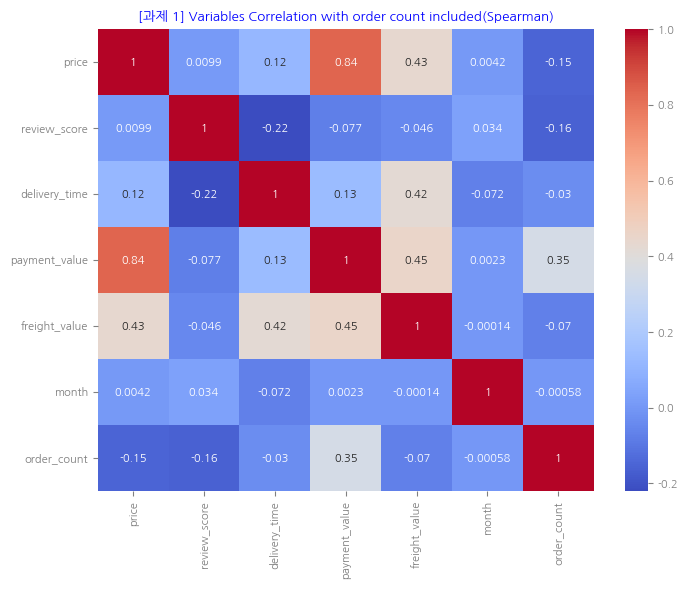

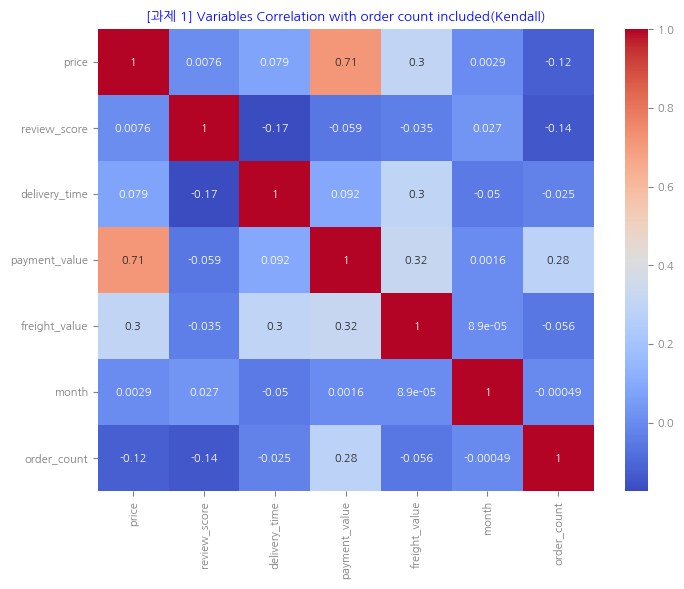

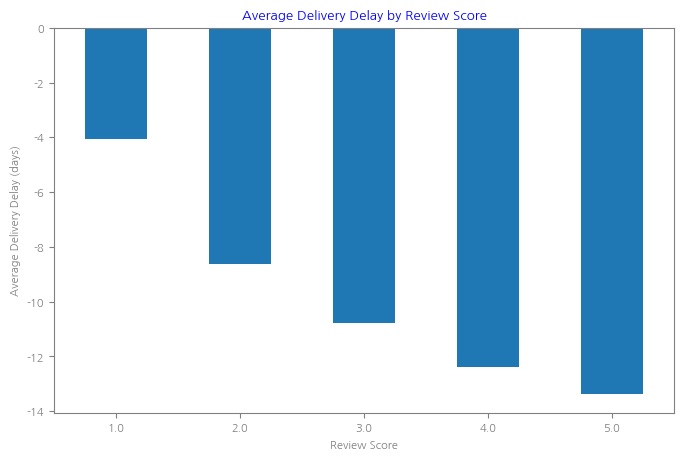

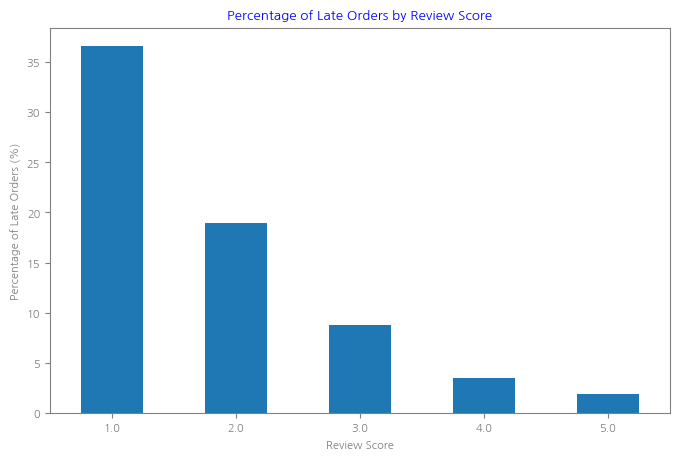

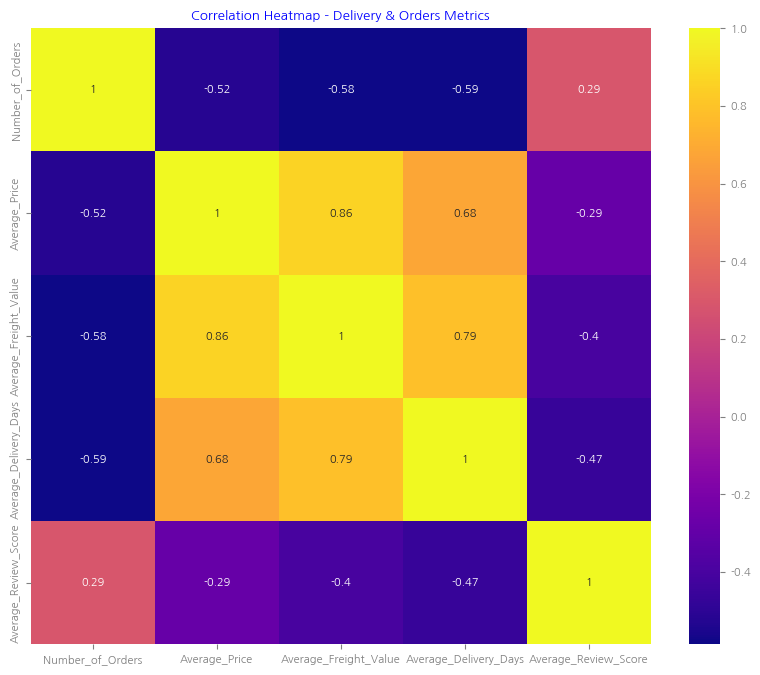

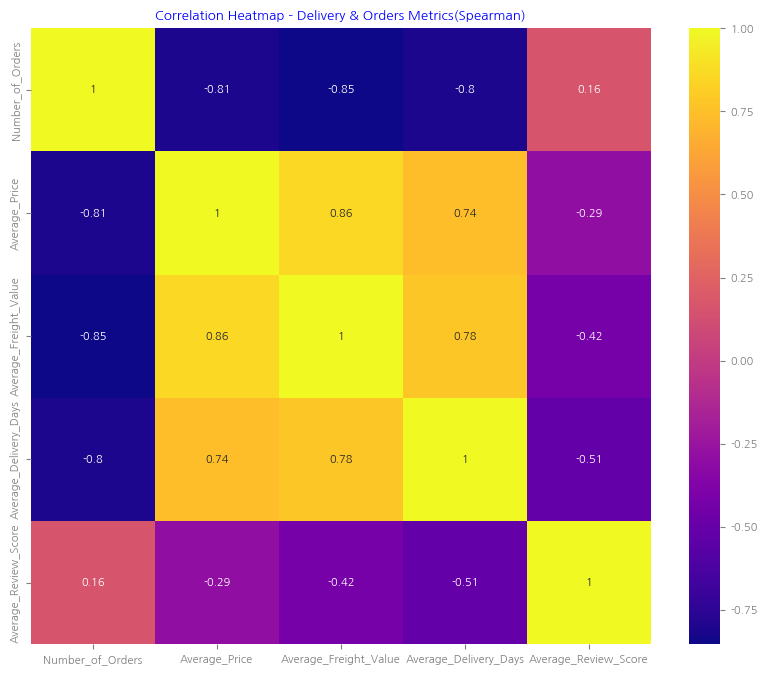

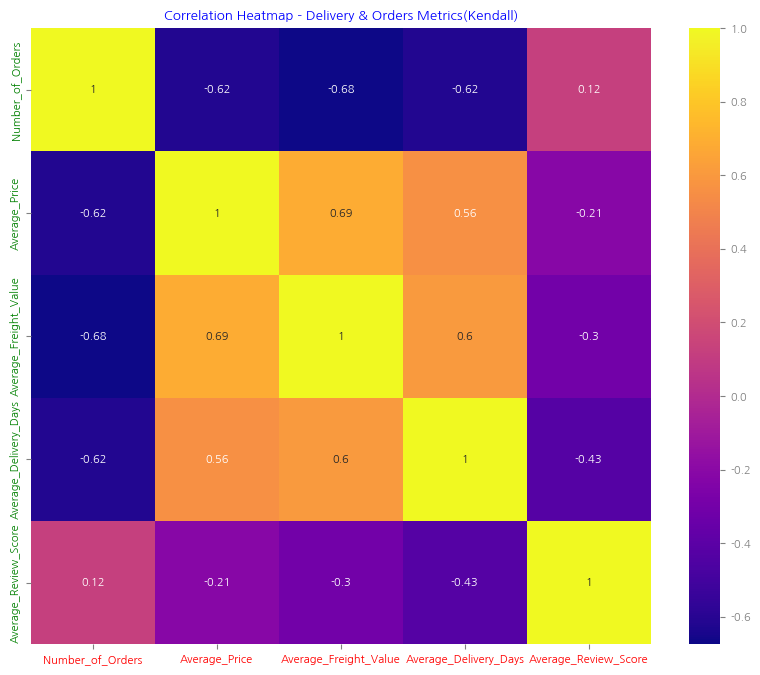


=== 비즈니스 권장사항 ===
1. 고객 관리: 'Champions' 세그먼트가 전체 고객의 0.0%를 차지합니다. 이들의 유지와 지속적 만족 관리가 중요합니다.
2. 'At Risk' 세그먼트는 1.5%로 재활성화 및 복구 프로그램 개발이 필요합니다.
3. 물류 개선 필요 지역: AC, AL, AM, AP, BA 에 배송 기간 최적화 및 인프라 개선 권장.
4. 고객 만족도 조사에서 3점 이하 평가가 22.9%로, 서비스 및 제품 품질 개선 필요.
5. 결제 유형 중 'not_defined' 제외 후 분석 시, 신뢰 가능한 결제 데이터 확보 필요성과 다양한 결제 수단 확대의 중요성 확인.
6. 상위 인기 상품 카테고리 및 계절성 패턴 기반 맞춤형 마케팅 및 재고 관리 전략 수립을 권장합니다.


In [121]:
# 시각화 및 권장사항 생성
create_comprehensive_visualizations(results_del_missing)
recommendations = generate_business_recommendations(results_del_missing)

print("\n=== 비즈니스 권장사항 ===")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

# NLP Task

In [4]:
# Install transformers and datasets (if not installed)
!pip install transformers datasets --quiet

In [122]:

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# 1. Load Review Data (assuming your CSV is available at this path)
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')

# (Optional) If too large, sample or filter data:
# df = df.sample(n=5000, random_state=42)

# 2. Preprocess: Use review_comment_message, remove nulls, keep only Portuguese
reviews = reviews.dropna(subset=['review_comment_message', 'review_score'])
texts = reviews['review_comment_message'].astype(str).tolist()
labels = reviews['review_score'].astype(int) - 1  # to make labels 0-based (i.e., 0-4)

# Use only message for model input (title is mostly null)
model_ckpt = "nlptown/bert-base-multilingual-uncased-sentiment"



In [6]:
# average length of comment messages
for i in range(5):
    print(i+1 , reviews[reviews['review_score']==int(f'{i+1}')]['review_comment_message'].str.len().mean())

1 99.94190966266439
2 96.84568764568765
3 83.33174023053135
4 61.73360107095047
5 51.83949596185657


In [7]:
# 3. Train/Val split
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Prepare HuggingFace datasets
train_ds = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_ds = Dataset.from_dict({'text': val_texts, 'label': val_labels})



In [8]:
# 4. Tokenization
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)



tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/32781 [00:00<?, ? examples/s]

Map:   0%|          | 0/8196 [00:00<?, ? examples/s]

In [9]:
!pip install peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [10]:
# 5. Load pre-trained Portuguese model for classification
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, IntervalStrategy


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # For sequence classification tasks
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
model = get_peft_model(model, lora_config)


PATH = '/kaggle/input/brazilian-review-bert/pytorch/default/1/brazilian_ecommerce.pth'
state_dict = torch.load(PATH)
# Load the state dictionary into the model
model.load_state_dict(state_dict)


# 6. Define Trainer arguments
training_args = TrainingArguments(
    output_dir="./bert-olist",
    eval_strategy=IntervalStrategy.EPOCH,  # Evaluate after each epoch
    save_strategy=IntervalStrategy.NO, 
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    logging_steps=100,
    fp16=True,
    report_to='none',
    load_best_model_at_end=False
)
# 7. Define Trainer and metrics
from transformers import TrainerCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     compute_metrics=compute_metrics,
#     tokenizer=tokenizer
# )


class TrainMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Run prediction on the training dataset to get logits and labels
        train_preds_output = trainer.predict(train_ds)
        train_preds = train_preds_output.predictions.argmax(axis=-1)
        train_labels = train_preds_output.label_ids

        # Compute metrics
        precision, recall, f1, _ = precision_recall_fscore_support(train_labels, train_preds, average='weighted', zero_division=0)
        acc = accuracy_score(train_labels, train_preds)

        # Log metrics to Trainer's log history
        logs = {
            "train_accuracy": acc,
            "train_precision": precision,
            "train_recall": recall,
            "train_f1": f1,
        }
        
        # Use Trainer's internal method to add logs for this epoch
        trainer.log(logs)

# Add this callback when defining Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[TrainMetricsCallback]  # Add the callback here
)



model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

/tmp/ipykernel_102/4287771755.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
# 8. Train (may take a while: adjust epochs/sample size if needed)
# trainer.train()

# 9. Evaluate
eval_results = trainer.evaluate()
print("Dev set accuracy:", eval_results)

# 10. Classification report (optional, for detailed metrics)
preds = trainer.predict(val_ds).predictions.argmax(axis=-1)
print(classification_report(val_labels, preds, digits=3))


Dev set accuracy: {'eval_loss': 0.8622729778289795, 'eval_accuracy': 0.6871644704734017, 'eval_precision': 0.6074936046709729, 'eval_recall': 0.6871644704734017, 'eval_f1': 0.617469504563646, 'eval_runtime': 30.7614, 'eval_samples_per_second': 266.438, 'eval_steps_per_second': 1.073}
              precision    recall  f1-score   support

           0      0.646     0.870     0.741      1749
           1      0.250     0.007     0.014       429
           2      0.318     0.156     0.209       712
           3      0.362     0.088     0.141      1195
           4      0.750     0.946     0.837      4111

    accuracy                          0.687      8196
   macro avg      0.465     0.413     0.388      8196
weighted avg      0.607     0.687     0.617      8196



In [12]:
!pwd

/kaggle/working


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
# torch.save(model.state_dict(), 'brazilian_ecommerce.pth')

In [ ]:
for entry in trainer.state.log_history:
    print(entry)

{'eval_loss': 0.8622729778289795, 'eval_accuracy': 0.6871644704734017, 'eval_precision': 0.6074936046709729, 'eval_recall': 0.6871644704734017, 'eval_f1': 0.617469504563646, 'eval_runtime': 30.7614, 'eval_samples_per_second': 266.438, 'eval_steps_per_second': 1.073, 'step': 0}


In [ ]:
# # Convert log_history to DataFrame for easy grouping
# logs = pd.DataFrame(trainer.state.log_history)

# # For eval metrics: take the last entry per epoch
# eval_metrics = logs.dropna(subset=['eval_loss'])  # filter only eval rows
# eval_epoch_grouped = eval_metrics.groupby('epoch').last()

# # For training metrics (loss): average over steps in each epoch
# train_metrics = logs.dropna(subset=['loss'])  # filter only training rows
# train_epoch_grouped = train_metrics.groupby('epoch').mean()

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))
# plt.plot(eval_epoch_grouped.index, eval_epoch_grouped['eval_loss'], label='Eval Loss')
# plt.plot(train_epoch_grouped.index, train_epoch_grouped['loss'], label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training & Eval Loss per Epoch')
# plt.legend()
# plt.grid()
# plt.show()

# # Repeat for accuracy, precision, recall, f1 if present in log_history

In [ ]:
def plot_metrics(training_logs):
    logs = training_logs if isinstance(training_logs, list) else training_logs.get('log_history', [])

    # Store metric values and the corresponding epoch for each kind
    train_epochs, train_acc, train_prec, train_rec, train_f1 = [], [], [], [], []
    eval_epochs, eval_acc, eval_prec, eval_rec, eval_f1 = [], [], [], [], []

    for log in logs:
        if 'epoch' in log:
            # Training metrics
            if all(m in log for m in ['train_accuracy','train_precision','train_recall','train_f1']):
                train_epochs.append(log['epoch'])
                train_acc.append(log['train_accuracy'])
                train_prec.append(log['train_precision'])
                train_rec.append(log['train_recall'])
                train_f1.append(log['train_f1'])
            # Eval metrics
            if all(m in log for m in ['eval_accuracy','eval_precision','eval_recall','eval_f1']):
                eval_epochs.append(log['epoch'])
                eval_acc.append(log['eval_accuracy'])
                eval_prec.append(log['eval_precision'])
                eval_rec.append(log['eval_recall'])
                eval_f1.append(log['eval_f1'])
    
    plt.figure(figsize=(12, 8))
    plt.plot(train_epochs, train_acc, label='Train Accuracy')
    plt.plot(eval_epochs, eval_acc, label='Eval Accuracy')
    plt.plot(train_epochs, train_prec, label='Train Precision', linestyle='--')
    plt.plot(eval_epochs, eval_prec, label='Eval Precision', linestyle='--')
    plt.plot(train_epochs, train_rec, label='Train Recall', linestyle='-.')
    plt.plot(eval_epochs, eval_rec, label='Eval Recall', linestyle='-.')
    plt.plot(train_epochs, train_f1, label='Train F1 Score', linestyle=':')
    plt.plot(eval_epochs, eval_f1, label='Eval F1 Score', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Training and Evaluation Metrics per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_loss(training_logs):
    logs = training_logs if isinstance(training_logs, list) else training_logs.get('log_history', [])

    train_epochs, train_loss = [], []
    eval_epochs, eval_loss = [], []

    for log in logs:
        if 'epoch' in log:
            if 'loss' in log:
                train_epochs.append(log['epoch'])
                train_loss.append(log['loss'])
            elif 'eval_loss' in log:
                eval_epochs.append(log['epoch'])
                eval_loss.append(log['eval_loss'])
    
    plt.figure(figsize=(8,5))
    plt.plot(train_epochs, train_loss, label='Train Loss')
    plt.plot(eval_epochs, eval_loss, label='Eval Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# plot_metrics(trainer.state.log_history)
#     # print(epochs, train_acc, train_prec, train_rec, train_f1, eval_acc, eval_prec, eval_rec, eval_f1)

In [ ]:
# plot_loss(trainer.state.log_history)

In [ ]:
def plot_metrics(training_logs):
    logs = training_logs if isinstance(training_logs, list) else training_logs.get('log_history', [])

    epochs = []
    eval_acc = []
    eval_prec = []
    eval_rec = []
    eval_f1 = []

    for log in logs:
        if 'epoch' in log:
            epoch = log['epoch']
            if epoch not in epochs:
                epochs.append(epoch)

            if 'eval_accuracy' in log:
                eval_acc.append(log['eval_accuracy'])
            if 'eval_precision' in log:
                eval_prec.append(log['eval_precision'])
            if 'eval_recall' in log:
                eval_rec.append(log['eval_recall'])
            if 'eval_f1' in log:
                eval_f1.append(log['eval_f1'])

    plt.figure(figsize=(12, 8))
    plt.plot(epochs[:len(eval_acc)], eval_acc, label='Eval Accuracy')
    plt.plot(epochs[:len(eval_prec)], eval_prec, label='Eval Precision', linestyle='--')
    plt.plot(epochs[:len(eval_rec)], eval_rec, label='Eval Recall', linestyle='-.')
    plt.plot(epochs[:len(eval_f1)], eval_f1, label='Eval F1 Score', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_loss(training_logs):
    logs = training_logs if isinstance(training_logs, list) else training_logs.get('log_history', [])

    epochs = []
    train_loss = []
    eval_loss = []

    for log in logs:
        if 'epoch' in log:
            epoch = log['epoch']
            if epoch not in epochs:
                epochs.append(epoch)

            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                eval_loss.append(log['eval_loss'])

    plt.figure(figsize=(8, 5))
    plt.plot(epochs[:len(train_loss)], train_loss, label='Train Loss')
    plt.plot(epochs[:len(eval_loss)], eval_loss, label='Eval Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# plot_loss(trainer.state.log_history)

In [ ]:
predict_output = trainer.predict(val_ds)
logits = predict_output.predictions       # shape: (num_samples, num_labels)
labels = predict_output.label_ids          # true labels

In [ ]:
from scipy.special import softmax

# Convert logits to probabilities using softmax
probs = softmax(logits, axis=1)

# Predicted classes
y_pred = np.argmax(probs, axis=1)
y_true = labels

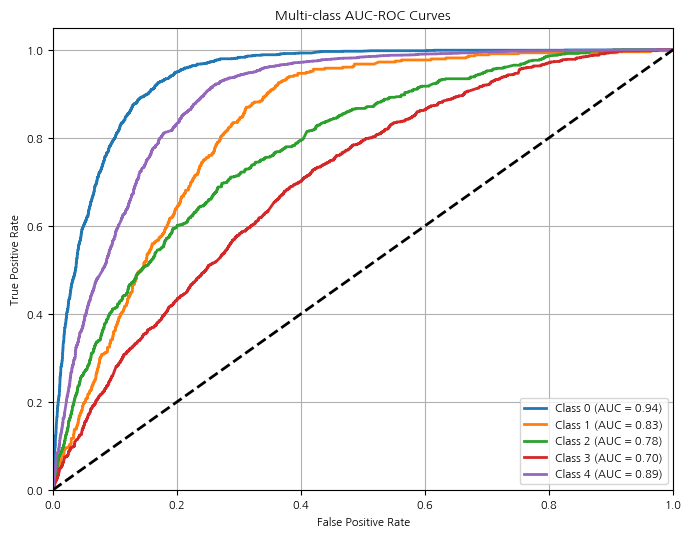

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class AUC
y_true_bin = label_binarize(y_true, classes=list(range(num_labels)))

plt.figure(figsize=(8,6))

for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class AUC-ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


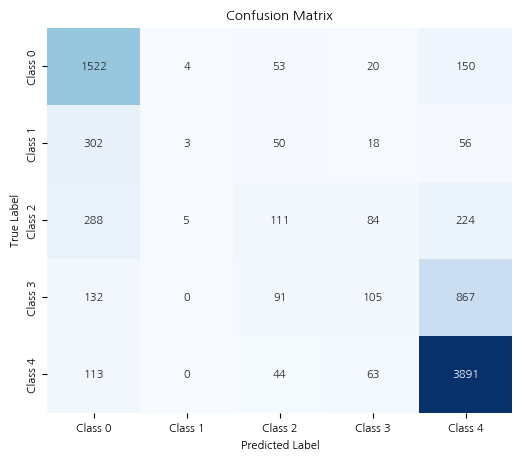

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(num_labels)],
            yticklabels=[f'Class {i}' for i in range(num_labels)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Revisit RFM 

In [ ]:
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv', dtype={'order_status': 'category'}
                , parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv'
                , parse_dates=['review_creation_date', 'review_answer_timestamp']
                )
items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv'
                , parse_dates=['shipping_limit_date'])
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv', dtype={'product_category_name': 'category'})
sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv', dtype={'seller_city': 'category', 'seller_state': 'category'})
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv', dtype={'customer_city': 'category', 'customer_state': 'category'})
category_translation = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv', dtype={'product_category_name': 'category', 'product_category_name_english': 'category'})
geolocations = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv', dtype={'geolocation_city': 'category', 'geolocation_state': 'category'})

In [ ]:
geolocationMean = geolocations.groupby('geolocation_zip_code_prefix', as_index = False).agg({'geolocation_lat'  : 'max',
                                                                                            'geolocation_lng'  : 'max'})

In [ ]:
merged = customers.merge(orders, on = 'customer_id').merge(items, on = 'order_id').merge(products, on = 'product_id').merge(geolocationMean, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').merge(payments, on = 'order_id').merge(sellers, on = 'seller_id').merge(category_translation, on = 'product_category_name').merge(reviews, on = 'order_id', how = 'left')

In [ ]:
recency = merged.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'},inplace = True)
recency.head()

,customer_unique_id,LastPurchaseDate
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [ ]:
recent_date = merged['order_purchase_timestamp'].dt.date.max()
print('The last recent date in the available dataset is: ', recent_date)

The last recent date in the available dataset is:  2018-09-03


In [ ]:
recency['Recency'] = recency['LastPurchaseDate'].dt.date.apply(lambda x: (recent_date - x).days)
recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,119
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,542
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,326
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,293


In [ ]:
frequency = merged.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={'order_id':'Frequency'},inplace=True)
frequency.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [ ]:
frequency['Frequency'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15])

In [ ]:
monetary = merged.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [ ]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
rfm['Recency'] = rfm.Recency.apply(lambda x: 1 if x == 0 else x)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


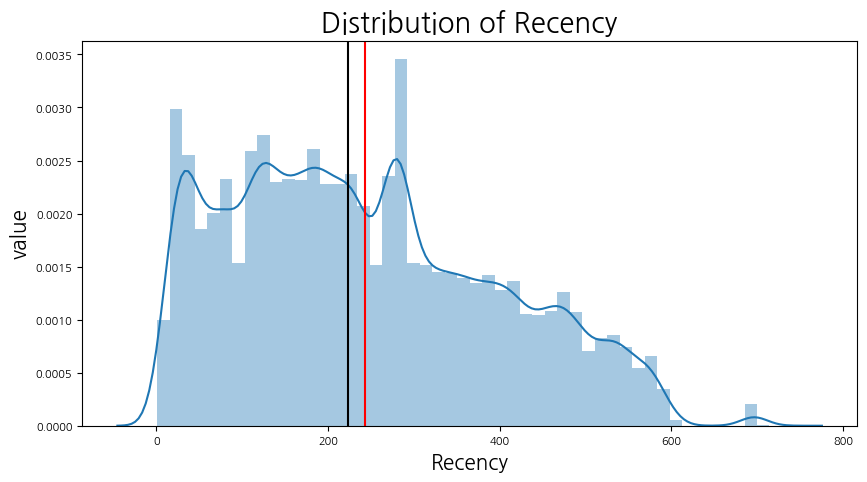

Mean of recency:  242.8308305534536
Median of recency:  223.0
Skewness of recency:  0.45252513788860177


In [ ]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Recency)
plt.axvline(rfm.Recency.mean(), c = 'red')
plt.axvline(rfm.Recency.median(), c = 'black')
plt.title('Distribution of Recency',fontweight='bold',fontsize=20)
plt.xlabel('Recency',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of recency: ', rfm.Recency.mean())
print('Median of recency: ', rfm.Recency.median())
print('Skewness of recency: ', rfm.Recency.skew())

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


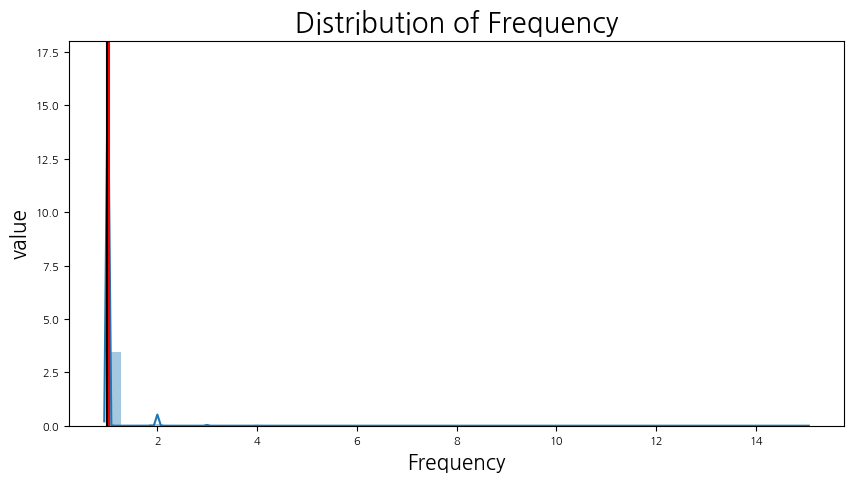

Mean of frequency:  1.0336569717251596
Median of frequency:  1.0
Skewness of frequency:  10.902114915919055


In [ ]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Frequency)
plt.axvline(rfm.Frequency.mean(), c = 'red')
plt.axvline(rfm.Frequency.median(), c = 'black')
plt.title('Distribution of Frequency',fontweight='bold',fontsize=20)
plt.xlabel('Frequency',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of frequency: ', rfm.Frequency.mean())
print('Median of frequency: ', rfm.Frequency.median())
print('Skewness of frequency: ', rfm.Frequency.skew())

In [ ]:
frequency['Frequency'].value_counts()

Frequency
1     90989
2      2609
3       184
4        30
5         9
6         3
7         3
9         1
15        1
Name: count, dtype: int64

In [ ]:
Q1 = np.quantile(rfm.Frequency, 0)
Q3 = np.quantile(rfm.Frequency, 0.99)
IQR = Q3 - Q1
frequencyDistribution = rfm[~((rfm.Frequency < Q1 - 1.5 * IQR) | (rfm.Frequency > Q3 + 1.5 * IQR))]
frequencyDistribution.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
frequencyDistribution['Frequency'].unique()

array([1, 2, 3])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


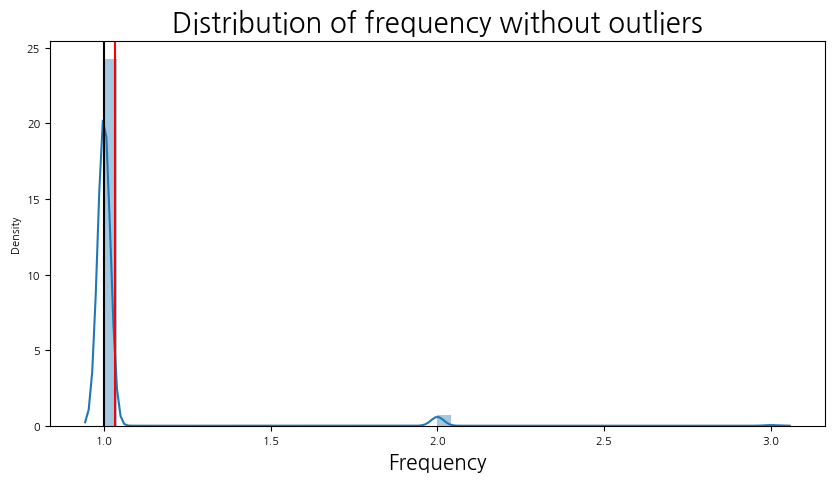

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(frequencyDistribution.Frequency)
plt.axvline(frequencyDistribution.Frequency.mean(), c = 'red')
plt.axvline(frequencyDistribution.Frequency.median(), c = 'black')
plt.xlabel('Frequency',color='black',fontsize=15)
plt.title('Distribution of frequency without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


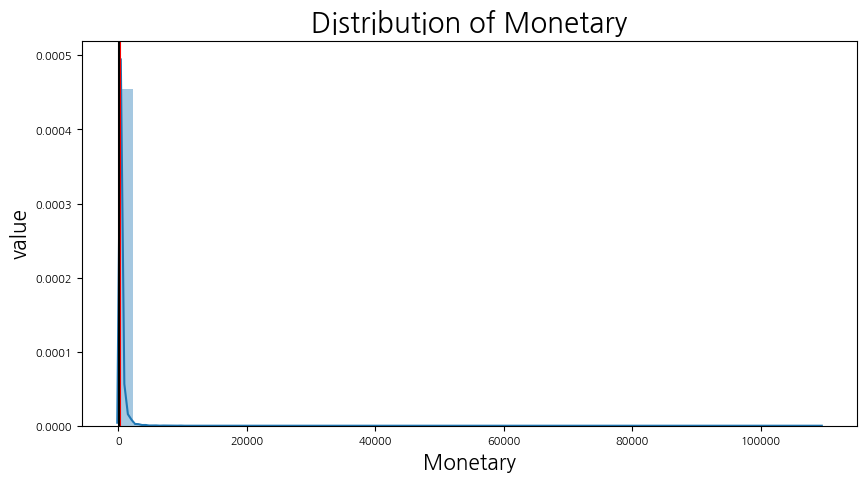

Mean of monetary:  214.212448816464
Median of monetary:  113.15
Skewness of monetary:  68.46418383727054


In [ ]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Monetary)
plt.axvline(rfm.Monetary.mean(), c = 'red')
plt.axvline(rfm.Monetary.median(), c = 'black')
plt.title('Distribution of Monetary',fontweight='bold',fontsize=20)
plt.xlabel('Monetary',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of monetary: ', rfm.Monetary.mean())
print('Median of monetary: ', rfm.Monetary.median())
print('Skewness of monetary: ', rfm.Monetary.skew())

In [ ]:
Q1 = np.quantile(rfm.Monetary, 0.25)
Q3 = np.quantile(rfm.Monetary, 0.75)
IQR = Q3 - Q1
monetaryDistribution = rfm[~((rfm.Monetary < Q1 - 1.5 * IQR) | (rfm.Monetary > Q3 + 1.5 * IQR))]
monetaryDistribution.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


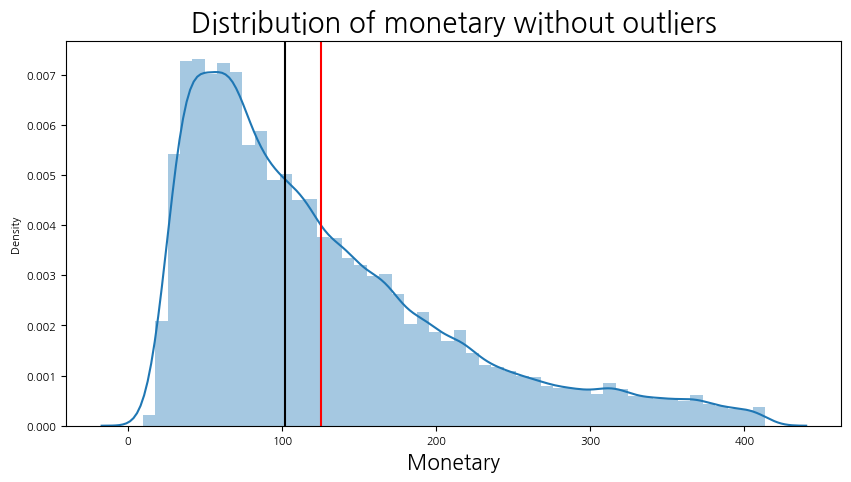

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(monetaryDistribution.Monetary)
plt.axvline(monetaryDistribution.Monetary.mean(), c = 'red')
plt.axvline(monetaryDistribution.Monetary.median(), c = 'black')
plt.xlabel('Monetary',color='black',fontsize=15)
plt.title('Distribution of monetary without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [ ]:
monetaryDistribution

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89
...,...,...,...,...
93822,fffb09418989a0dbff854a28163e47c6,260,1,73.16
93825,fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58
93826,ffff371b4d645b6ecea244b27531430a,573,1,112.46
93827,ffff5962728ec6157033ef9805bacc48,124,1,133.69


In [ ]:
frequencyDistribution[['customer_unique_id', 'Frequency']]

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93824,fffcf5a5ff07b0908bd4e2dbc735a684,1
93825,fffea47cd6d3cc0a88bd621562a9d061,1
93826,ffff371b4d645b6ecea244b27531430a,1
93827,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
rfm = recency.merge(frequencyDistribution[['customer_unique_id', 'Frequency']], on='customer_unique_id')
rfm = rfm.merge(monetaryDistribution[['customer_unique_id', 'Monetary']], on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
rfm['Frequency'].unique()

array([1, 2, 3])

In [ ]:
def assign_quantile_labels(series, q=3, ascending=True):
    try:
        result, bins = pd.qcut(series, q, retbins=True, duplicates='drop')
        n_bins = len(bins) - 1
        if n_bins == 0:
            # No bins possible, assign lowest score to all
            return pd.Series([1]*len(series), index=series.index)
        if ascending:
            labels = list(range(n_bins, 0, -1))  # descending labels for recency
        else:
            labels = list(range(1, n_bins + 1))
        labels = list(map(int, labels))
        scored = pd.qcut(series, q, labels=labels, duplicates='drop')
        scored_filled = scored.astype(object).fillna(min(labels)).astype(int)
        return scored_filled
    except Exception as e:
        print(f"Error in assign_quantile_labels: {e}")
        return pd.Series([1]*len(series), index=series.index)

In [ ]:
rfm['R_score'] = assign_quantile_labels(rfm['Recency'], q=3, ascending=True)
rfm['F_score'] = rfm['Frequency']
rfm['M_score'] = assign_quantile_labels(rfm['Monetary'], q=3, ascending=False)

/tmp/ipykernel_102/3648426420.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_filled = scored.astype(object).fillna(min(labels)).astype(int)
/tmp/ipykernel_102/3648426420.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_filled = scored.astype(object).fillna(min(labels)).astype(int)


In [ ]:
rfm['F_score'].unique()

array([1, 2, 3])

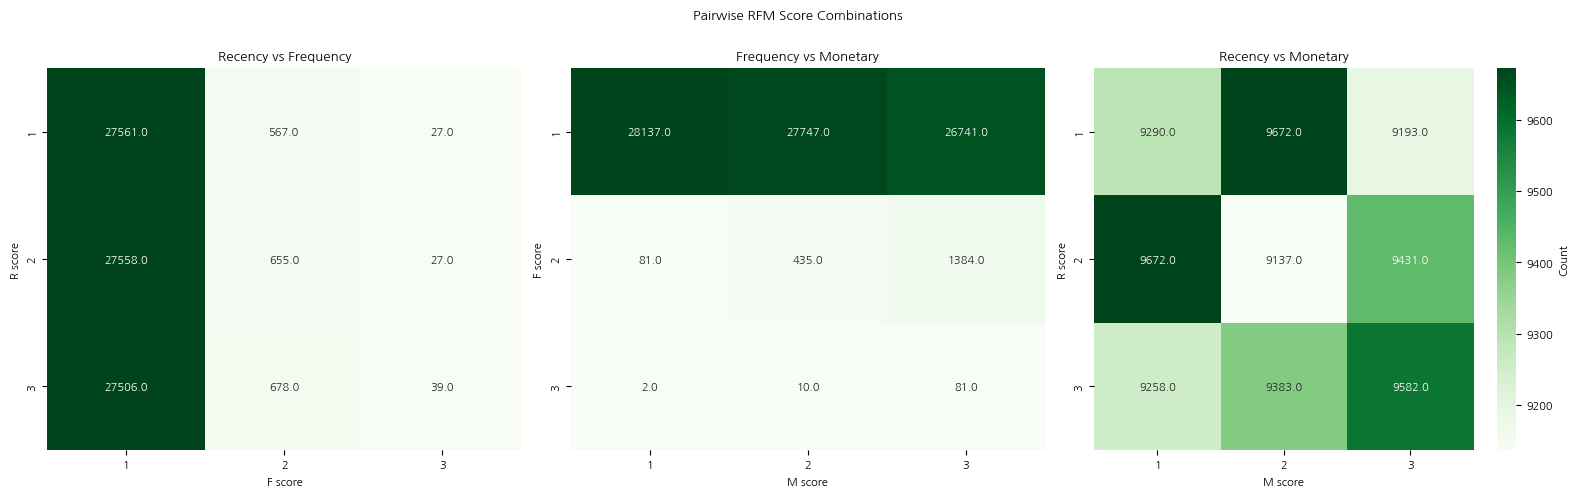

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))
matrix_defs = [
    ("Recency vs Frequency", 'R_score', 'F_score'),
    ("Frequency vs Monetary", 'F_score', 'M_score'),
    ("Recency vs Monetary", 'R_score', 'M_score')
]
for i, (title, row, col) in enumerate(matrix_defs):
    plt.subplot(1, 3, i+1)
    data = rfm.groupby([row, col]).size().unstack(fill_value=0)
    sns.heatmap(data, annot=True, fmt='.1f', cmap='Greens', cbar=i==2, 
                cbar_kws={'label': 'Count'} if i==2 else None)
    plt.title(title)
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel(row.replace('_', ' '))
plt.suptitle('Pairwise RFM Score Combinations')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


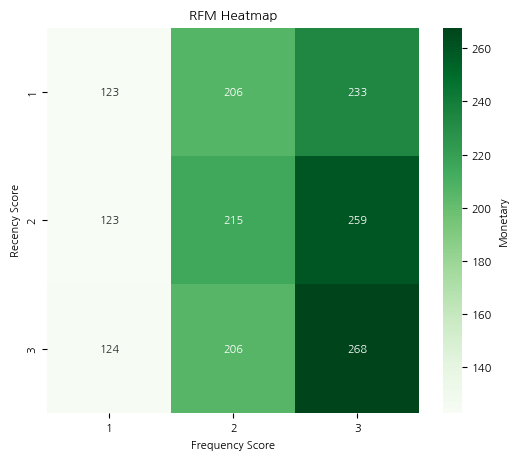

In [ ]:
plt.figure(figsize=(6,5))
pivot = rfm.pivot_table(values='Monetary', index='R_score', columns='F_score', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Greens', cbar_kws={'label':'Monetary'})
plt.title('RFM Heatmap')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

In [ ]:
del rfm

In [ ]:
rfm = recency.merge(frequencyDistribution[['customer_unique_id', 'Frequency']], on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
def assign_quantile_labels(series, q=3, ascending=True):
    try:
        result, bins = pd.qcut(series, q, retbins=True, duplicates='drop')
        n_bins = len(bins) - 1
        if n_bins == 0:
            # No bins possible, assign lowest score to all
            return pd.Series([1]*len(series), index=series.index)
        if ascending:
            labels = list(range(n_bins, 0, -1))  # descending labels for recency
        else:
            labels = list(range(1, n_bins + 1))
        labels = list(map(int, labels))
        scored = pd.qcut(series, q, labels=labels, duplicates='drop')
        scored_filled = scored.astype(object).fillna(min(labels)).astype(int)
        return scored_filled
    except Exception as e:
        print(f"Error in assign_quantile_labels: {e}")
        return pd.Series([1]*len(series), index=series.index)

In [ ]:
rfm['R_score'] = assign_quantile_labels(rfm['Recency'], q=3, ascending=True)
rfm['F_score'] = rfm['Frequency']
rfm['M_score'] = assign_quantile_labels(rfm['Monetary'], q=3, ascending=False)

/tmp/ipykernel_102/3648426420.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_filled = scored.astype(object).fillna(min(labels)).astype(int)
/tmp/ipykernel_102/3648426420.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_filled = scored.astype(object).fillna(min(labels)).astype(int)


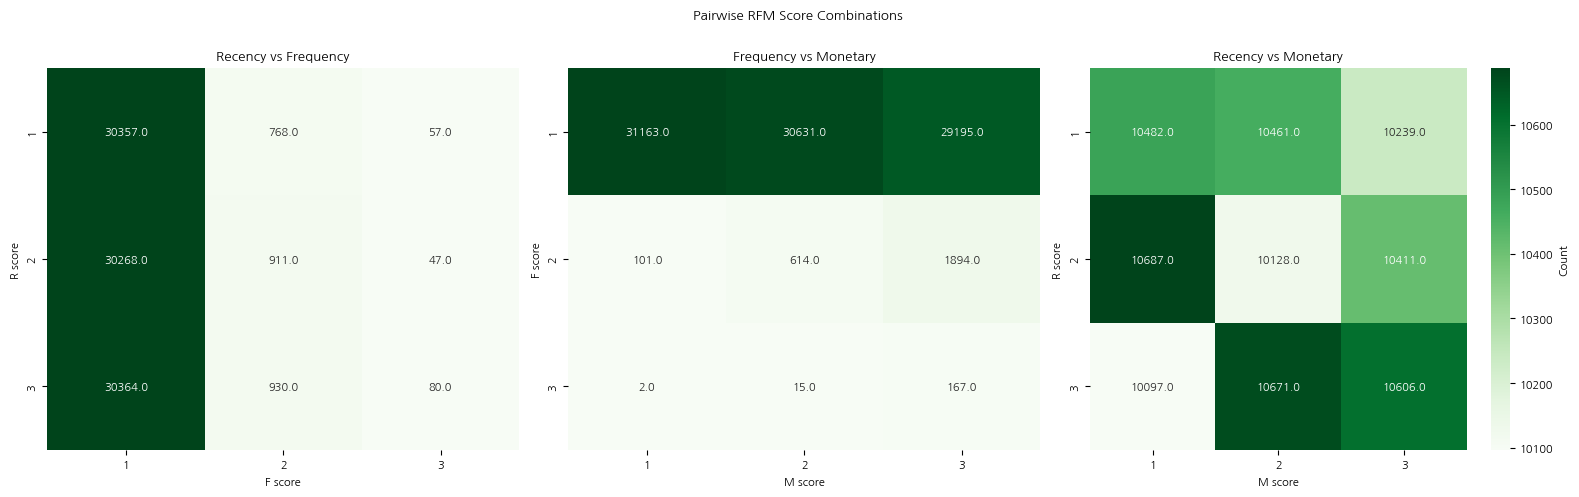

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))
matrix_defs = [
    ("Recency vs Frequency", 'R_score', 'F_score'),
    ("Frequency vs Monetary", 'F_score', 'M_score'),
    ("Recency vs Monetary", 'R_score', 'M_score')
]
for i, (title, row, col) in enumerate(matrix_defs):
    plt.subplot(1, 3, i+1)
    data = rfm.groupby([row, col]).size().unstack(fill_value=0)
    sns.heatmap(data, annot=True, fmt='.1f', cmap='Greens', cbar=i==2, 
                cbar_kws={'label': 'Count'} if i==2 else None)
    plt.title(title)
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel(row.replace('_', ' '))
plt.suptitle('Pairwise RFM Score Combinations')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


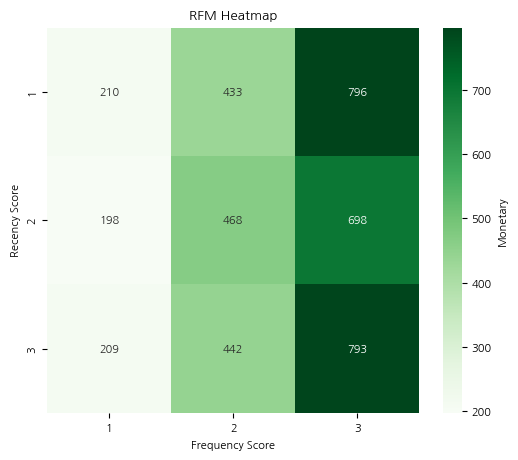

In [ ]:
plt.figure(figsize=(6,5))
pivot = rfm.pivot_table(values='Monetary', index='R_score', columns='F_score', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Greens', cbar_kws={'label':'Monetary'})
plt.title('RFM Heatmap')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()